In [1]:
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from collections import Counter

from sklearn.base import clone
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import dendrogram
from sklearn.manifold import TSNE
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
import graphviz

from kmodes.kmodes import KModes
from math import ceil
from os.path import join
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import matplotlib.cm as cm
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans
from sklearn.impute import KNNImputer
from scipy.stats import chi2_contingency
from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import StandardScaler
import sompy
from sompy.visualization.mapview import View2D
from sompy.visualization.bmuhits import BmuHitsView
from sompy.visualization.hitmap import HitMapView
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score

import warnings
sns.set()
warnings.filterwarnings('ignore')

ImportError: cannot import name 'SOM' from partially initialized module 'sompy' (most likely due to a circular import) (C:\Users\pcata\anaconda3\envs\datamining\Lib\site-packages\sompy\__init__.py)

In [2]:
pip install --upgrade sompy

In [2]:
data = pd.read_csv('data_preprocessed_StandardScaler_activities.csv', sep=',')

In [3]:
data.head()

ID       Age  DaysWithoutFrequency  LifetimeValue  NumberOfFrequencies  \
0  10000  2.452289             -0.587244      -0.602086            -0.495738   
1  10001  0.223473             -0.144577       0.579351            -0.256085   
2  10002 -0.207910             -0.542227      -0.758914            -0.547092   
3  10003 -1.214473             -0.429685      -0.401922            -0.307440   
4  10005 -0.136013             -0.572239      -0.448591            -0.170495   

   AttendedClasses  AllowedWeeklyVisits  AllowedNVisits   NVisits  NRenewals  \
0        -0.091962            -2.381734       -1.797580 -0.535108  -0.879255   
1        -0.322828            -1.525427       -1.225397 -0.699188   0.653238   
2        -0.361306             0.615339       -0.577709  0.121214  -0.879255   
3        -0.284351            -1.525427       -1.209988 -0.371027  -0.879255   
4        -0.361306             0.615339        0.910790  3.402824  -0.879255   

   ...  Dropout  Gender_binary  Athletics  Water  Fitness  Team  Racket  \
0  ...        0              1        0.0    0.0      1.0   0.0     0.0   
1  ...        1              1        0.0    0.0      0.0   0.0     0.0   
2  ...        1              0        0.0    0.0      1.0   0.0     0.0   
3  ...        1              0        0.0    0.0      0.0   1.0     0.0   
4  ...        1              1        0.0    0.0      1.0   0.0     0.0   

   Combat  Special  Other  
0     0.0      0.0    0.0  
1     0.0      1.0    0.0  
2     0.0      0.0    0.0  
3     0.0      0.0    0.0  
4     0.0      0.0    0.0  

[5 rows x 26 columns]

In [4]:
data.set_index('ID', inplace=True)

In [5]:
non_metric_features=['UseByTime', 'Dropout','Gender_binary','Athletics', 'Water', 'Fitness', 'Team', 'Racket','Combat', 'Special', 'Other']


metric_features =  ['Age','DaysWithoutFrequency', 'LifetimeValue','NumberOfFrequencies', 'AttendedClasses',
                    'AllowedWeeklyVisits','AllowedNVisits', 'NVisits', 'NRenewals','NReferences','EnrollmentTime',
                    'DaysSinceLastVisit','NActivities','AvgLifeTimeValue']

In [6]:
def cluster_profiles(df, label_columns, figsize, compar_titles=None):
    """
    Pass df with labels columns of one or multiple clustering labels. 
    Then specify this label columns to perform the cluster profile according to them.
    """
    if compar_titles == None:
        compar_titles = [""]*len(label_columns)
        
    sns.set()
    fig, axes = plt.subplots(nrows=len(label_columns), ncols=2, figsize=figsize, squeeze=False)
    for ax, label, titl in zip(axes, label_columns, compar_titles):
        # Filtering df
        drop_cols = [i for i in label_columns if i!=label]
        dfax = df.drop(drop_cols, axis=1)
        
        # Getting the cluster centroids and counts
        centroids = dfax.groupby(by=label, as_index=False).mean()
        counts = dfax.groupby(by=label, as_index=False).count().iloc[:,[0,1]]
        counts.columns = [label, "counts"]
        
        # Setting Data
        pd.plotting.parallel_coordinates(centroids, label, color=sns.color_palette(), ax=ax[0])
        sns.barplot(x=label, y="counts", data=counts, ax=ax[1])

        #Setting Layout
        handles, _ = ax[0].get_legend_handles_labels()
        cluster_labels = ["Cluster {}".format(i) for i in range(len(handles))]
        ax[0].annotate(text=titl, xy=(0.95,1.1), xycoords='axes fraction', fontsize=13, fontweight = 'heavy') 
        ax[0].legend(handles, cluster_labels) # Adaptable to number of clusters
        ax[0].axhline(color="black", linestyle="--")
        ax[0].set_title("Cluster Means - {} Clusters".format(len(handles)), fontsize=13)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=-20)
        ax[1].set_xticklabels(cluster_labels)
        ax[1].set_xlabel("")
        ax[1].set_ylabel("Absolute Frequency")
        ax[1].set_title("Cluster Sizes - {} Clusters".format(len(handles)), fontsize=13)
    
    plt.subplots_adjust(hspace=0.4, top=0.90)
    plt.suptitle("Cluster Simple Profilling", fontsize=23)
    plt.show()

# Perspectives

In [7]:
dem_value_features = ['Age','AvgLifeTimeValue','LifetimeValue','EnrollmentTime']
behavior_features = ['DaysWithoutFrequency', 'NumberOfFrequencies','AttendedClasses', 'AllowedWeeklyVisits', 'AllowedNVisits', 'NVisits','NRenewals', 'NReferences', 'DaysSinceLastVisit','NActivities']

non_metric = ['UseByTime', 'Dropout','Gender_binary']
preference_features = ['Athletics', 'Water', 'Fitness', 'Team', 'Racket','Combat', 'Special', 'Other']

df_dem = data[dem_value_features].copy()
df_bhv = data[behavior_features].copy()
df_pref = data[preference_features].copy()

# Preference Perspective

## K-modes

Loaded backend module://matplotlib_inline.backend_inline version unknown.
Loaded backend module://matplotlib_inline.backend_inline version unknown.
findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
findfont: score(FontEntry(fname='/Users/catarinasilva/anaconda3/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-BoldItalic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='/Users/catarinasilva/anaconda3/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmb10.ttf', name='cmb10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/Users/catarinasilva/anaconda3/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-Oblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=400, stretch='normal', size='sc

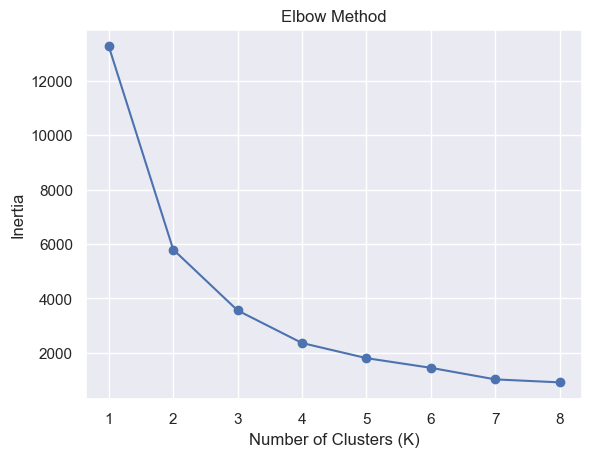

In [8]:
from kmodes.kmodes import KModes
k_values = range(1, 9)
inertias = []

for k in k_values:
    kmode_model = KModes(n_clusters=k, init='Huang', n_init=5, verbose=0)
    kmode_model.fit_predict(df_pref)
    inertias.append(kmode_model.cost_)

# Plot the elbow curve
plt.plot(k_values, inertias, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

In [9]:
k = 3  # Number of clusters
kmode_model = KModes(n_clusters=k, init='Huang', n_init=5, verbose=1)

# Fit the model to the data
clusters = kmode_model.fit_predict(df_pref)

# View the cluster centroids (modes)
print("Cluster Centroids:")
print(kmode_model.cluster_centroids_)

# View the assigned clusters for each data point
print("Cluster Assignments:")
print(clusters)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 1334, cost: 5426.0
Run 1, iteration: 2/100, moves: 21, cost: 5426.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 1306, cost: 5210.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 5020, cost: 5426.0
Run 3, iteration: 2/100, moves: 295, cost: 5426.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 1140, cost: 3554.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 116, cost: 4564.0
Best run was number 4
Cluster Centroids:
[[0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]]
Cluster Assignments:
[2 0 2 ... 2 0 2]


In [10]:
df_pref['Kmodes_Clusters'] = clusters

df_pref['Kmodes_Clusters'].value_counts()

Kmodes_Clusters
2    7544
0    5301
1    1421
Name: count, dtype: int64

In [11]:
df_pref

Athletics  Water  Fitness  Team  Racket  Combat  Special  Other  \
ID                                                                       
10000        0.0    0.0      1.0   0.0     0.0     0.0      0.0    0.0   
10001        0.0    0.0      0.0   0.0     0.0     0.0      1.0    0.0   
10002        0.0    0.0      1.0   0.0     0.0     0.0      0.0    0.0   
10003        0.0    0.0      0.0   1.0     0.0     0.0      0.0    0.0   
10005        0.0    0.0      1.0   0.0     0.0     0.0      0.0    0.0   
...          ...    ...      ...   ...     ...     ...      ...    ...   
24937        0.0    1.0      0.0   0.0     0.0     0.0      0.0    0.0   
24938        0.0    0.0      0.0   0.0     0.0     1.0      0.0    0.0   
24939        0.0    0.0      1.0   0.0     0.0     0.0      0.0    0.0   
24940        0.0    1.0      0.0   0.0     0.0     0.0      0.0    0.0   
24941        0.0    0.0      1.0   0.0     0.0     0.0      0.0    0.0   

       Kmodes_Clusters  
ID                      
10000                2  
10001                0  
10002                2  
10003                0  
10005                2  
...                ...  
24937                0  
24938                1  
24939                2  
24940                0  
24941                2  

[14266 rows x 9 columns]

findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=13.0.
findfont: score(FontEntry(fname='/Users/catarinasilva/anaconda3/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-BoldItalic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='/Users/catarinasilva/anaconda3/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmb10.ttf', name='cmb10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/Users/catarinasilva/anaconda3/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-Oblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/Users/catarinasilva/anaconda3/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSiz

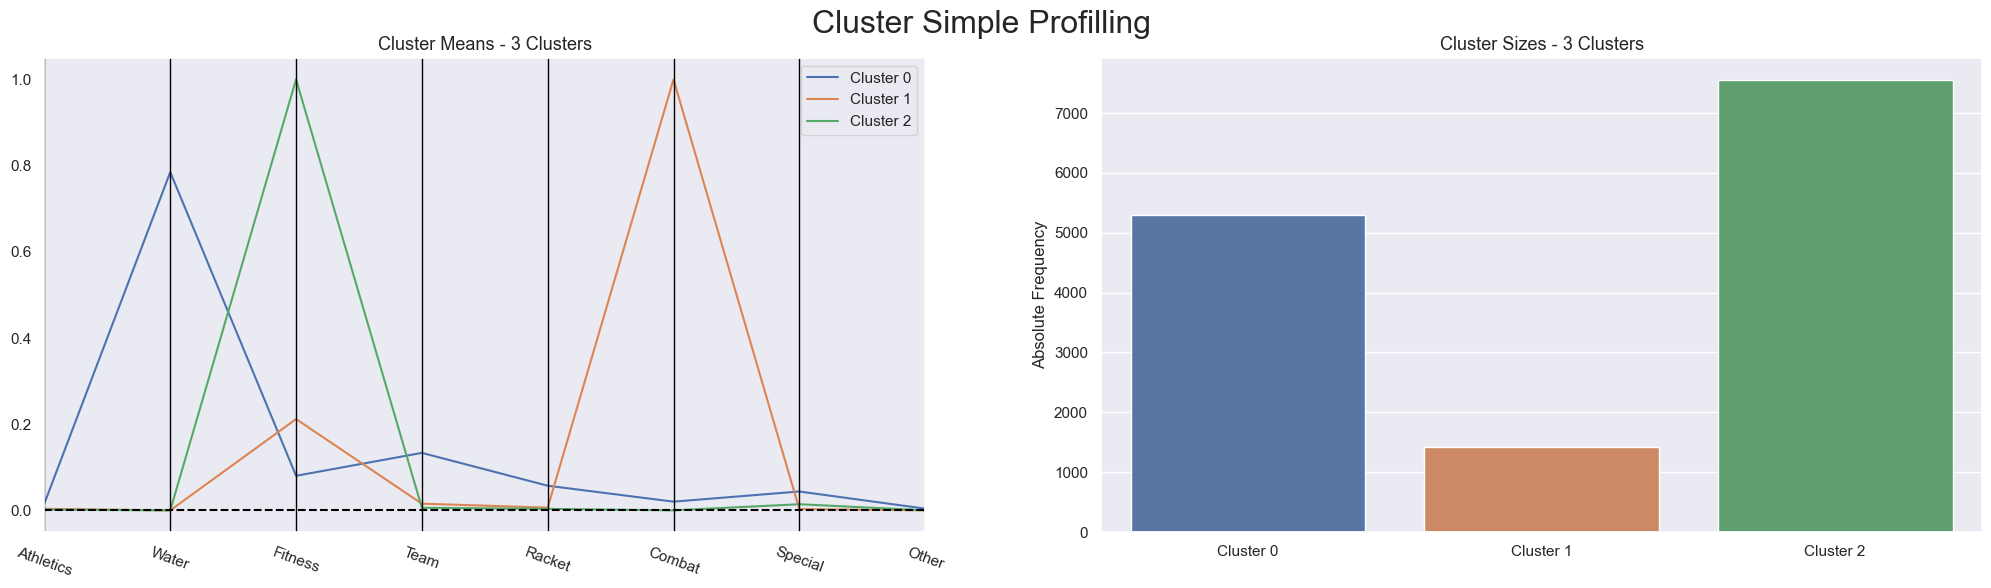

In [12]:
cluster_profiles(df_pref,['Kmodes_Clusters'],(25,6))

# Behavior + Demographic/Value Perspectives

## K-means + Hierarquical

In [13]:
df = data.copy()

In [14]:
def get_ss(df):
    """Computes the sum of squares for all variables given a dataset
    """
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

def r2(df, labels):
    sst = get_ss(df)
    ssw = np.sum(df.groupby(labels).apply(get_ss))
    return 1 - ssw/sst
    
def get_r2_scores(df, clusterer, min_k=2, max_k=10):
    """
    Loop over different values of k. To be used with sklearn clusterers.
    """
    r2_clust = {}
    for n in range(min_k, max_k):
        clust = clone(clusterer).set_params(n_clusters=n)
        labels = clust.fit_predict(df)
        r2_clust[n] = r2(df, labels)
    return r2_clust


# Set up the clusterers
kmeans = KMeans(
    init='k-means++',
    n_init=20,
    random_state=42
)

hierarchical = AgglomerativeClustering(
    metric='euclidean'
)

In [15]:
r2_scores = {}
r2_scores['kmeans'] = get_r2_scores(df_bhv, kmeans)

for linkage in ['complete', 'average', 'single', 'ward']:
    r2_scores[linkage] = get_r2_scores(
        df_bhv, hierarchical.set_params(linkage=linkage)
    )

pd.DataFrame(r2_scores)

kmeans  complete   average    single      ward
2  0.176470  0.037329  0.037821  0.001336  0.155003
3  0.278028  0.109675  0.040855  0.018875  0.246294
4  0.361401  0.139905  0.057919  0.040125  0.333400
5  0.431210  0.202836  0.058821  0.109804  0.405531
6  0.492385  0.287481  0.108256  0.110040  0.465982
7  0.550260  0.316188  0.176853  0.110457  0.517134
8  0.593392  0.319122  0.177186  0.110530  0.552988
9  0.620964  0.327583  0.178644  0.111434  0.583133

findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=21.0.
findfont: score(FontEntry(fname='/Users/catarinasilva/anaconda3/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-BoldItalic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='/Users/catarinasilva/anaconda3/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmb10.ttf', name='cmb10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/Users/catarinasilva/anaconda3/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-Oblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/Users/catarinasilva/anaconda3/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSiz

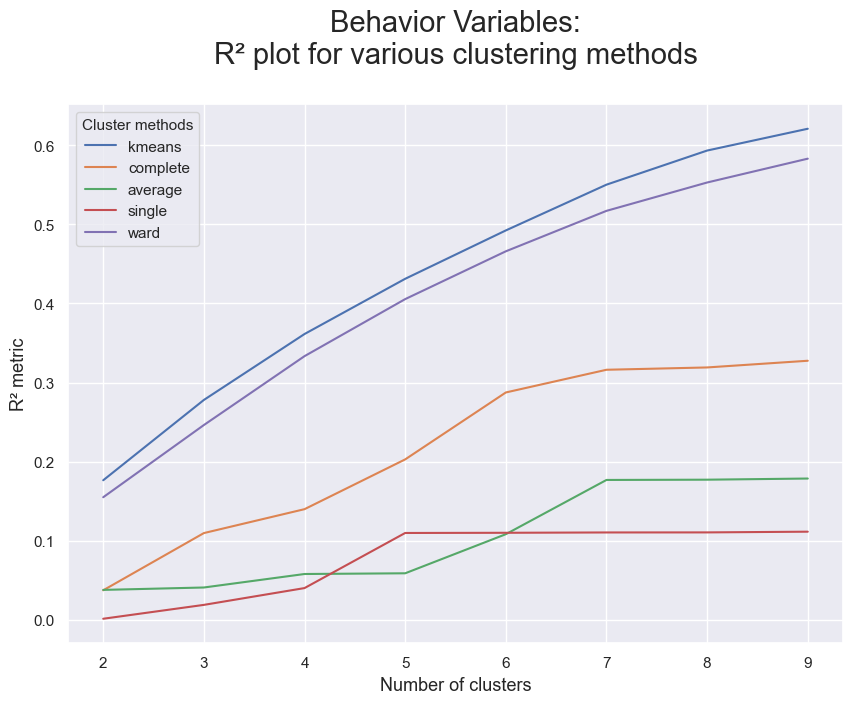

In [16]:
pd.DataFrame(r2_scores).plot.line(figsize=(10,7))

plt.title("Behavior Variables:\nR² plot for various clustering methods\n", fontsize=21)
plt.legend(title="Cluster methods", title_fontsize=11)
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R² metric", fontsize=13)
plt.show()

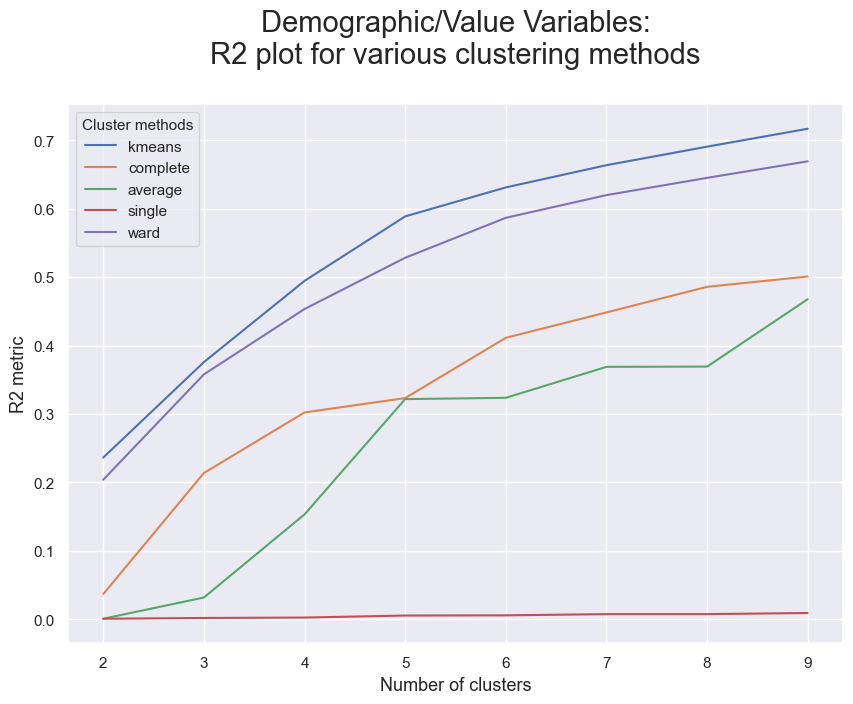

In [17]:
r2_scores = {}
r2_scores['kmeans'] = get_r2_scores(df_dem, kmeans)

for linkage in ['complete', 'average', 'single', 'ward']:
    r2_scores[linkage] = get_r2_scores(
        df_dem, hierarchical.set_params(linkage=linkage)
    )

# Visualizing the R² scores for each cluster solution on product variables
pd.DataFrame(r2_scores).plot.line(figsize=(10,7))

plt.title("Demographic/Value Variables:\nR2 plot for various clustering methods\n", fontsize=21)
plt.legend(title="Cluster methods", title_fontsize=11)
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2 metric", fontsize=13)
plt.show()

In [18]:
kmeans_value = KMeans(
    n_clusters=3,
    init='k-means++',
    n_init=20,
    random_state=42
)
value_labels = kmeans_value.fit_predict(df_dem)

kmeans_behav = KMeans(
    n_clusters=3,
    init='k-means++',
    n_init=20,
    random_state=42
)
behavior_labels = kmeans_behav.fit_predict(df_bhv)

df['value_labels'] = value_labels
df['behavior_labels'] = behavior_labels

In [19]:
pd.crosstab(df['behavior_labels'],
            df['value_labels'])

value_labels        0    1     2
behavior_labels                 
0                 218  745   686
1                8085   85  1041
2                2499  376   531

#### Merging with hierarchical

In [20]:
df_centroids = df.groupby(['behavior_labels', 'value_labels'])\
    [metric_features].mean()
df_centroids

Age  DaysWithoutFrequency  LifetimeValue  \
behavior_labels value_labels                                                  
0               0             0.703008             -0.405765       0.100219   
                1             0.045033             -0.346892       2.593159   
                2             0.281746             -0.186871       1.547200   
1               0             0.113524             -0.014703      -0.464592   
                1             0.646399              0.320774       1.007696   
                2             0.238461              0.674939       0.279155   
2               0            -0.345088             -0.129557      -0.277834   
                1            -1.191527             -0.314868       1.302234   
                2            -0.547493              0.576711       1.072522   

                              NumberOfFrequencies  AttendedClasses  \
behavior_labels value_labels                                         
0               0                        1.011985         0.050652   
                1                        2.211808         2.032314   
                2                        1.955012         0.891405   
1               0                       -0.304132        -0.347519   
                1                        0.264102        -0.304721   
                2                        0.181189        -0.307932   
2               0                       -0.403791         0.048968   
                1                        0.065834         1.028597   
                2                        0.042594         0.961209   

                              AllowedWeeklyVisits  AllowedNVisits   NVisits  \
behavior_labels value_labels                                                  
0               0                        0.432687        0.271653  2.088675   
                1                       -0.382344       -0.347253  0.859026   
                2                        0.168462        0.241853  0.538591   
1               0                        0.594845        0.412845 -0.032516   
                1                        0.575042        0.537538 -0.079543   
                2                        0.594775        0.580465 -0.243987   
2               0                       -1.639362       -1.141979 -0.248443   
                1                       -1.457105       -1.289227 -0.080395   
                2                       -1.427057       -1.159474 -0.546232   

                              NRenewals  NReferences  EnrollmentTime  \
behavior_labels value_labels                                           
0               0              0.814923    -0.069121       -0.457797   
                1              1.912145     0.370329       -0.858821   
                2              1.583680     0.275845        2.442568   
1               0             -0.436472    -0.107293       -0.303246   
                1              0.905649    -0.126700       -0.858821   
                2              0.946193    -0.054353        1.785943   
2               0             -0.406139     0.119419       -0.319233   
                1              0.806080    -0.043242       -0.858821   
                2              0.923084     0.381529        1.601266   

                              DaysSinceLastVisit  NActivities  \
behavior_labels value_labels                                    
0               0                      -0.891381     0.980749   
                1                      -1.205410     0.523192   
                2                      -0.561019     1.021284   
1               0                       0.289261    -0.121874   
                1                      -1.054162     0.130857   
                2                      -0.043656     0.103536   
2               0                      -0.105924    -0.130776   
                1                      -1.198156    -0.221943   
                2                      -0.021095    -0.051735   

               

In [21]:
linkage = 'ward'
hclust = AgglomerativeClustering(
    linkage=linkage, 
    metric='euclidean', 
    distance_threshold=0, 
    n_clusters=None
)
hclust_labels = hclust.fit_predict(df_centroids)

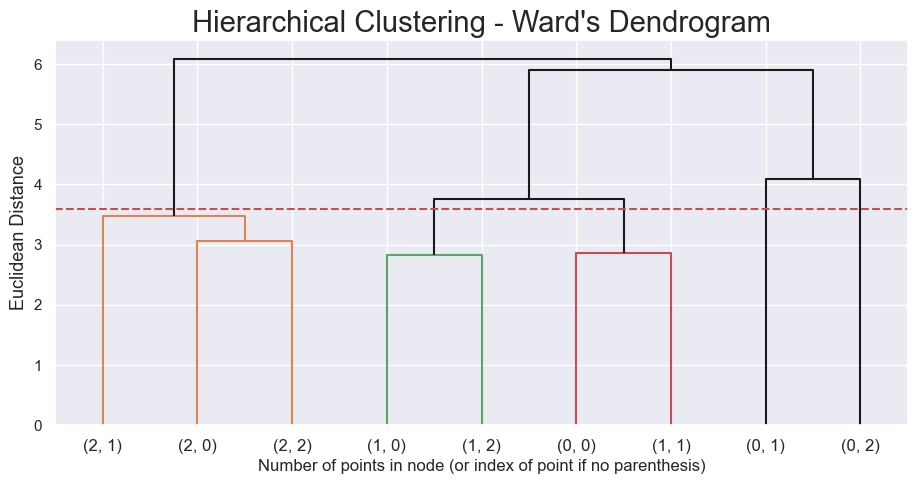

In [22]:
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 3.6
dendrogram(linkage_matrix, 
           truncate_mode='level', 
           labels=df_centroids.index, p=5, 
           color_threshold=y_threshold, 
           above_threshold_color='k')

plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'Euclidean Distance', fontsize=13)
plt.show()

In [23]:
hclust = AgglomerativeClustering(
    linkage='ward', 
    metric='euclidean', 
    n_clusters=4
)
hclust_labels = hclust.fit_predict(df_centroids)
df_centroids['hclust_labels'] = hclust_labels

df_centroids

Age  DaysWithoutFrequency  LifetimeValue  \
behavior_labels value_labels                                                  
0               0             0.703008             -0.405765       0.100219   
                1             0.045033             -0.346892       2.593159   
                2             0.281746             -0.186871       1.547200   
1               0             0.113524             -0.014703      -0.464592   
                1             0.646399              0.320774       1.007696   
                2             0.238461              0.674939       0.279155   
2               0            -0.345088             -0.129557      -0.277834   
                1            -1.191527             -0.314868       1.302234   
                2            -0.547493              0.576711       1.072522   

                              NumberOfFrequencies  AttendedClasses  \
behavior_labels value_labels                                         
0               0                        1.011985         0.050652   
                1                        2.211808         2.032314   
                2                        1.955012         0.891405   
1               0                       -0.304132        -0.347519   
                1                        0.264102        -0.304721   
                2                        0.181189        -0.307932   
2               0                       -0.403791         0.048968   
                1                        0.065834         1.028597   
                2                        0.042594         0.961209   

                              AllowedWeeklyVisits  AllowedNVisits   NVisits  \
behavior_labels value_labels                                                  
0               0                        0.432687        0.271653  2.088675   
                1                       -0.382344       -0.347253  0.859026   
                2                        0.168462        0.241853  0.538591   
1               0                        0.594845        0.412845 -0.032516   
                1                        0.575042        0.537538 -0.079543   
                2                        0.594775        0.580465 -0.243987   
2               0                       -1.639362       -1.141979 -0.248443   
                1                       -1.457105       -1.289227 -0.080395   
                2                       -1.427057       -1.159474 -0.546232   

                              NRenewals  NReferences  EnrollmentTime  \
behavior_labels value_labels                                           
0               0              0.814923    -0.069121       -0.457797   
                1              1.912145     0.370329       -0.858821   
                2              1.583680     0.275845        2.442568   
1               0             -0.436472    -0.107293       -0.303246   
                1              0.905649    -0.126700       -0.858821   
                2              0.946193    -0.054353        1.785943   
2               0             -0.406139     0.119419       -0.319233   
                1              0.806080    -0.043242       -0.858821   
                2              0.923084     0.381529        1.601266   

                              DaysSinceLastVisit  NActivities  \
behavior_labels value_labels                                    
0               0                      -0.891381     0.980749   
                1                      -1.205410     0.523192   
                2                      -0.561019     1.021284   
1               0                       0.289261    -0.121874   
                1                      -1.054162     0.130857   
                2                      -0.043656     0.103536   
2               0                      -0.105924    -0.130776   
                1                      -1.198156    -0.221943   
                2                      -0.021095    -0.051735   

               

In [24]:
cluster_mapper = df_centroids['hclust_labels'].to_dict()

kmeans_hierarchical = df.copy()

# Mapping the hierarchical clusters on the centroids to the observations
kmeans_hierarchical['kmeans/hierchical_labels'] = kmeans_hierarchical.apply(
    lambda row: cluster_mapper[
        (row['behavior_labels'], row['value_labels'])
    ], axis=1
)

# Merged cluster centroids
kmeans_hierarchical.groupby('kmeans/hierchical_labels').mean()[metric_features]

Age  DaysWithoutFrequency  LifetimeValue  \
kmeans/hierchical_labels                                                  
0                         0.145750              0.055419      -0.356149   
1                        -0.470084             -0.039906       0.107117   
2                         0.281746             -0.186871       1.547200   
3                         0.045033             -0.346892       2.593159   

                          NumberOfFrequencies  AttendedClasses  \
kmeans/hierchical_labels                                         
0                                   -0.215000        -0.333557   
1                                   -0.282356         0.299333   
2                                    1.955012         0.891405   
3                                    2.211808         2.032314   

                          AllowedWeeklyVisits  AllowedNVisits   NVisits  \
kmeans/hierchical_labels                                                  
0                                    0.590909        0.429211 -0.007245   
1                                   -1.586143       -1.160962 -0.276317   
2                                    0.168462        0.241853  0.538591   
3                                   -0.382344       -0.347253  0.859026   

                          NRenewals  NReferences  EnrollmentTime  \
kmeans/hierchical_labels                                           
0                         -0.242789    -0.100741       -0.081172   
1                         -0.065090     0.142326       -0.079391   
2                          1.583680     0.275845        2.442568   
3                          1.912145     0.370329       -0.858821   

                          DaysSinceLastVisit  NActivities  AvgLifeTimeValue  
kmeans/hierchical_labels                                                     
0                                   0.213098    -0.069217         -0.066722  
1                                  -0.213274    -0.128518          0.442224  
2                                  -0.561019     1.021284          0.079779  
3                                  -1.205410     0.523192         -1.250769

In [25]:
cluster_mapper

{(0, 0): 0,
 (0, 1): 3,
 (0, 2): 2,
 (1, 0): 0,
 (1, 1): 0,
 (1, 2): 0,
 (2, 0): 1,
 (2, 1): 1,
 (2, 2): 1}

In [26]:
kmeans_hierarchical

Age  DaysWithoutFrequency  LifetimeValue  NumberOfFrequencies  \
ID                                                                          
10000  2.452289             -0.587244      -0.602086            -0.495738   
10001  0.223473             -0.144577       0.579351            -0.256085   
10002 -0.207910             -0.542227      -0.758914            -0.547092   
10003 -1.214473             -0.429685      -0.401922            -0.307440   
10005 -0.136013             -0.572239      -0.448591            -0.170495   
...         ...                   ...            ...                  ...   
24937 -0.854986             -0.579741       3.553019             1.267420   
24938  0.942446             -0.309640       0.169174             0.325928   
24939 -0.423602             -0.579741      -0.740731            -0.547092   
24940  2.092803             -0.572239       1.516984             2.517038   
24941  0.439165             -0.489708       1.913979             2.243149   

       AttendedClasses  AllowedWeeklyVisits  AllowedNVisits   NVisits  \
ID                                                                      
10000        -0.091962            -2.381734       -1.797580 -0.535108   
10001        -0.322828            -1.525427       -1.225397 -0.699188   
10002        -0.361306             0.615339       -0.577709  0.121214   
10003        -0.284351            -1.525427       -1.209988 -0.371027   
10005        -0.361306             0.615339        0.910790  3.402824   
...                ...                  ...             ...       ...   
24937         3.332548            -0.669121       -0.330654  0.449375   
24938        -0.361306             0.615339        1.011461 -0.371027   
24939        -0.361306             0.615339       -0.577709  0.449375   
24940         5.602730            -1.097274       -1.305009  0.285295   
24941        -0.322828             0.615339        1.011461  1.269778   

       NRenewals  NReferences  ...  Water  Fitness  Team  Racket  Combat  \
ID                             ...                                         
10000  -0.879255      -0.1267  ...    0.0      1.0   0.0     0.0     0.0   
10001   0.653238      -0.1267  ...    0.0      0.0   0.0     0.0     0.0   
10002  -0.879255      -0.1267  ...    0.0      1.0   0.0     0.0     0.0   
10003  -0.879255      -0.1267  ...    0.0      0.0   1.0     0.0     0.0   
10005  -0.879255      -0.1267  ...    0.0      1.0   0.0     0.0     0.0   
...          ...          ...  ...    ...      ...   ...     ...     ...   
24937   1.419484      -0.1267  ...    1.0      0.0   0.0     0.0     0.0   
24938  -0.879255      -0.1267  ...    0.0      0.0   0.0     0.0     1.0   
24939  -0.879255      -0.1267  ...    0.0      1.0   0.0     0.0     0.0   
24940   0.653238      -0.1267  ...    1.0      0.0   0.0     0.0     0.0   
24941   2.185731      -0.1267  ...    0.0      1.0   0.0     0.0     0.0   

       Special  Other  value_labels  behavior_labels  kmeans/hierchical_labels  
ID                                                                              
10000      0.0    0.0             0                2                         1  
10001      1.0    0.0             0                2                         1  
10002      0.0    0.0             0                1                         0  
10003      0.0    0.0             0                2                         1  
10005      0.0    0.0             0                1                         0  
...        ...    ...           ...              ...                       ...  
24937      0.0    0.0             1                0                         3  
24938      0.0    0.0             0                1                         0  
24939      0.0    0.0             0                1                         0  
24940      0.0    0.0             1                0                         3  
24941      0.0    0.0             2                0                         2  

[14266 rows x 28 

In [27]:
df_counts = kmeans_hierarchical.groupby('kmeans/hierchical_labels')\
    .size()\
    .to_frame()

# Getting the product and behavior labels
df_counts = df_counts\
    .rename({v:k for k, v in cluster_mapper.items()})\
    .reset_index()

df_counts['behavior_labels'] = df_counts['kmeans/hierchical_labels'].apply(lambda x: x[0])
df_counts['value_labels'] = df_counts['kmeans/hierchical_labels'].apply(lambda x: x[1])

df_counts.pivot(values=0, index='behavior_labels', columns='value_labels')

value_labels         1       2
behavior_labels               
0                745.0   686.0
1                  NaN  9429.0
2                  NaN  3406.0

In [28]:
kmeans_hierarchical = kmeans_hierarchical.copy()

findfont: Matching sans\-serif:style=normal:variant=normal:weight=heavy:stretch=normal:size=13.0.
findfont: score(FontEntry(fname='/Users/catarinasilva/anaconda3/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-BoldItalic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.145
findfont: score(FontEntry(fname='/Users/catarinasilva/anaconda3/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmb10.ttf', name='cmb10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.43
findfont: score(FontEntry(fname='/Users/catarinasilva/anaconda3/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-Oblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.43
findfont: score(FontEntry(fname='/Users/catarinasilva/anaconda3/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizF

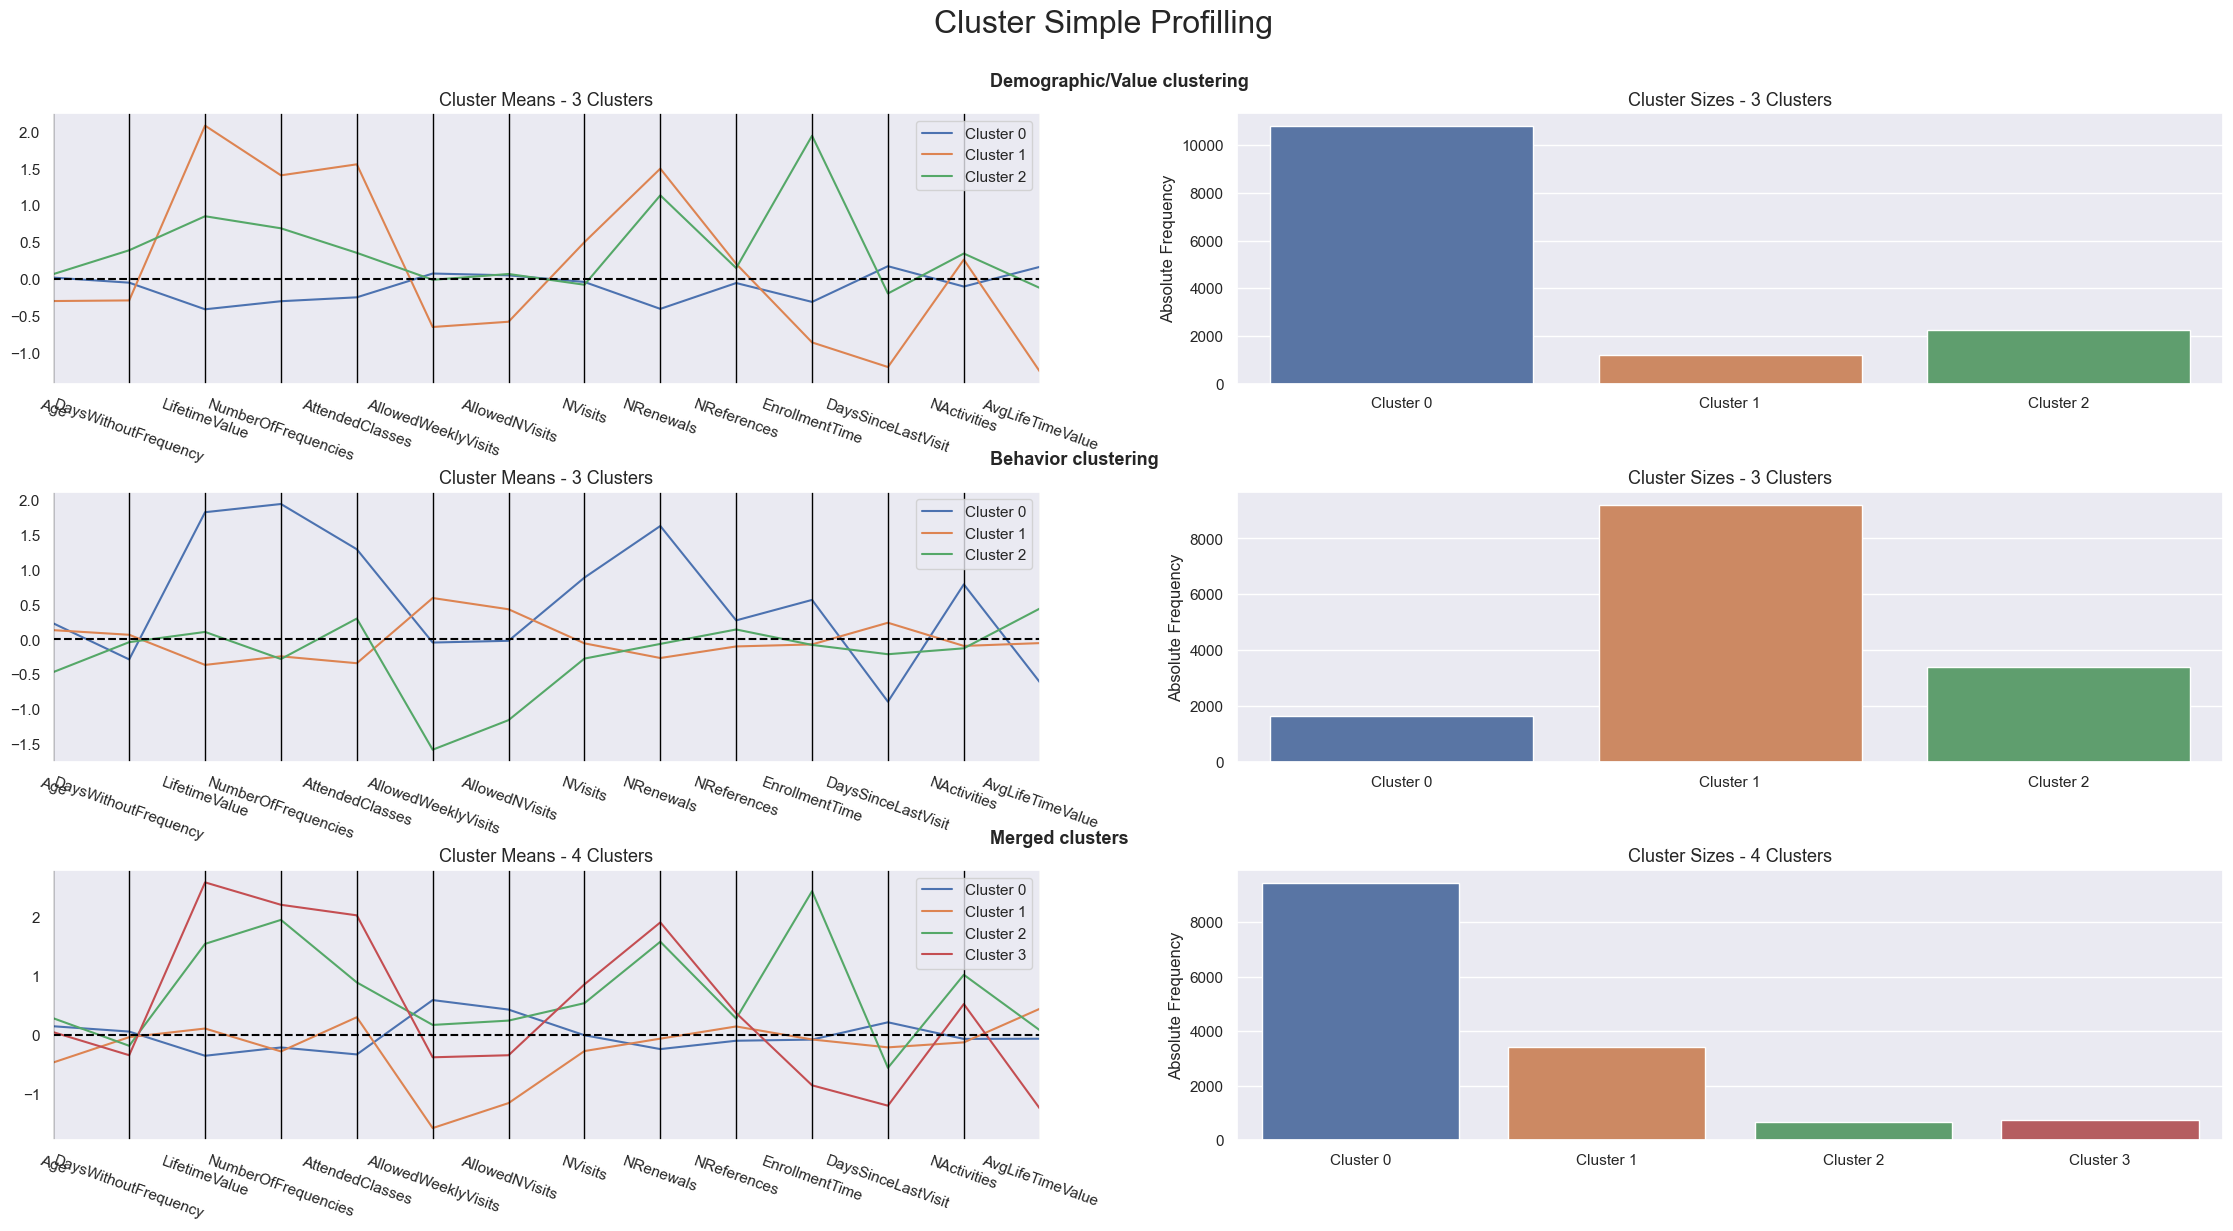

In [29]:
cluster_profiles(
    df = kmeans_hierarchical[metric_features + ['value_labels', 'behavior_labels', 'kmeans/hierchical_labels']], 
    label_columns = ['value_labels', 'behavior_labels', 'kmeans/hierchical_labels'], 
    figsize = (28, 13), 
    compar_titles = ["Demographic/Value clustering", "Behavior clustering", "Merged clusters"]
)

In [30]:
kmeans_hierarchical

Age  DaysWithoutFrequency  LifetimeValue  NumberOfFrequencies  \
ID                                                                          
10000  2.452289             -0.587244      -0.602086            -0.495738   
10001  0.223473             -0.144577       0.579351            -0.256085   
10002 -0.207910             -0.542227      -0.758914            -0.547092   
10003 -1.214473             -0.429685      -0.401922            -0.307440   
10005 -0.136013             -0.572239      -0.448591            -0.170495   
...         ...                   ...            ...                  ...   
24937 -0.854986             -0.579741       3.553019             1.267420   
24938  0.942446             -0.309640       0.169174             0.325928   
24939 -0.423602             -0.579741      -0.740731            -0.547092   
24940  2.092803             -0.572239       1.516984             2.517038   
24941  0.439165             -0.489708       1.913979             2.243149   

       AttendedClasses  AllowedWeeklyVisits  AllowedNVisits   NVisits  \
ID                                                                      
10000        -0.091962            -2.381734       -1.797580 -0.535108   
10001        -0.322828            -1.525427       -1.225397 -0.699188   
10002        -0.361306             0.615339       -0.577709  0.121214   
10003        -0.284351            -1.525427       -1.209988 -0.371027   
10005        -0.361306             0.615339        0.910790  3.402824   
...                ...                  ...             ...       ...   
24937         3.332548            -0.669121       -0.330654  0.449375   
24938        -0.361306             0.615339        1.011461 -0.371027   
24939        -0.361306             0.615339       -0.577709  0.449375   
24940         5.602730            -1.097274       -1.305009  0.285295   
24941        -0.322828             0.615339        1.011461  1.269778   

       NRenewals  NReferences  ...  Water  Fitness  Team  Racket  Combat  \
ID                             ...                                         
10000  -0.879255      -0.1267  ...    0.0      1.0   0.0     0.0     0.0   
10001   0.653238      -0.1267  ...    0.0      0.0   0.0     0.0     0.0   
10002  -0.879255      -0.1267  ...    0.0      1.0   0.0     0.0     0.0   
10003  -0.879255      -0.1267  ...    0.0      0.0   1.0     0.0     0.0   
10005  -0.879255      -0.1267  ...    0.0      1.0   0.0     0.0     0.0   
...          ...          ...  ...    ...      ...   ...     ...     ...   
24937   1.419484      -0.1267  ...    1.0      0.0   0.0     0.0     0.0   
24938  -0.879255      -0.1267  ...    0.0      0.0   0.0     0.0     1.0   
24939  -0.879255      -0.1267  ...    0.0      1.0   0.0     0.0     0.0   
24940   0.653238      -0.1267  ...    1.0      0.0   0.0     0.0     0.0   
24941   2.185731      -0.1267  ...    0.0      1.0   0.0     0.0     0.0   

       Special  Other  value_labels  behavior_labels  kmeans/hierchical_labels  
ID                                                                              
10000      0.0    0.0             0                2                         1  
10001      1.0    0.0             0                2                         1  
10002      0.0    0.0             0                1                         0  
10003      0.0    0.0             0                2                         1  
10005      0.0    0.0             0                1                         0  
...        ...    ...           ...              ...                       ...  
24937      0.0    0.0             1                0                         3  
24938      0.0    0.0             0                1                         0  
24939      0.0    0.0             0                1                         0  
24940      0.0    0.0             1                0                         3  
24941      0.0    0.0             2                0                         2  

[14266 rows x 28 

In [31]:
X = kmeans_hierarchical.drop(columns=['value_labels','behavior_labels','kmeans/hierchical_labels'])
y = kmeans_hierarchical['kmeans/hierchical_labels']

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Fitting the decision tree
dt = DecisionTreeClassifier(random_state=42, max_depth=3)
dt.fit(X_train, y_train)
print("It is estimated that in average, we are able to predict {0:.2f}% of the customers correctly".format(dt.score(X_test, y_test)*100))

It is estimated that in average, we are able to predict 94.64% of the customers correctly


In [32]:
labels = kmeans_hierarchical['kmeans/hierchical_labels']
hierarchical_silhouette_score = silhouette_score(kmeans_hierarchical,labels)
hierarchical_silhouette_score

0.2533838641632332

In [33]:
hierarchical_db_index = davies_bouldin_score(kmeans_hierarchical, labels)
hierarchical_db_index

1.9228179251298698

# Hierarchical Clustering

### Demographic + value perspective

In [34]:
df1 = df_dem.copy()

In [35]:
# Performing HC
hclust = AgglomerativeClustering(linkage='ward', metric='euclidean', n_clusters=5)
hc_labels = hclust.fit_predict(df1)
hc_labels

array([2, 3, 1, ..., 4, 0, 3])

In [36]:
# Characterizing the clusters
df_concat = pd.concat((df1, pd.Series(hc_labels, name='labels', index=df1.index)), axis=1)
df_concat.groupby('labels').mean()

Age  AvgLifeTimeValue  LifetimeValue  EnrollmentTime
labels                                                           
0      -0.286538         -1.250552       1.097460       -0.858429
1      -0.277211         -0.025982      -0.386727       -0.083273
2       1.607182          0.402401      -0.284907       -0.341494
3       0.078540         -0.088758       1.041474        2.216119
4      -0.256808          2.006358      -0.557273       -0.674220

In [37]:
# Computing SST
X = df1.values
sst = np.sum(np.square(X - X.mean(axis=0)), axis=0)

# Computing SSW
ssw_iter = []
for i in np.unique(hc_labels):
    X_k = X[hc_labels == i]
    ssw_iter.append(np.sum(np.square(X_k - X_k.mean(axis=0)), axis=0))
ssw = np.sum(ssw_iter, axis=0)

# Computing SSB
ssb_iter = []
for i in np.unique(hc_labels):
    X_k = X[hc_labels == i]
    ssb_iter.append(X_k.shape[0] * np.square(X_k.mean(axis=0) - X.mean(axis=0)))
ssb = np.sum(ssb_iter, axis=0)

# Verifying the formula
np.round(sst) == np.round((ssw + ssb))

array([ True,  True,  True,  True])

In [38]:
def get_r2_hc(df, link_method, max_nclus, min_nclus=1, dist="euclidean"):
    """This function computes the R2 for a set of cluster solutions given by the application of a hierarchical method.
    The R2 is a measure of the homogenity of a cluster solution. It is based on SSt = SSw + SSb and R2 = SSb/SSt. 
    
    Parameters:
    df (DataFrame): Dataset to apply clustering
    link_method (str): either "ward", "complete", "average", "single"
    max_nclus (int): maximum number of clusters to compare the methods
    min_nclus (int): minimum number of clusters to compare the methods. Defaults to 1.
    dist (str): distance to use to compute the clustering solution. Must be a valid distance. Defaults to "euclidean".
    
    Returns:
    ndarray: R2 values for the range of cluster solutions
    """
    def get_ss(df):
        ss = np.sum(df.var() * (df.count() - 1))
        return ss  # return sum of sum of squares of each df variable
    
    sst = get_ss(df)  # get total sum of squares
    
    r2 = []  # where we will store the R2 metrics for each cluster solution
    
    for i in range(min_nclus, max_nclus+1):  # iterate over desired ncluster range
        cluster = AgglomerativeClustering(n_clusters=i, metric=dist, linkage=link_method)
        
        
        # get cluster labels
        hclabels = cluster.fit_predict(df) 
        
        
        # concat df with labels
        df_concat = pd.concat((df, pd.Series(hclabels, name='labels', index=df.index)), axis=1)  
        
        
        # compute ssw for each cluster labels
        ssw_labels = df_concat.groupby(by='labels').apply(get_ss)  
        
        
        # remember: SST = SSW + SSB
        ssb = sst - np.sum(ssw_labels)  
        
        
        r2.append(ssb / sst)  # save the R2 of the given cluster solution
        
    return np.array(r2)

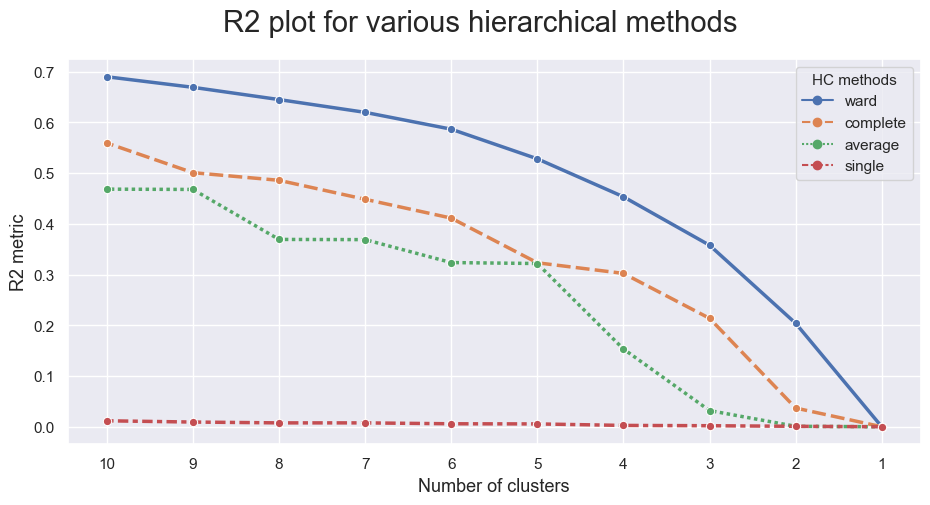

In [39]:
# Prepare input
hc_methods = ["ward", "complete", "average", "single"]
# Call function defined above to obtain the R2 statistic for each hc_method
max_nclus = 10
r2_hc_methods = np.vstack(
    [
        get_r2_hc(df=df1, link_method=link, max_nclus=max_nclus) 
        for link in hc_methods
    ]
).T
r2_hc_methods = pd.DataFrame(r2_hc_methods, index=range(1, max_nclus + 1), columns=hc_methods)

sns.set()
# Plot data
fig = plt.figure(figsize=(11,5))
sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)

# Finalize the plot
fig.suptitle("R2 plot for various hierarchical methods", fontsize=21)
plt.gca().invert_xaxis()  # invert x axis
plt.legend(title="HC methods", title_fontsize=11)
plt.xticks(range(1, max_nclus + 1))
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2 metric", fontsize=13)

plt.show()

### Defining the number the clusters

In [40]:
# setting distance_threshold=0 and n_clusters=None ensures we compute the full tree
linkage = 'ward'
distance = 'euclidean'
hclust = AgglomerativeClustering(linkage=linkage, metric=distance, distance_threshold=0, n_clusters=None)
hclust.fit_predict(df1)

array([ 9155, 12091, 12199, ...,     3,     1,     0])

findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=6.0.
findfont: score(FontEntry(fname='/Users/catarinasilva/anaconda3/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-BoldItalic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='/Users/catarinasilva/anaconda3/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmb10.ttf', name='cmb10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/Users/catarinasilva/anaconda3/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-Oblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/Users/catarinasilva/anaconda3/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizF

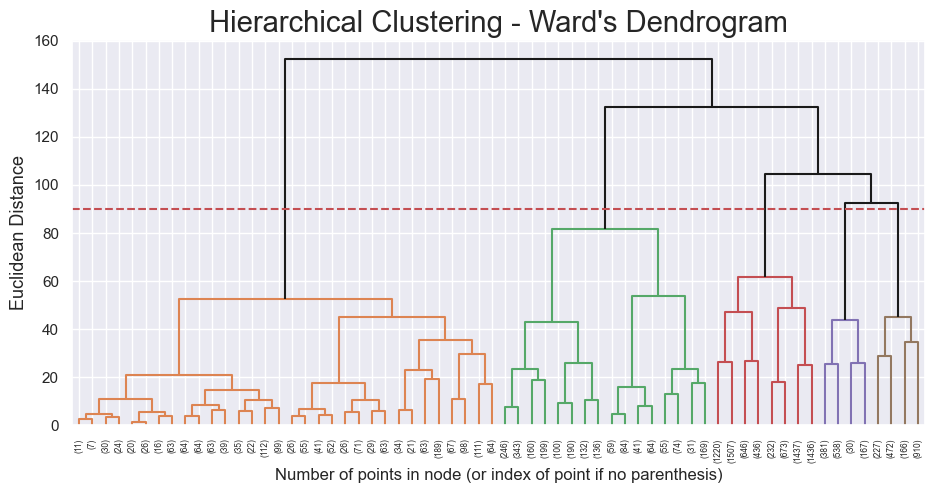

In [41]:
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 90
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

In [42]:
# 4 cluster solution
linkage = 'ward'
distance = 'euclidean'
hc4lust = AgglomerativeClustering(linkage=linkage, metric=distance, n_clusters=4)
hc4_labels = hc4lust.fit_predict(df1)

In [43]:
# Characterizing the 4 clusters
df_concat = pd.concat((df1, pd.Series(hc4_labels, name='labels', index=df1.index)), axis=1)
df_concat.groupby('labels').mean()

Age  AvgLifeTimeValue  LifetimeValue  EnrollmentTime
labels                                                           
0       0.887634          1.021569      -0.390048       -0.469935
1      -0.277211         -0.025982      -0.386727       -0.083273
2      -0.286538         -1.250552       1.097460       -0.858429
3       0.078540         -0.088758       1.041474        2.216119

In [44]:
# 3 cluster solution
linkage = 'ward'
distance = 'euclidean'
hc3lust = AgglomerativeClustering(linkage=linkage, metric=distance, n_clusters=3)
hc3_labels = hc3lust.fit_predict(df1)

In [45]:
# Characterizing the 11 clusters
df_concat = pd.concat((df1, pd.Series(hc3_labels, name='labels', index=df1.index)), axis=1)
df_concat.groupby('labels').mean()

Age  AvgLifeTimeValue  LifetimeValue  EnrollmentTime
labels                                                           
0       0.044183          0.263050      -0.387643       -0.189957
1       0.078540         -0.088758       1.041474        2.216119
2      -0.286538         -1.250552       1.097460       -0.858429

In [46]:
df_hc4_hc3 = pd.concat((df1,
                        pd.Series(hc4_labels,
                                  name='hc4_labels',
                                  index=df1.index),
                        pd.Series(hc3_labels,
                                  name='hc3_labels',
                                  index=df1.index)
                        ), axis=1)

In [47]:
pd.crosstab(df_hc4_hc3['hc4_labels'],
           df_hc4_hc3['hc3_labels'])

hc3_labels     0     1     2
hc4_labels                  
0           2891     0     0
1           7587     0     0
2              0     0  2083
3              0  1705     0

In [48]:
# final cluster solution
linkage = 'ward'
distance = 'euclidean'
hclust = AgglomerativeClustering(linkage=linkage, metric=distance, n_clusters=4)
hc_labels = hclust.fit_predict(df1)

In [49]:
# Characterizing the final clusters
hierarchical_dem = pd.concat((df1, pd.Series(hc_labels, name='hierarchical/dem_labels', index=df1.index)), axis=1)
hierarchical_dem.groupby('hierarchical/dem_labels').mean()

Age  AvgLifeTimeValue  LifetimeValue  \
hierarchical/dem_labels                                              
0                        0.887634          1.021569      -0.390048   
1                       -0.277211         -0.025982      -0.386727   
2                       -0.286538         -1.250552       1.097460   
3                        0.078540         -0.088758       1.041474   

                         EnrollmentTime  
hierarchical/dem_labels                  
0                             -0.469935  
1                             -0.083273  
2                             -0.858429  
3                              2.216119

In [50]:
cluster_means = hierarchical_dem.groupby('hierarchical/dem_labels').mean().T
cluster_means.style.format(precision=2).background_gradient(axis=1)

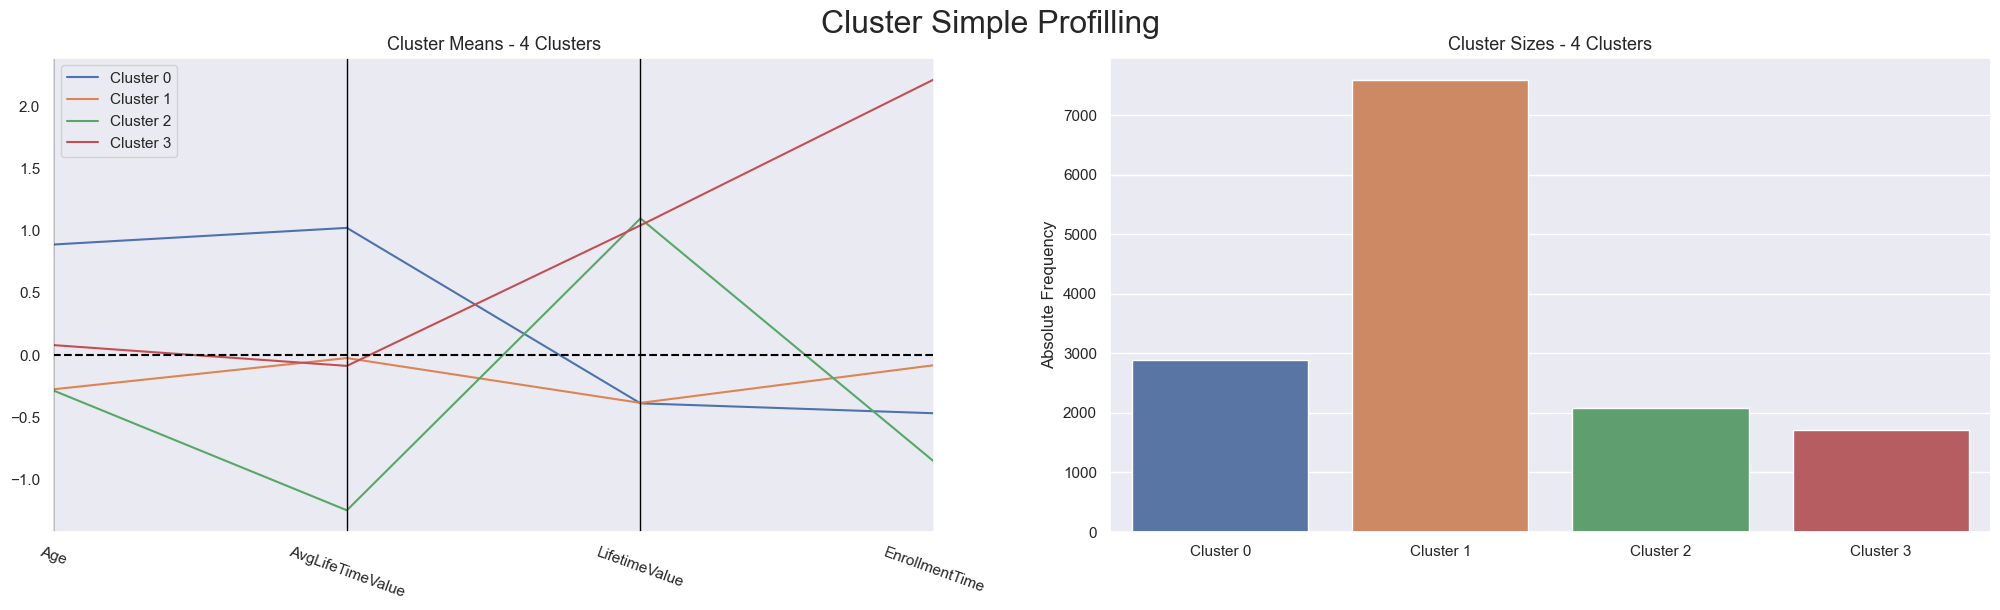

In [51]:
cluster_profiles(hierarchical_dem, ['hierarchical/dem_labels'], (25,6))

In [52]:
hierarchical_silhouette_score = silhouette_score(hierarchical_dem, hclust.labels_)
hierarchical_silhouette_score

0.3703938988376556

In [53]:
hierarchical_db_index = davies_bouldin_score(hierarchical_dem, hclust.labels_)
hierarchical_db_index

1.1847218203101422

### Behavior Features

In [54]:
df2 = df_bhv.copy()

In [55]:
hclust = AgglomerativeClustering(linkage='ward', metric='euclidean', n_clusters=5)
hc_labels = hclust.fit_predict(df2)
hc_labels

array([1, 1, 0, ..., 0, 1, 2])

In [56]:
df_concat = pd.concat((df2, pd.Series(hc_labels, name='labels', index=df2.index)), axis=1)
df_concat.groupby('labels').mean()

DaysWithoutFrequency  NumberOfFrequencies  AttendedClasses  \
labels                                                               
0                   0.182428            -0.272786        -0.333456   
1                  -0.245188            -0.050228         0.774721   
2                  -0.402618             1.571499        -0.318861   
3                   0.115937             0.477002         1.336749   
4                  -0.098207             0.139602         0.067423   

        AllowedWeeklyVisits  AllowedNVisits   NVisits  NRenewals  NReferences  \
labels                                                                          
0                  0.563849        0.376998 -0.227022  -0.207894    -0.125155   
1                 -1.495866       -1.069784 -0.149978   0.086033    -0.126700   
2                  0.610925        0.658641  1.942048   0.457444    -0.122078   
3                 -0.983440       -0.788232 -0.324147   0.981629     6.971197   
4                  0.124121        0.022128 -0.181628   0.517340    -0.126700   

        DaysSinceLastVisit  NActivities  
labels                                   
0                 0.287538    -0.276902  
1                -0.367975    -0.285820  
2                -0.587665    -0.000658  
3                 0.190967     0.200618  
4                -0.286183     3.216410

In [57]:
X = df2.values
sst = np.sum(np.square(X - X.mean(axis=0)), axis=0)

# Computing SSW
ssw_iter = []
for i in np.unique(hc_labels):
    X_k = X[hc_labels == i]
    ssw_iter.append(np.sum(np.square(X_k - X_k.mean(axis=0)), axis=0))
ssw = np.sum(ssw_iter, axis=0)

# Computing SSB
ssb_iter = []
for i in np.unique(hc_labels):
    X_k = X[hc_labels == i]
    ssb_iter.append(X_k.shape[0] * np.square(X_k.mean(axis=0) - X.mean(axis=0)))
ssb = np.sum(ssb_iter, axis=0)

# Verifying the formula
np.round(sst) == np.round((ssw + ssb))

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

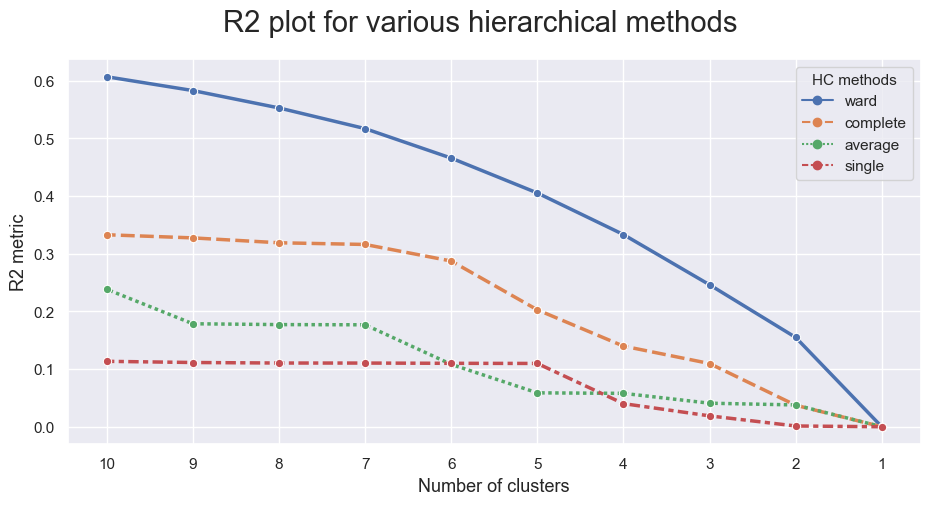

In [58]:
hc_methods = ["ward", "complete", "average", "single"]
# Call function defined above to obtain the R2 statistic for each hc_method
max_nclus = 10
r2_hc_methods = np.vstack(
    [
        get_r2_hc(df=df2, link_method=link, max_nclus=max_nclus) 
        for link in hc_methods
    ]
).T
r2_hc_methods = pd.DataFrame(r2_hc_methods, index=range(1, max_nclus + 1), columns=hc_methods)

sns.set()
# Plot data
fig = plt.figure(figsize=(11,5))
sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)

# Finalize the plot
fig.suptitle("R2 plot for various hierarchical methods", fontsize=21)
plt.gca().invert_xaxis()  # invert x axis
plt.legend(title="HC methods", title_fontsize=11)
plt.xticks(range(1, max_nclus + 1))
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2 metric", fontsize=13)

plt.show()

In [59]:
linkage = 'ward'
distance = 'euclidean'
hclust = AgglomerativeClustering(linkage=linkage, metric=distance, distance_threshold=0, n_clusters=None)
hclust.fit_predict(df2)

array([ 8679, 11687, 13854, ...,     4,     1,     0])

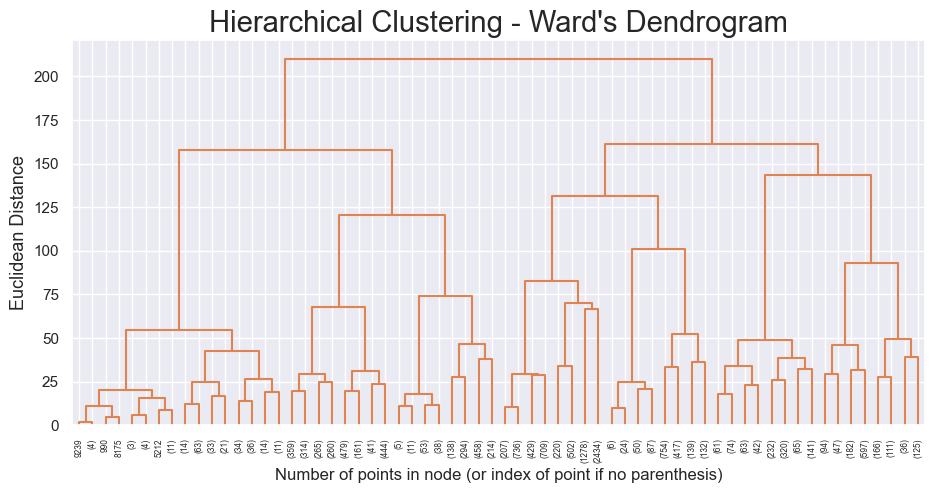

In [60]:
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 500
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

In [61]:
# 4 cluster solution
linkage = 'ward'
distance = 'euclidean'
hc4lust = AgglomerativeClustering(linkage=linkage, metric=distance, n_clusters=4)
hc4_labels = hc4lust.fit_predict(df2)

In [62]:
df_concat = pd.concat((df2, pd.Series(hc4_labels, name='labels', index=df2.index)), axis=1)
df_concat.groupby('labels').mean()

DaysWithoutFrequency  NumberOfFrequencies  AttendedClasses  \
labels                                                               
0                  -0.273670             0.964948        -0.155232   
1                  -0.245188            -0.050228         0.774721   
2                   0.182428            -0.272786        -0.333456   
3                   0.115937             0.477002         1.336749   

        AllowedWeeklyVisits  AllowedNVisits   NVisits  NRenewals  NReferences  \
labels                                                                          
0                  0.404715        0.389015  1.042461   0.482816    -0.124036   
1                 -1.495866       -1.069784 -0.149978   0.086033    -0.126700   
2                  0.563849        0.376998 -0.227022  -0.207894    -0.125155   
3                 -0.983440       -0.788232 -0.324147   0.981629     6.971197   

        DaysSinceLastVisit  NActivities  
labels                                   
0                -0.459957     1.362090  
1                -0.367975    -0.285820  
2                 0.287538    -0.276902  
3                 0.190967     0.200618

In [63]:
# 3 cluster solution
linkage = 'ward'
distance = 'euclidean'
hc3lust = AgglomerativeClustering(linkage=linkage, metric=distance, n_clusters=3)
hc3_labels = hc3lust.fit_predict(df2)

In [64]:
df_concat = pd.concat((df2, pd.Series(hc3_labels, name='labels', index=df2.index)), axis=1)
df_concat.groupby('labels').mean()

DaysWithoutFrequency  NumberOfFrequencies  AttendedClasses  \
labels                                                               
0                  -0.221152            -0.015135         0.812130   
1                  -0.273670             0.964948        -0.155232   
2                   0.182428            -0.272786        -0.333456   

        AllowedWeeklyVisits  AllowedNVisits   NVisits  NRenewals  NReferences  \
labels                                                                          
0                 -1.461759       -1.051044 -0.161571   0.145645     0.345743   
1                  0.404715        0.389015  1.042461   0.482816    -0.124036   
2                  0.563849        0.376998 -0.227022  -0.207894    -0.125155   

        DaysSinceLastVisit  NActivities  
labels                                   
0                -0.330771    -0.253442  
1                -0.459957     1.362090  
2                 0.287538    -0.276902

In [65]:
df_hc4_hc3 = pd.concat((df2,
                        pd.Series(hc4_labels,
                                  name='hc4_labels',
                                  index=df2.index),
                        pd.Series(hc3_labels,
                                  name='hc3_labels',
                                  index=df2.index)
                        ), axis=1)

In [66]:
pd.crosstab(df_hc4_hc3['hc4_labels'],
           df_hc4_hc3['hc3_labels'])

hc3_labels     0     1     2
hc4_labels                  
0              0  2356     0
1           3534     0     0
2              0     0  8124
3            252     0     0

In [67]:
# final cluster solution
linkage = 'ward'
distance = 'euclidean'
hclust = AgglomerativeClustering(linkage=linkage, metric=distance, n_clusters=3)
hc_labels = hclust.fit_predict(df2)

In [68]:
# Characterizing the final clusters
hierarchical_bhv = pd.concat((df2, pd.Series(hc_labels, name='hierarchical/bhv_labels', index=df2.index)), axis=1)
hierarchical_bhv.groupby('hierarchical/bhv_labels').mean()

DaysWithoutFrequency  NumberOfFrequencies  \
hierarchical/bhv_labels                                              
0                                   -0.221152            -0.015135   
1                                   -0.273670             0.964948   
2                                    0.182428            -0.272786   

                         AttendedClasses  AllowedWeeklyVisits  AllowedNVisits  \
hierarchical/bhv_labels                                                         
0                               0.812130            -1.461759       -1.051044   
1                              -0.155232             0.404715        0.389015   
2                              -0.333456             0.563849        0.376998   

                          NVisits  NRenewals  NReferences  DaysSinceLastVisit  \
hierarchical/bhv_labels                                                         
0                       -0.161571   0.145645     0.345743           -0.330771   
1                        1.042461   0.482816    -0.124036           -0.459957   
2                       -0.227022  -0.207894    -0.125155            0.287538   

                         NActivities  
hierarchical/bhv_labels               
0                          -0.253442  
1                           1.362090  
2                          -0.276902

In [69]:
cluster_means = hierarchical_bhv.groupby('hierarchical/bhv_labels').mean().T
cluster_means.style.format(precision=2).background_gradient(axis=1)

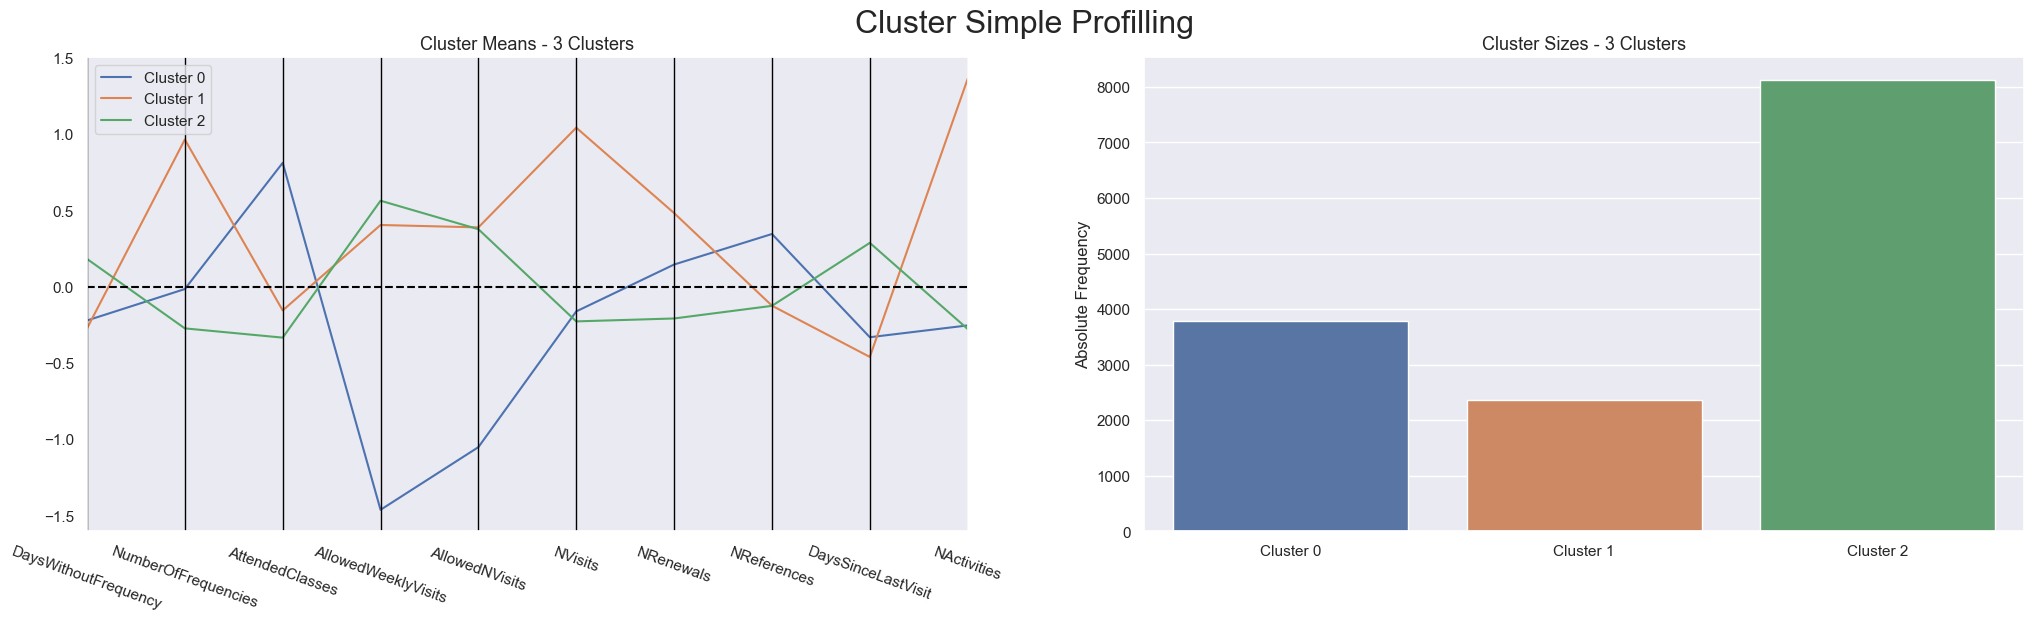

In [70]:
cluster_profiles(hierarchical_bhv, ['hierarchical/bhv_labels'], (25,6))

In [71]:
hierarchical_silhouette_score = silhouette_score(hierarchical_bhv, hclust.labels_)
hierarchical_silhouette_score

0.31219673223811867

In [72]:
hierarchical_db_index = davies_bouldin_score(hierarchical_bhv, hclust.labels_)
hierarchical_db_index

1.7920668135777518

# K-means

### Demografic + value perspective

In [73]:
df3 = df_dem.copy()

In [74]:
range_clusters = range(1, 5)
inertia = []
for n_clus in range_clusters:  # iterate over desired ncluster range
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
    kmclust.fit(df3)
    inertia.append(kmclust.inertia_) 

findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=15.0.
findfont: score(FontEntry(fname='/Users/catarinasilva/anaconda3/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-BoldItalic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='/Users/catarinasilva/anaconda3/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmb10.ttf', name='cmb10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/Users/catarinasilva/anaconda3/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-Oblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/Users/catarinasilva/anaconda3/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSiz

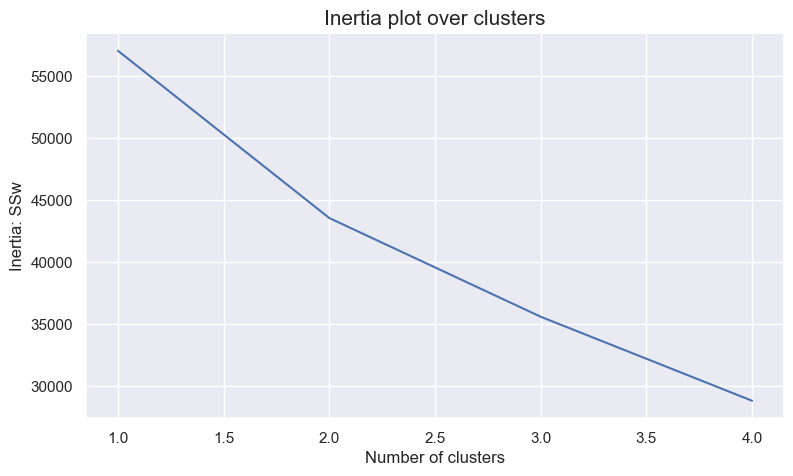

In [75]:
plt.figure(figsize=(9,5))
plt.plot(range_clusters, inertia)
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters", size=15)
plt.show()

For n_clusters = 2, the average silhouette_score is : 0.3922331577746588
For n_clusters = 3, the average silhouette_score is : 0.3951607698363475
For n_clusters = 4, the average silhouette_score is : 0.3527961393162652


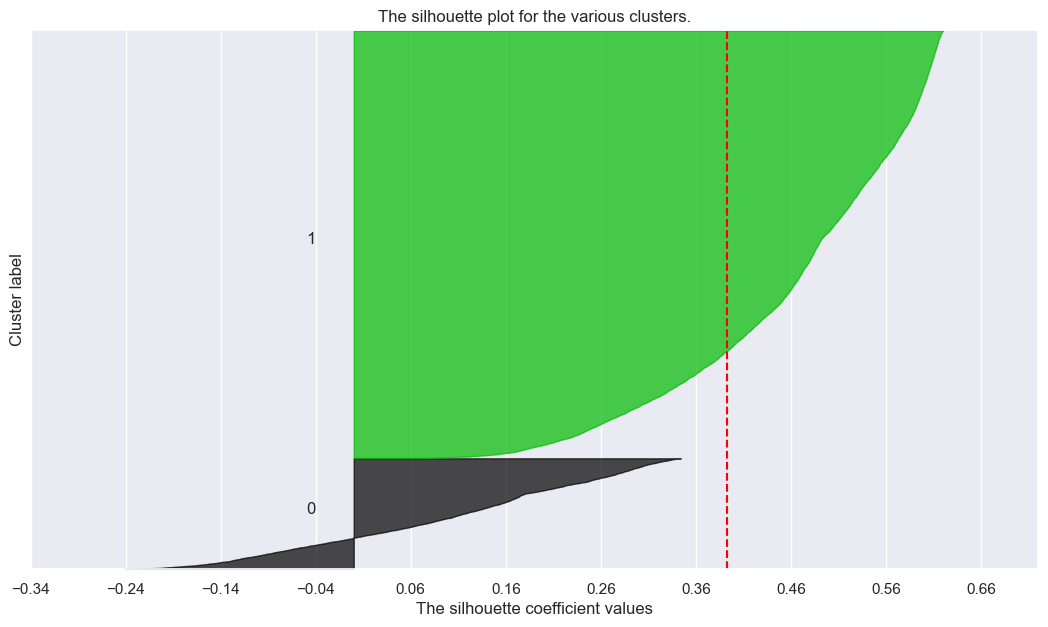

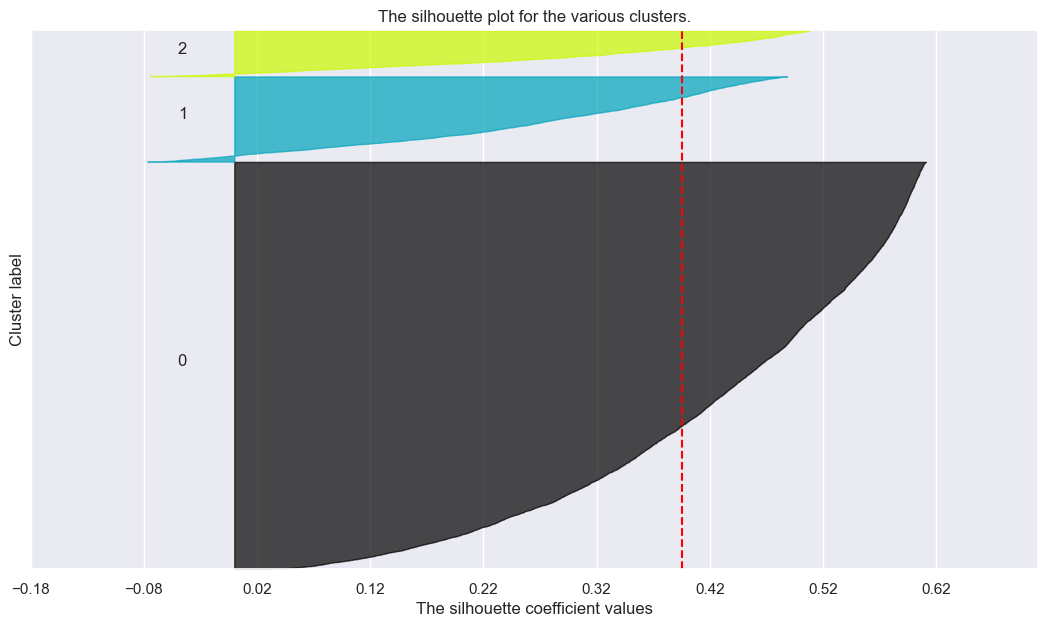

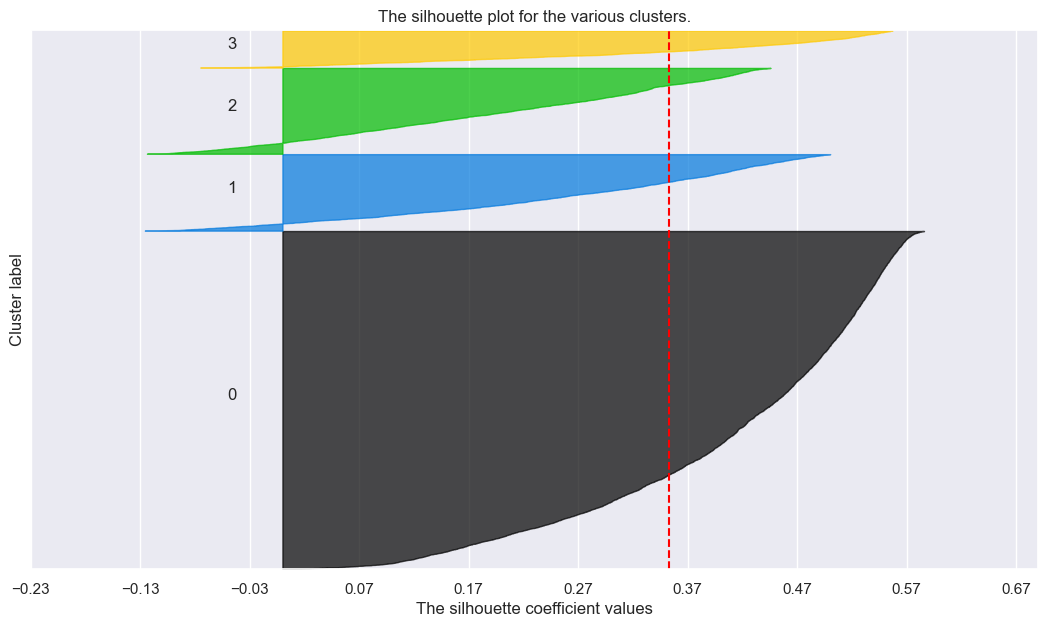

In [76]:
avg_silhouette = []
for nclus in range_clusters:
    # Skip nclus == 1
    if nclus == 1:
        continue
    
    # Create a figure
    fig = plt.figure(figsize=(13, 7))

    # Initialize the KMeans object with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=15, random_state=1)
    cluster_labels = kmclust.fit_predict(df3)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(df3, cluster_labels)
    avg_silhouette.append(silhouette_avg)
    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df3, cluster_labels)

    y_lower = 10
    for i in range(nclus):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        # Get y_upper to demarcate silhouette y range size
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        # Filling the silhouette
        color = cm.nipy_spectral(float(i) / nclus)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    # The silhouette coefficient can range from -1, 1
    xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
    plt.xlim([xmin, xmax])
    
    # The (nclus+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    plt.ylim([0, len(df3) + (nclus + 1) * 10])

    plt.yticks([])  # Clear the yaxis labels / ticks
    plt.xticks(np.arange(xmin, xmax, 0.1))

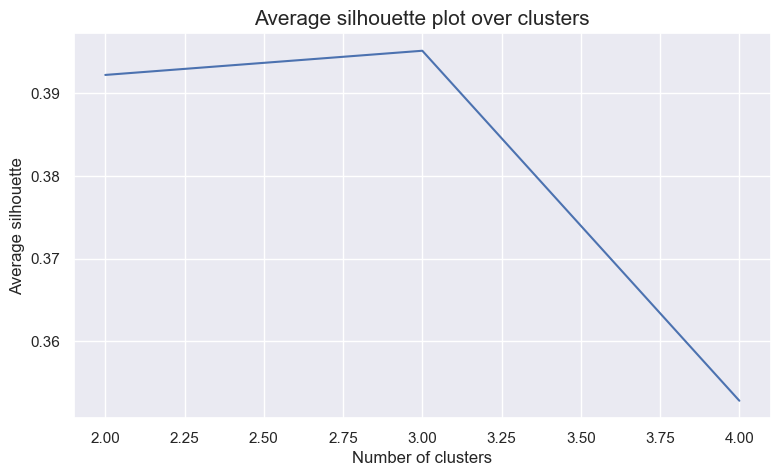

In [77]:
plt.figure(figsize=(9,5))
plt.plot(range_clusters[1:], ## Plot X-axis; Why range_clusters[1:] ? Remember we skipped k=1 in the cell above
         avg_silhouette)     ## Plot Y-axis

plt.ylabel("Average silhouette")
plt.xlabel("Number of clusters")
plt.title("Average silhouette plot over clusters", size=15)
plt.show()

In [78]:
number_clusters = 2
kmclust = KMeans(n_clusters=number_clusters, init='k-means++', n_init=15, random_state=1)
km_labels = kmclust.fit_predict(df3)
km_labels

array([1, 1, 1, ..., 1, 0, 0], dtype=int32)

In [79]:
kmeans_dem = pd.concat((df3, pd.Series(km_labels, name='kmeans/dem_labels', index=df3.index)), axis=1)
kmeans_dem.groupby('kmeans/dem_labels').mean()

Age  AvgLifeTimeValue  LifetimeValue  EnrollmentTime
kmeans/dem_labels                                                           
0                 -0.030214          -0.37237       1.393452        1.253507
1                  0.007819           0.09637      -0.360628       -0.324410

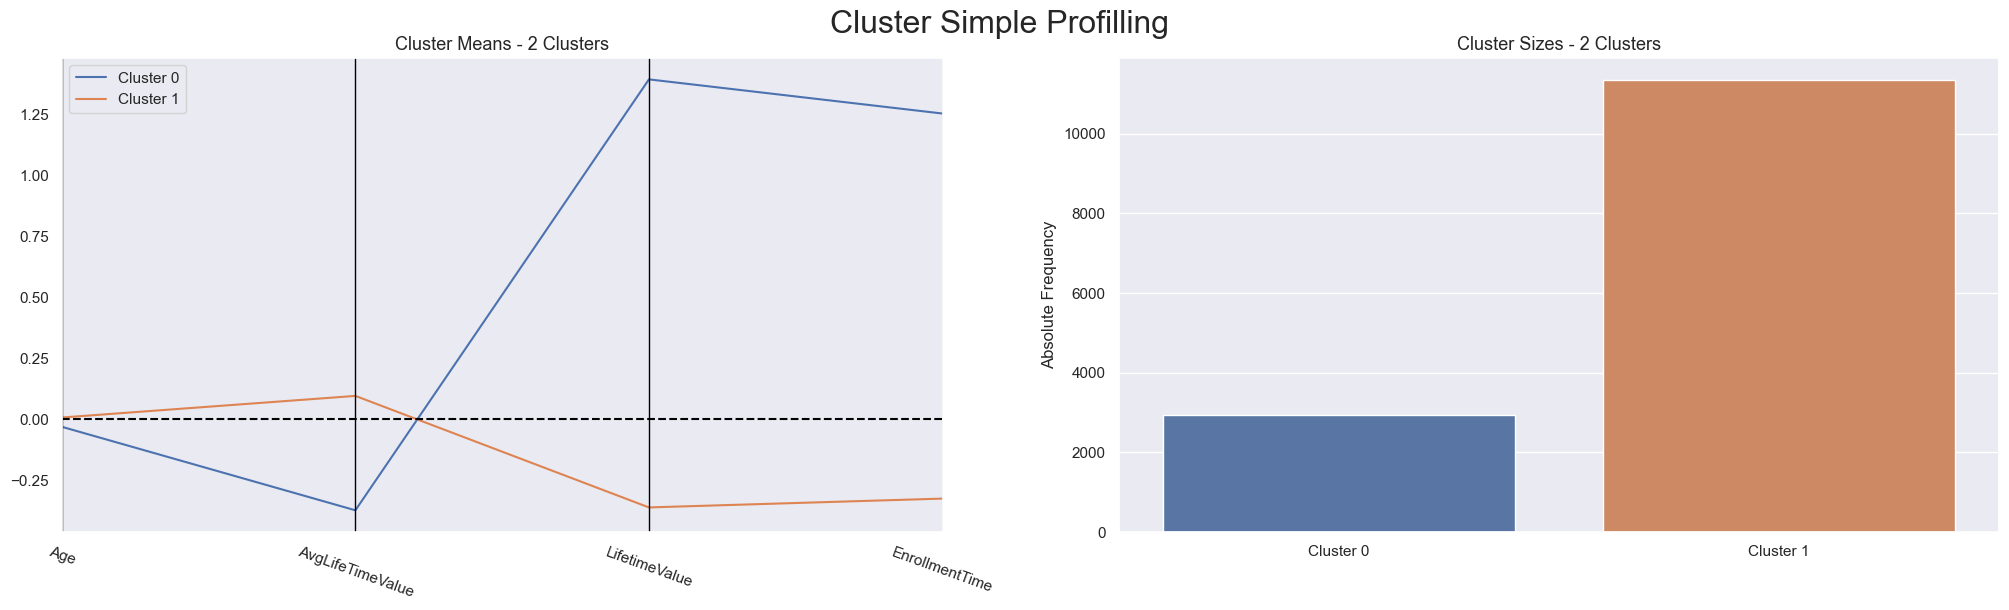

In [80]:
cluster_profiles(kmeans_dem, ['kmeans/dem_labels'], (25,6))

In [81]:
kmeans_dem.groupby('kmeans/dem_labels').mean()

Age  AvgLifeTimeValue  LifetimeValue  EnrollmentTime
kmeans/dem_labels                                                           
0                 -0.030214          -0.37237       1.393452        1.253507
1                  0.007819           0.09637      -0.360628       -0.324410

In [82]:
kmeans_silhouette_score = silhouette_score(kmeans_dem, km_labels)
round(kmeans_silhouette_score,3)

0.42

In [83]:
kmeans_db_index = davies_bouldin_score(kmeans_dem, km_labels)
round(kmeans_db_index,3)

1.346

### Behavior perspective

In [84]:
df4 = df_bhv.copy()

In [85]:
range_clusters = range(1, 11)
inertia = []
for n_clus in range_clusters:  # iterate over desired ncluster range
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
    kmclust.fit(df4)
    inertia.append(kmclust.inertia_)

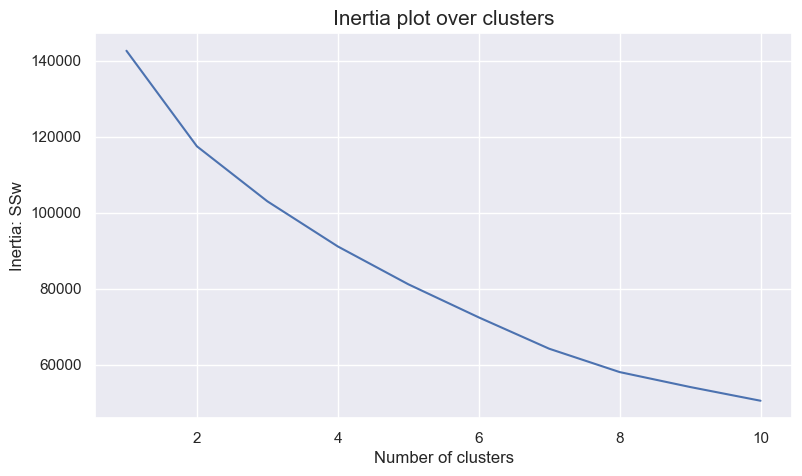

In [86]:
plt.figure(figsize=(9,5))
plt.plot(range_clusters, inertia)
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters", size=15)
plt.show()

For n_clusters = 2, the average silhouette_score is : 0.28532156000572045
For n_clusters = 3, the average silhouette_score is : 0.27440658792175465
For n_clusters = 4, the average silhouette_score is : 0.2955051271509946
For n_clusters = 5, the average silhouette_score is : 0.31430292425034206
For n_clusters = 6, the average silhouette_score is : 0.3054914766294343
For n_clusters = 7, the average silhouette_score is : 0.32064455286787835
For n_clusters = 8, the average silhouette_score is : 0.242998475969826
For n_clusters = 9, the average silhouette_score is : 0.2491270642445813
For n_clusters = 10, the average silhouette_score is : 0.2629317145020264


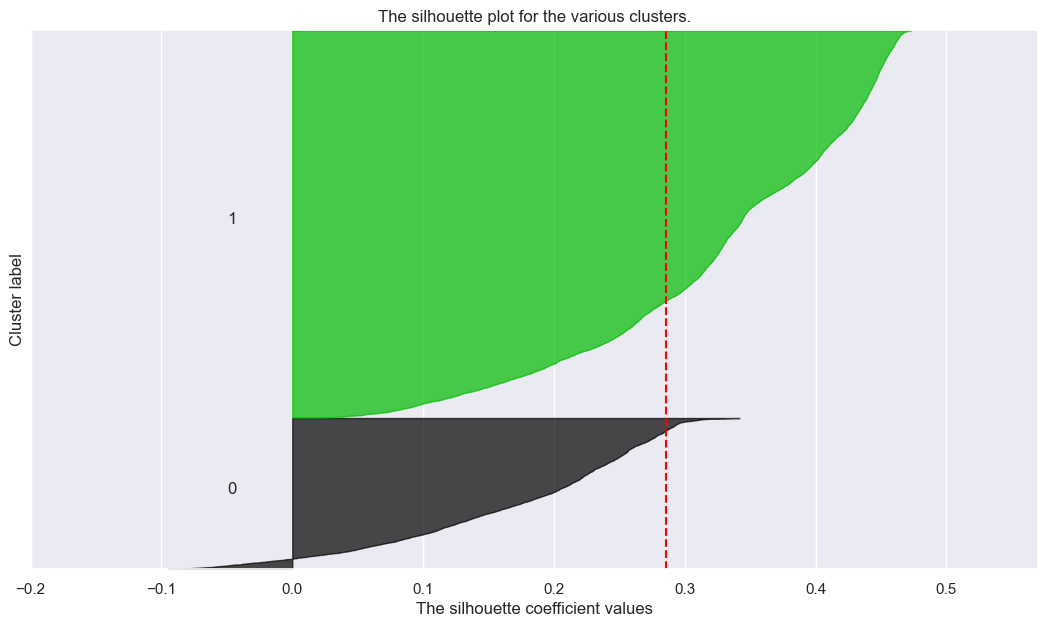

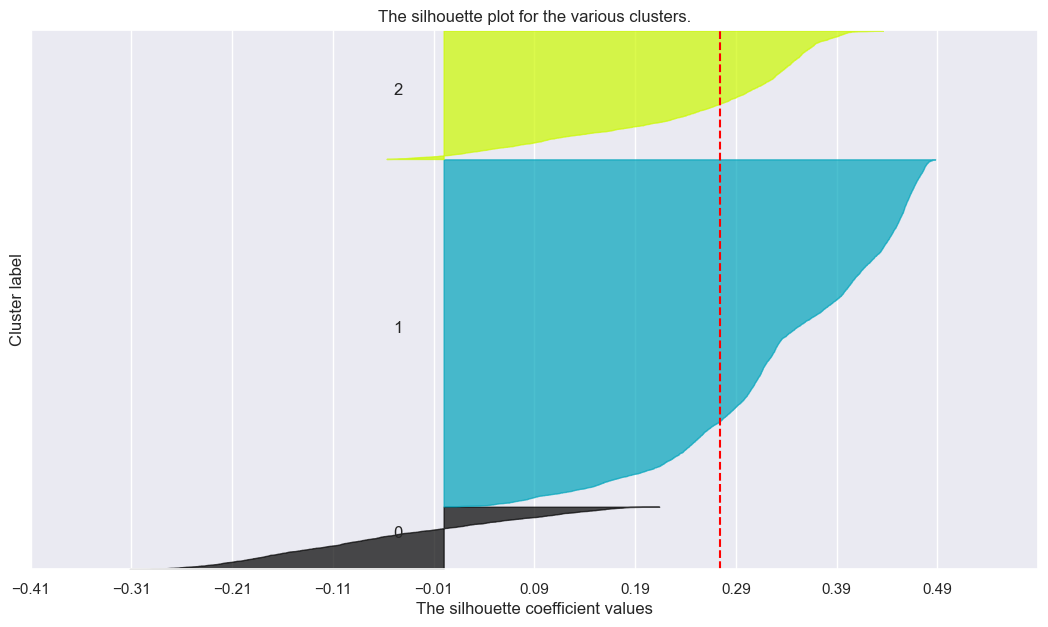

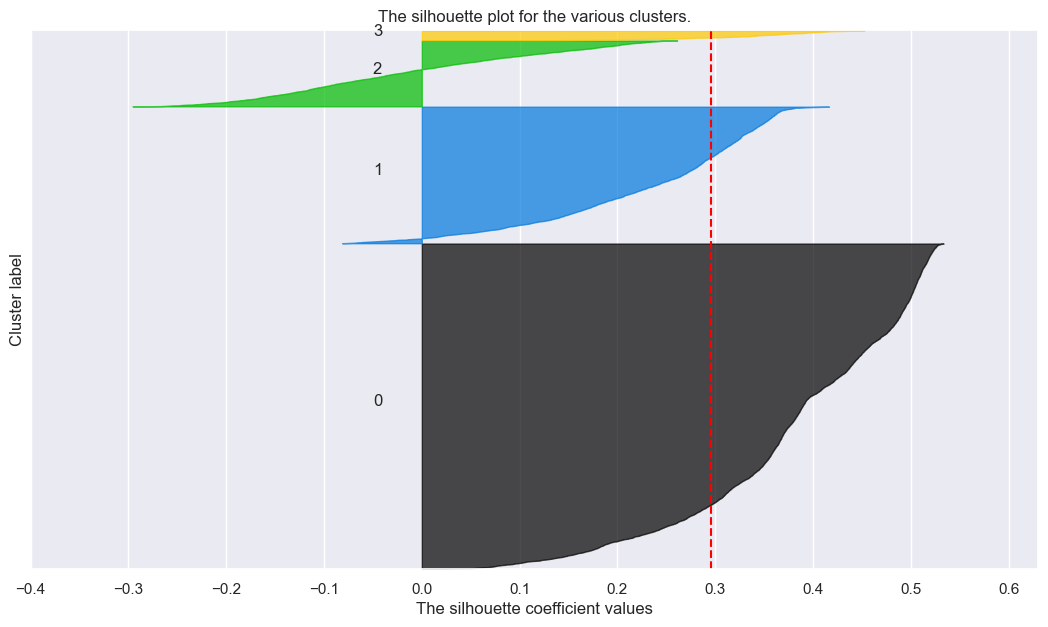

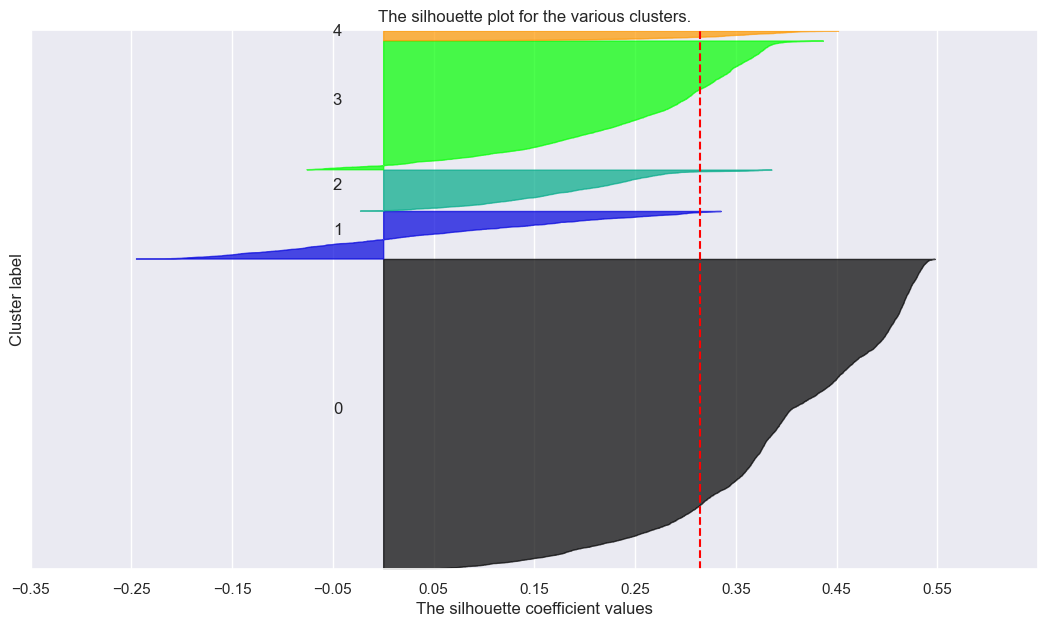

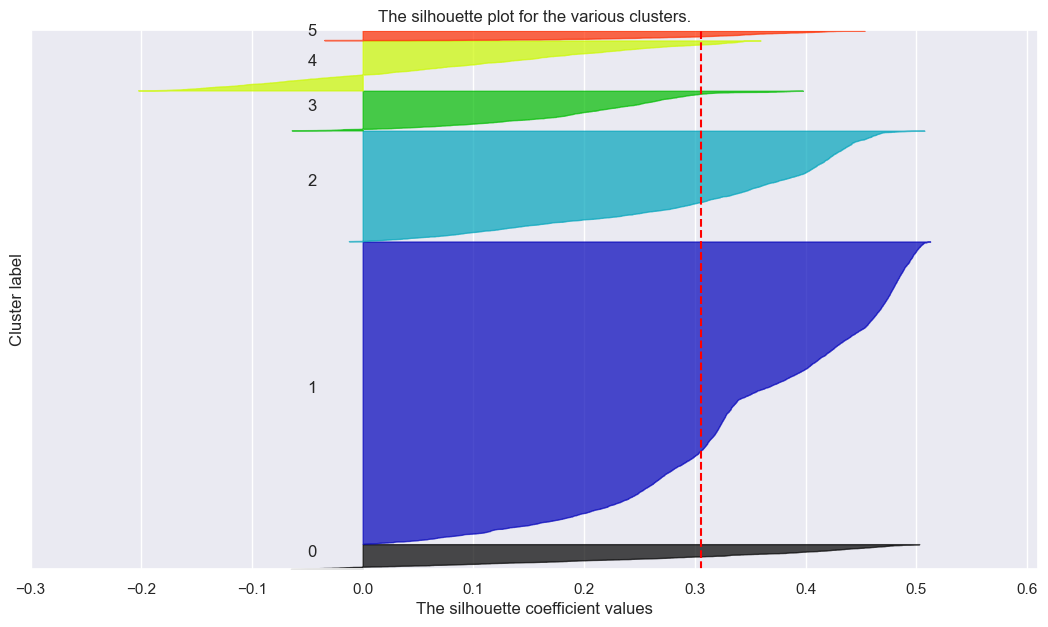

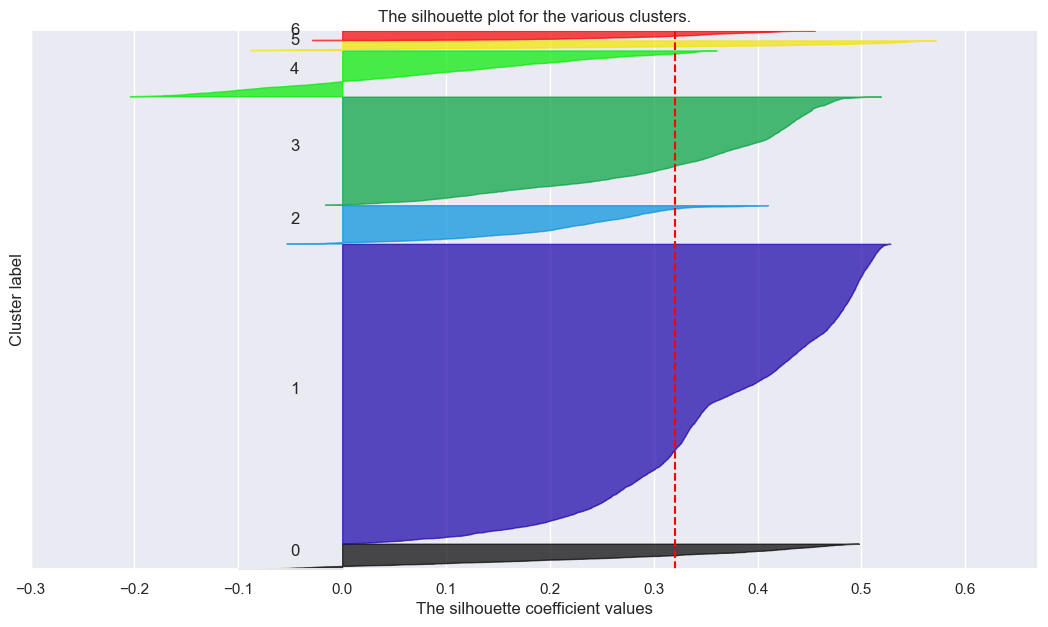

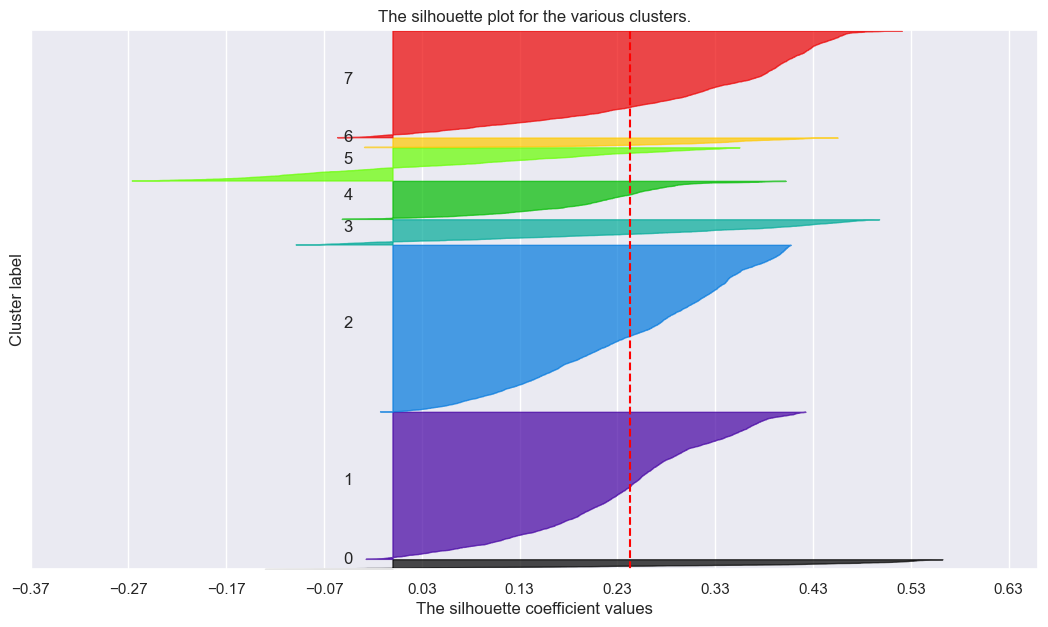

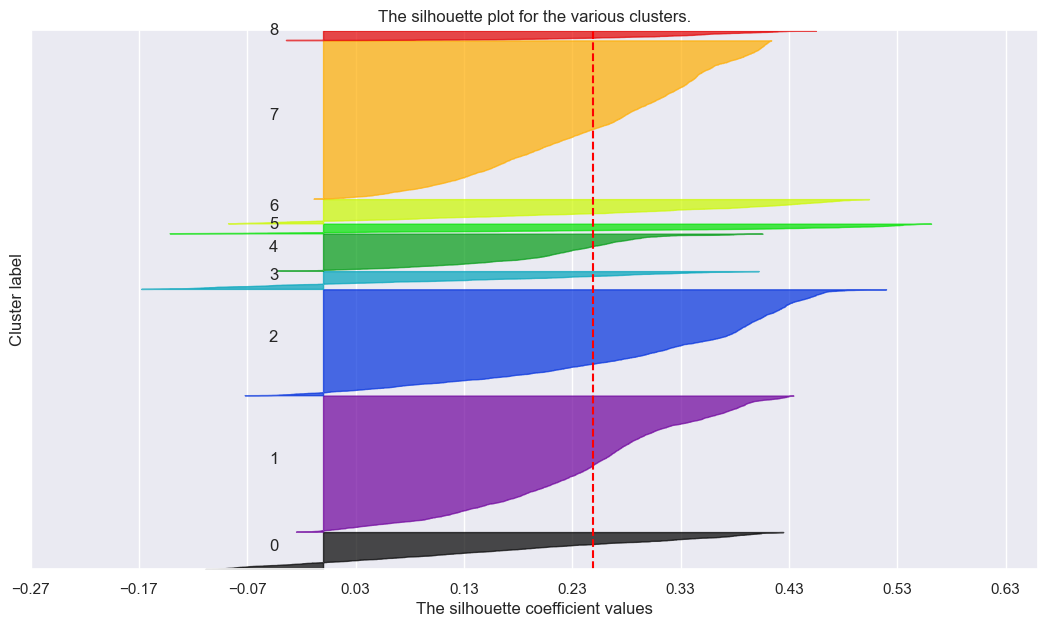

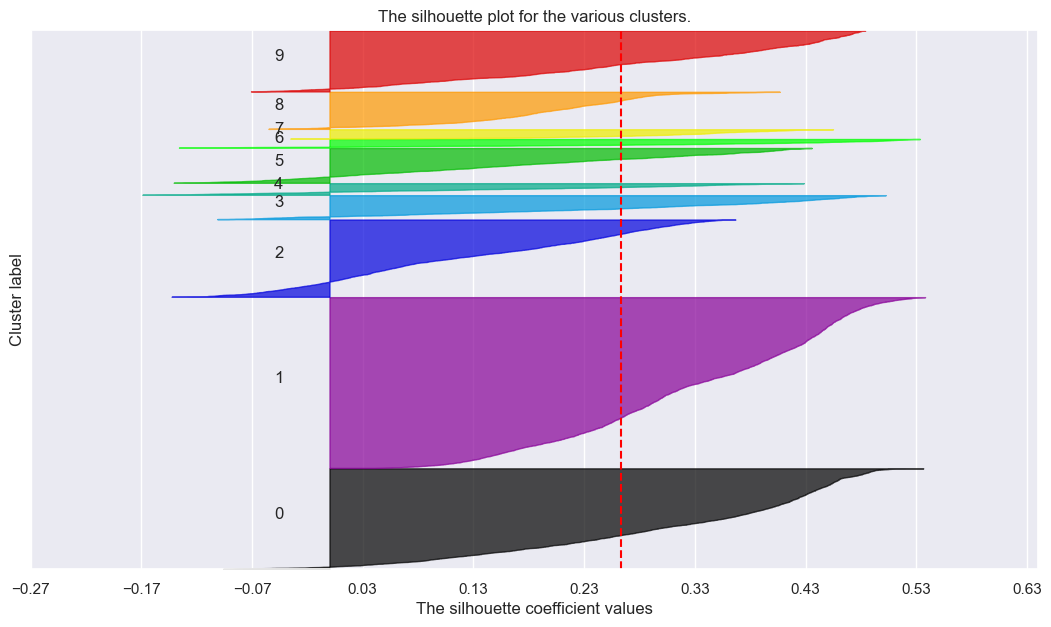

In [87]:
avg_silhouette = []
for nclus in range_clusters:
    # Skip nclus == 1
    if nclus == 1:
        continue
    
    # Create a figure
    fig = plt.figure(figsize=(13, 7))

    # Initialize the KMeans object with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=15, random_state=1)
    cluster_labels = kmclust.fit_predict(df4)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(df4, cluster_labels)
    avg_silhouette.append(silhouette_avg)
    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df4, cluster_labels)

    y_lower = 10
    for i in range(nclus):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        # Get y_upper to demarcate silhouette y range size
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        # Filling the silhouette
        color = cm.nipy_spectral(float(i) / nclus)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    # The silhouette coefficient can range from -1, 1
    xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
    plt.xlim([xmin, xmax])
    
    # The (nclus+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    plt.ylim([0, len(df4) + (nclus + 1) * 10])

    plt.yticks([])  # Clear the yaxis labels / ticks
    plt.xticks(np.arange(xmin, xmax, 0.1))

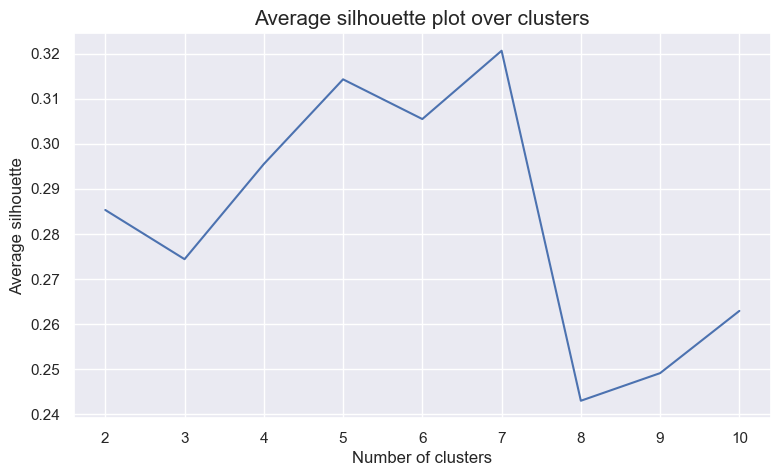

In [88]:
plt.figure(figsize=(9,5))
plt.plot(range_clusters[1:], ## Plot X-axis; Why range_clusters[1:] ? Remember we skipped k=1 in the cell above
         avg_silhouette)     ## Plot Y-axis

plt.ylabel("Average silhouette")
plt.xlabel("Number of clusters")
plt.title("Average silhouette plot over clusters", size=15)
plt.show()

In [89]:
number_clusters = 2
kmclust = KMeans(n_clusters=number_clusters, init='k-means++', n_init=15, random_state=1)
km_labels = kmclust.fit_predict(df4)
km_labels

array([0, 0, 1, ..., 1, 0, 1], dtype=int32)

In [90]:
kmeans_bhv = pd.concat((df4, pd.Series(km_labels, name='kmeans/bhv_labels', index=df4.index)), axis=1)
kmeans_bhv.groupby('kmeans/bhv_labels').mean()

DaysWithoutFrequency  NumberOfFrequencies  AttendedClasses  \
kmeans/bhv_labels                                                               
0                             -0.085910             0.001528         0.835645   
1                              0.033497            -0.000596        -0.325823   

                   AllowedWeeklyVisits  AllowedNVisits   NVisits  NRenewals  \
kmeans/bhv_labels                                                             
0                            -1.509487       -1.124775 -0.183823   0.253266   
1                             0.588559        0.438557  0.071674  -0.098750   

                   NReferences  DaysSinceLastVisit  NActivities  
kmeans/bhv_labels                                                
0                     0.246538           -0.342463    -0.024776  
1                    -0.096127            0.133529     0.009660

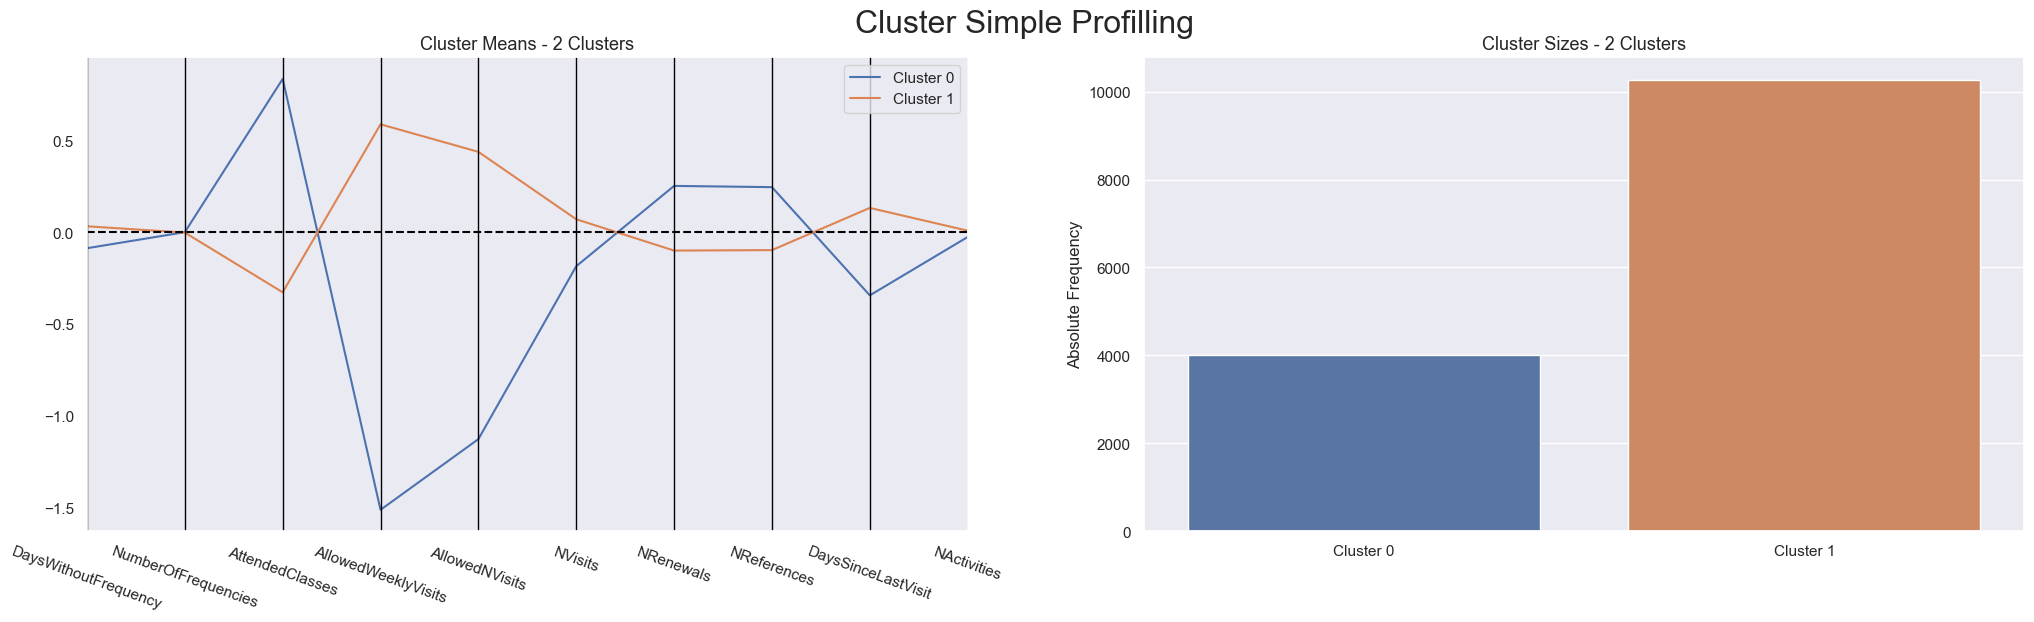

In [91]:
cluster_profiles(kmeans_bhv, ['kmeans/bhv_labels'], (25,6))

In [92]:
kmeans_bhv.groupby('kmeans/bhv_labels').mean()

DaysWithoutFrequency  NumberOfFrequencies  AttendedClasses  \
kmeans/bhv_labels                                                               
0                             -0.085910             0.001528         0.835645   
1                              0.033497            -0.000596        -0.325823   

                   AllowedWeeklyVisits  AllowedNVisits   NVisits  NRenewals  \
kmeans/bhv_labels                                                             
0                            -1.509487       -1.124775 -0.183823   0.253266   
1                             0.588559        0.438557  0.071674  -0.098750   

                   NReferences  DaysSinceLastVisit  NActivities  
kmeans/bhv_labels                                                
0                     0.246538           -0.342463    -0.024776  
1                    -0.096127            0.133529     0.009660

In [93]:
kmeans_silhouette_score = silhouette_score(kmeans_bhv,km_labels)
round(kmeans_silhouette_score,3)

0.303

In [94]:
kmeans_db_index = davies_bouldin_score(kmeans_bhv, km_labels)
round(kmeans_db_index,3)

1.623

# SOM + K-MEANS

In [95]:
df6 = df_dem.copy()

In [96]:
np.random.seed(80)

sm = sompy.SOMFactory().build(
    df6.values, # Input data (numeric features)
    mapsize=[10, 10],           # Size of the SOM grid (10x10 in this case)
    initialization='random',    # Initialization method for weights ('random' in this case)
    neighborhood='gaussian',    # Type of neighborhood function ('gaussian' in this case)
    training='batch',           # Training method ('batch' in this case)
    lattice='hexa',             # Type of lattice ('hexa' in this case)
    component_names=dem_value_features
)
sm.train(n_job=1, verbose='info', train_rough_len=120, train_finetune_len=120)

 Training...
 random_initialization took: 0.000000 seconds
 Rough training...
 radius_ini: 4.000000 , radius_final: 1.000000, trainlen: 120

 epoch: 1 ---> elapsed time:  0.062000, quantization error: 1.452004

 epoch: 2 ---> elapsed time:  0.063000, quantization error: 1.665836

 epoch: 3 ---> elapsed time:  0.054000, quantization error: 1.612565

 epoch: 4 ---> elapsed time:  0.059000, quantization error: 1.586234

 epoch: 5 ---> elapsed time:  0.066000, quantization error: 1.570605

 epoch: 6 ---> elapsed time:  0.072000, quantization error: 1.559142

 epoch: 7 ---> elapsed time:  0.068000, quantization error: 1.553930

 epoch: 8 ---> elapsed time:  0.067000, quantization error: 1.550028

 epoch: 9 ---> elapsed time:  0.068000, quantization error: 1.546792

 epoch: 10 ---> elapsed time:  0.065000, quantization error: 1.542737

 epoch: 11 ---> elapsed time:  0.052000, quantization error: 1.538507

 epoch: 12 ---> elapsed time:  0.063000, quantization error: 1.535756

 epoch: 13 ---> 

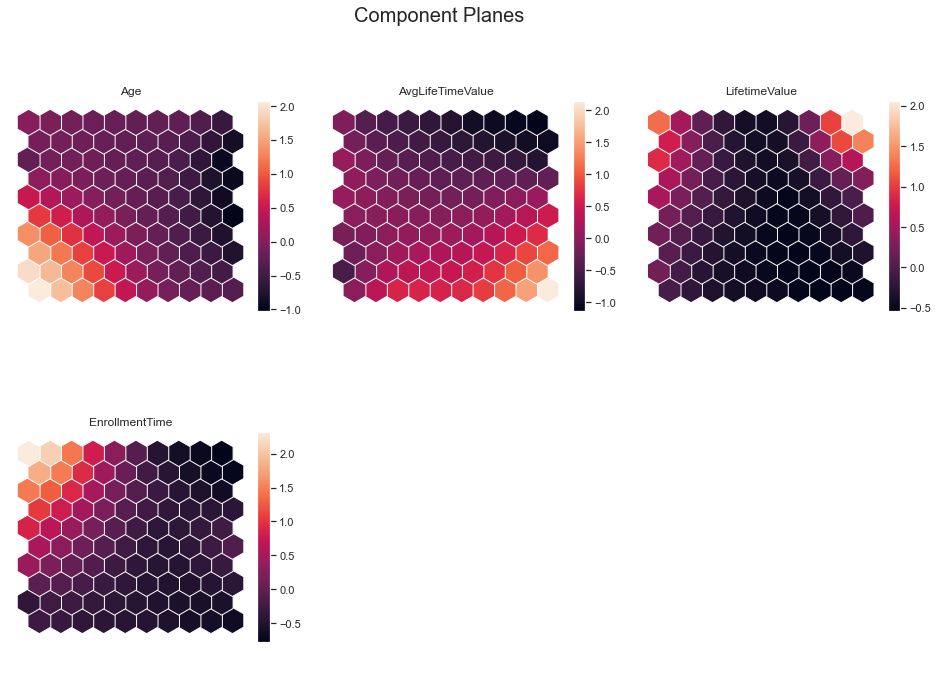

In [97]:
plt.rcParams['figure.dpi'] = 72


# Visualizing the Component planes (feature values)
sns.set()
view2D = View2D(12, 12, "", text_size=10)
view2D.show(sm, col_sz=3, what='codebook')
plt.subplots_adjust(top=0.90)
plt.suptitle("Component Planes", fontsize=20)
plt.show()

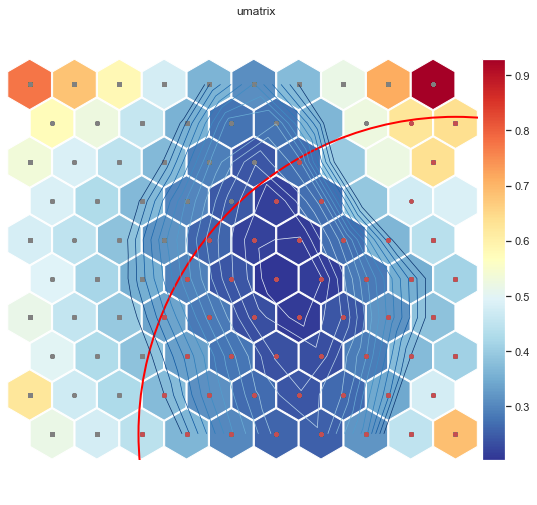

array([[0.77597869, 0.68254363, 0.58123956, 0.47812963, 0.36044932,
        0.30964691, 0.37149573, 0.51606872, 0.71283602, 0.93046092],
       [0.57353876, 0.52579297, 0.45695814, 0.35715065, 0.27619138,
        0.27568854, 0.36200018, 0.52415176, 0.62362127, 0.63969283],
       [0.53383673, 0.48441019, 0.4457628 , 0.36901632, 0.28853819,
        0.24070515, 0.2687973 , 0.39776948, 0.52176377, 0.63686625],
       [0.48531943, 0.4294299 , 0.36807059, 0.29780587, 0.24400076,
        0.2165895 , 0.26827156, 0.39127059, 0.47407313, 0.4848571 ],
       [0.48120641, 0.44924932, 0.3844317 , 0.31479126, 0.25940389,
        0.21830005, 0.21086079, 0.26932281, 0.36479434, 0.43957128],
       [0.4952564 , 0.41636253, 0.35170084, 0.29206   , 0.24033744,
        0.20280484, 0.2130588 , 0.2847054 , 0.35061607, 0.41289783],
       [0.51404664, 0.45445842, 0.39334791, 0.33805449, 0.28345033,
        0.23357275, 0.20974451, 0.24022903, 0.31423956, 0.38308284],
       [0.49945974, 0.42766836, 0.3831435

In [98]:
u = sompy.umatrix.UMatrixView(9, 9, 'umatrix', show_axis=True, text_size=8, show_text=True)

UMAT = u.show(
    sm, 
    distance=2,
    row_normalized=False,
    show_data=True, 
    contour=True, # Visualize isomorphic curves
    blob=True
)

np.flip(UMAT[1], axis=1)

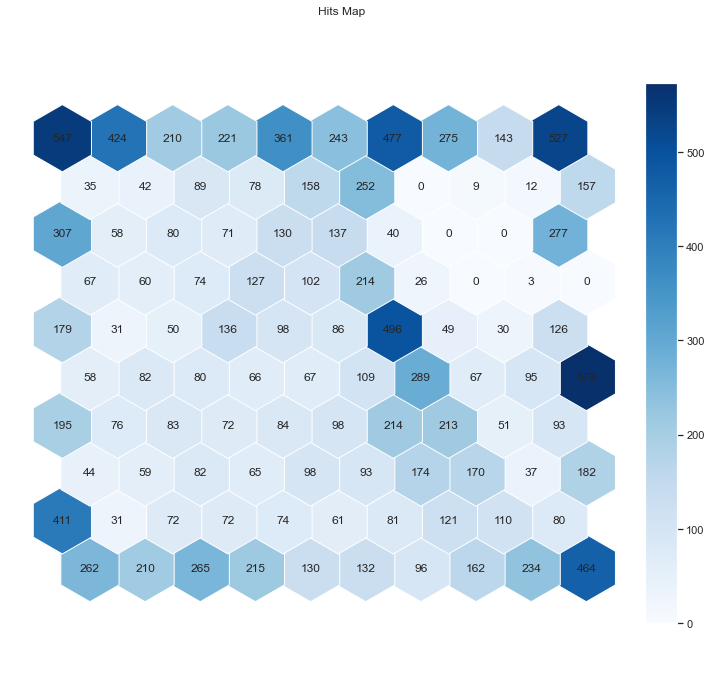

In [99]:
vhts  = BmuHitsView(12,12,"Hits Map")
vhts.show(sm, anotate=True, onlyzeros=False, labelsize=12, cmap="Blues")
plt.show()

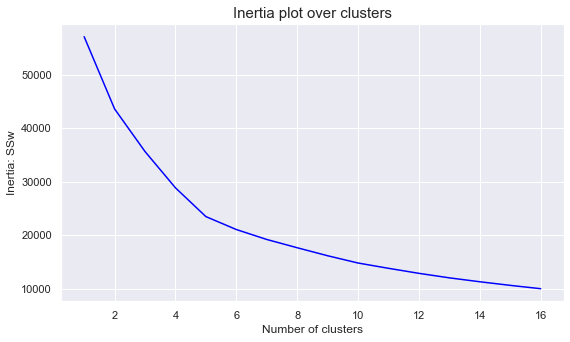

In [100]:
inertia = []
for n_clus in range(1,17): 
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=20, random_state=80)
    kmclust.fit(df6)
    inertia.append(kmclust.inertia_)
    

plt.figure(figsize=(9,5))
plt.plot(range(1,17),inertia,color = 'blue')
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters", size=15)
plt.show()

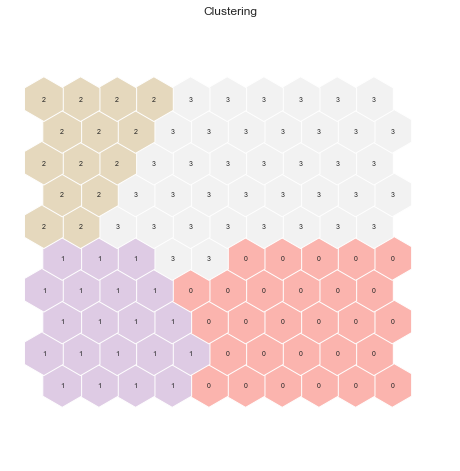

In [101]:
kmeans = KMeans(n_clusters=4,init='k-means++', n_init=20, random_state=80)

# Fit K-Means on the codebook matrix of the SOM
nodeclus_labels = kmeans.fit_predict(sm.codebook.matrix)

sm.cluster_labels = nodeclus_labels  # setting the cluster labels of sompy

# Create a HitMapView for visualization
hits = HitMapView(8,8,"Clustering", text_size=10)
hits.show(sm, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")

plt.show()

In [102]:
# Extract the codebook matrix from the SOM
nodes = sm.codebook.matrix

# Create a DataFrame with the codebook matrix values
df_somk = pd.DataFrame(nodes, columns=dem_value_features)

# Add a column for the K-Means cluster labels
df_somk['som_kmeans_dem_labels'] = nodeclus_labels
df_somk

Age  AvgLifeTimeValue  LifetimeValue  EnrollmentTime  \
0  -0.574415         -1.133197       2.061111       -0.779164   
1  -0.380187         -1.070197       1.039179       -0.706381   
2  -0.259719         -1.025891       0.198020       -0.614186   
3  -0.246055         -0.972160      -0.267306       -0.469837   
4  -0.226071         -0.820007      -0.413260       -0.088039   
..       ...               ...            ...             ...   
95  0.452563          0.597394      -0.434089       -0.445229   
96  0.837437          0.620609      -0.400099       -0.425871   
97  1.280911          0.618897      -0.341368       -0.398444   
98  1.707528          0.368862      -0.224141       -0.338256   
99  2.074519          0.013164      -0.059099       -0.284639   

    som_kmeans_dem_labels  
0                       3  
1                       3  
2                       3  
3                       3  
4                       3  
..                    ...  
95                      0  
96                      1  
97                      1  
98                      1  
99                      1  

[100 rows x 5 columns]

In [103]:
bmus_map = sm.find_bmu(df6.values)[0]  #get bmus for each observation in df
df_bmus = pd.DataFrame(
    np.concatenate((df6, np.expand_dims(bmus_map,1)), axis=1),
    index=df6.index, columns=np.append(df6.columns,"BMU")
)
df_bmus

Age  AvgLifeTimeValue  LifetimeValue  EnrollmentTime   BMU
ID                                                                    
10000  2.452289          1.428476      -0.602086       -0.683551  98.0
10001  0.223473          0.843253       0.579351        0.343892  49.0
10002 -0.207910          0.929021      -0.758914       -0.768164  92.0
10003 -1.214473          0.438429      -0.401922       -0.375318  50.0
10005 -0.136013         -0.248762      -0.448591       -0.124501  35.0
...         ...               ...            ...             ...   ...
24937 -0.854986         -1.250769       3.553019       -0.858821   0.0
24938  0.942446          1.040472       0.169174       -0.070107  96.0
24939 -0.423602          1.276858      -0.740731       -0.768164  80.0
24940  2.092803         -1.250769       1.516984       -0.858821  89.0
24941  0.439165          0.120897       1.913979        2.664704   9.0

[14266 rows x 5 columns]

In [104]:
df_somk_dem = df_bmus.merge(df_somk['som_kmeans_dem_labels'], 'left', left_on="BMU", right_index=True)

df_somk_dem.drop('BMU', axis=1, inplace=True)

In [105]:
df_somk_dem.groupby('som_kmeans_dem_labels').mean()

Age  AvgLifeTimeValue  LifetimeValue  \
som_kmeans_dem_labels                                              
0                     -0.406741          0.879548      -0.436626   
1                      1.547123          0.108675      -0.125011   
2                     -0.073172         -0.164411       0.757345   
3                     -0.383514         -0.721586       0.081629   

                       EnrollmentTime  
som_kmeans_dem_labels                  
0                           -0.464997  
1                           -0.212885  
2                            1.854305  
3                           -0.356896

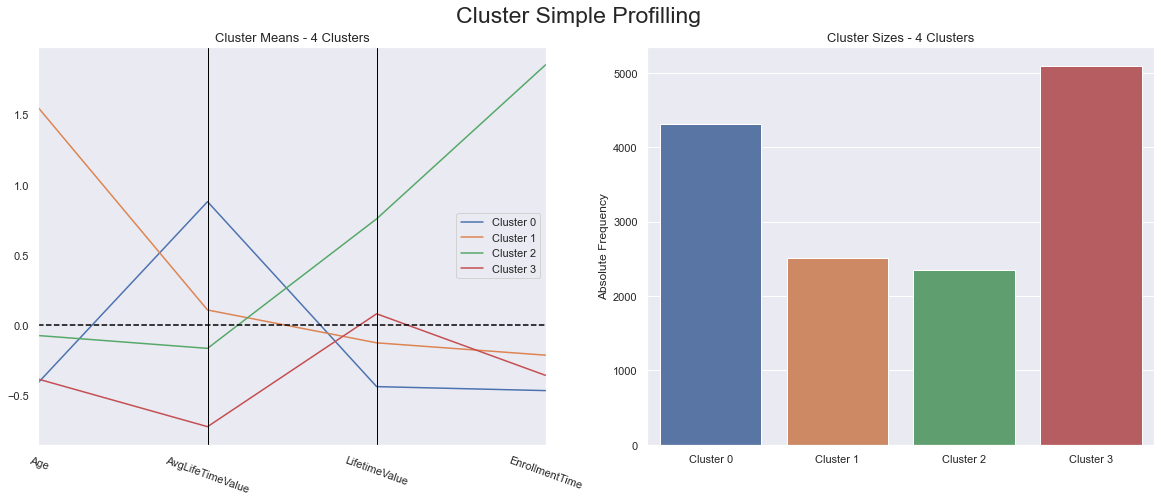

In [106]:
cluster_profiles(df_somk_dem, ['som_kmeans_dem_labels'], (20,7))

In [107]:
def get_ss(df):
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

sst = get_ss(df_somk_dem)  # get total sum of squares
ssw_labels = df_somk_dem.groupby(by='som_kmeans_dem_labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
r2

0.6032716292789935

### Behavior perpective

In [108]:
df7 = df_bhv.copy()

In [109]:
np.random.seed(80)

sm = sompy.SOMFactory().build(
    df7.values, # Input data (numeric features)
    mapsize=[10, 10],           # Size of the SOM grid (10x10 in this case)
    initialization='random',    # Initialization method for weights ('random' in this case)
    neighborhood='gaussian',    # Type of neighborhood function ('gaussian' in this case)
    training='batch',           # Training method ('batch' in this case)
    lattice='hexa',             # Type of lattice ('hexa' in this case)
    component_names=behavior_features
)
sm.train(n_job=1, verbose='info', train_rough_len=120, train_finetune_len=120)

 Training...
 random_initialization took: 0.000000 seconds
 Rough training...
 radius_ini: 4.000000 , radius_final: 1.000000, trainlen: 120

 epoch: 1 ---> elapsed time:  0.042000, quantization error: 5.060262

 epoch: 2 ---> elapsed time:  0.079000, quantization error: 2.745068

 epoch: 3 ---> elapsed time:  0.079000, quantization error: 2.667011

 epoch: 4 ---> elapsed time:  0.070000, quantization error: 2.622669

 epoch: 5 ---> elapsed time:  0.069000, quantization error: 2.604855

 epoch: 6 ---> elapsed time:  0.065000, quantization error: 2.595620

 epoch: 7 ---> elapsed time:  0.065000, quantization error: 2.590580

 epoch: 8 ---> elapsed time:  0.063000, quantization error: 2.586812

 epoch: 9 ---> elapsed time:  0.065000, quantization error: 2.583375

 epoch: 10 ---> elapsed time:  0.076000, quantization error: 2.580464

 epoch: 11 ---> elapsed time:  0.056000, quantization error: 2.577782

 epoch: 12 ---> elapsed time:  0.059000, quantization error: 2.574972

 epoch: 13 ---> 

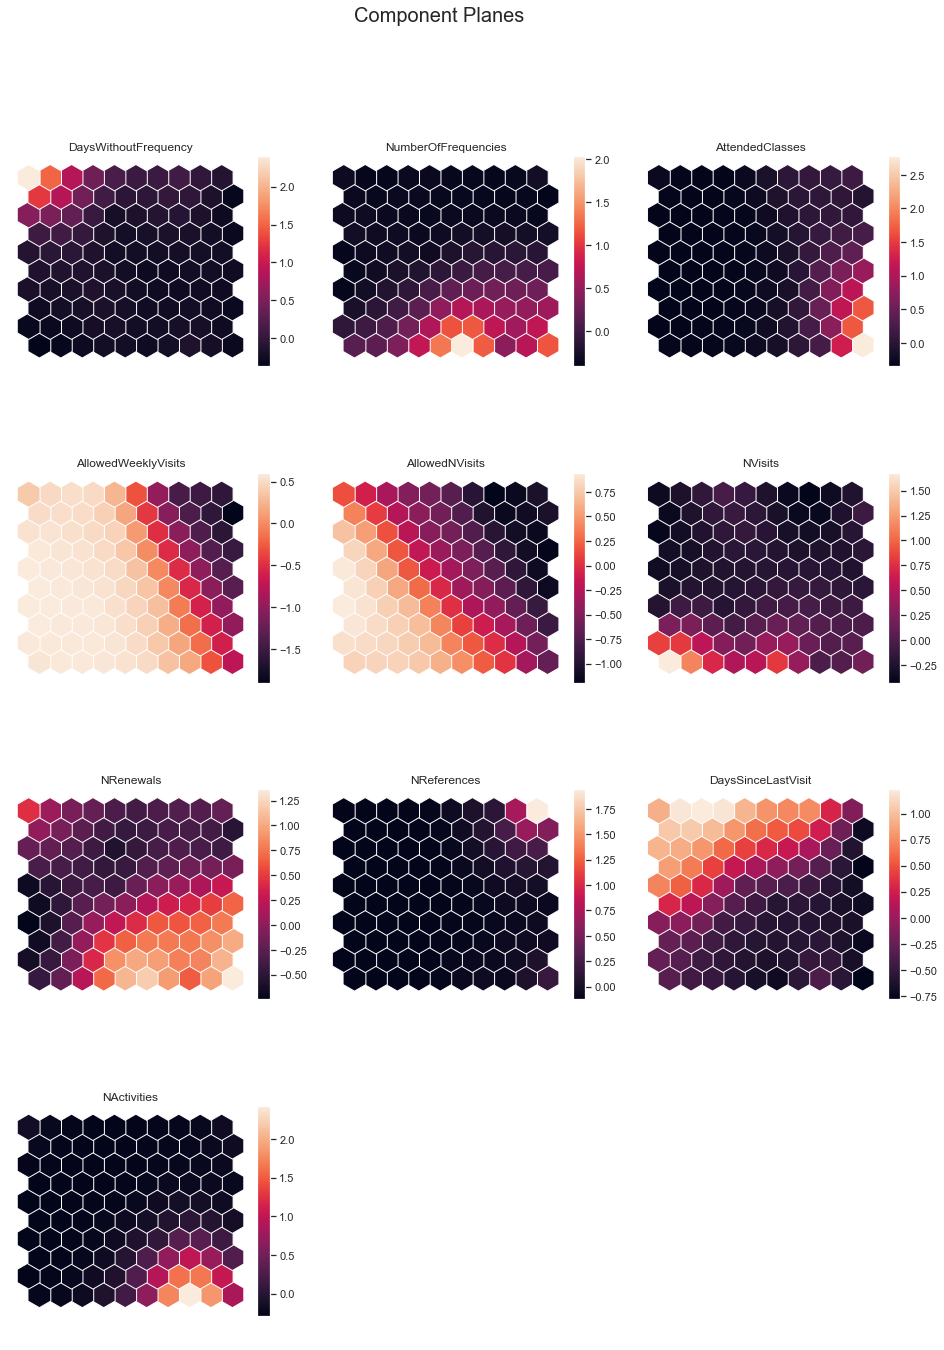

In [110]:
plt.rcParams['figure.dpi'] = 72


# Visualizing the Component planes (feature values)
sns.set()
view2D = View2D(12, 12, "", text_size=10)
view2D.show(sm, col_sz=3, what='codebook')
plt.subplots_adjust(top=0.90)
plt.suptitle("Component Planes", fontsize=20)
plt.show()

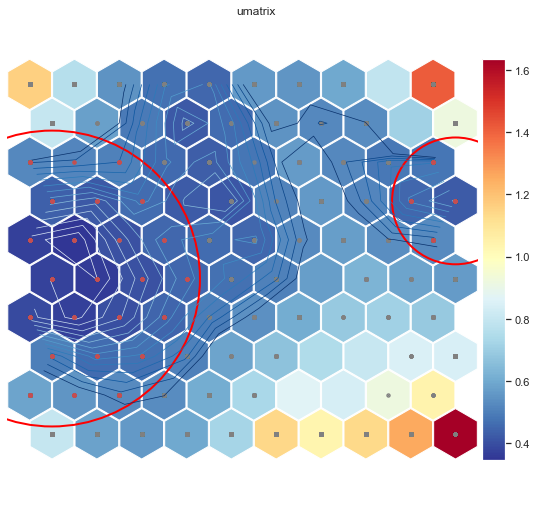

array([[1.162591  , 0.76321459, 0.54469979, 0.46903696, 0.45101055,
        0.55914731, 0.55025274, 0.59861556, 0.78858049, 1.41172449],
       [0.79726231, 0.57725349, 0.48947171, 0.41989227, 0.46231593,
        0.54727599, 0.51841185, 0.53172616, 0.71195008, 0.92095156],
       [0.52144632, 0.51671137, 0.50681808, 0.45747914, 0.4316542 ,
        0.48243409, 0.56412797, 0.52261438, 0.484544  , 0.48155593],
       [0.4328909 , 0.41907419, 0.45873122, 0.42419109, 0.41396527,
        0.50849275, 0.56053344, 0.51493617, 0.45070565, 0.42494195],
       [0.36726711, 0.34683705, 0.40520121, 0.44845027, 0.46147929,
        0.44769981, 0.52408828, 0.57262411, 0.5347767 , 0.52606279],
       [0.37233349, 0.35973828, 0.40728494, 0.44995529, 0.46993014,
        0.50435159, 0.57020606, 0.6242539 , 0.5844354 , 0.56656322],
       [0.39088853, 0.36883383, 0.39768227, 0.44546589, 0.4940898 ,
        0.5425049 , 0.60410104, 0.68469773, 0.71449787, 0.68536975],
       [0.50291838, 0.45901644, 0.4700132

In [111]:
u = sompy.umatrix.UMatrixView(9, 9, 'umatrix', show_axis=True, text_size=8, show_text=True)

UMAT = u.show(
    sm, 
    distance=2,
    row_normalized=False,
    show_data=True, 
    contour=True, # Visualize isomorphic curves
    blob=True
)

np.flip(UMAT[1], axis=1)

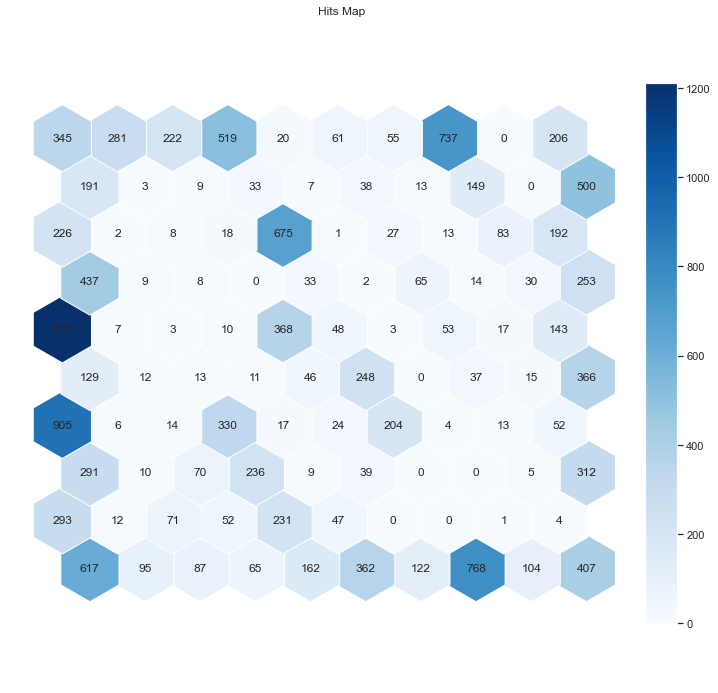

In [112]:
vhts  = BmuHitsView(12,12,"Hits Map")
vhts.show(sm, anotate=True, onlyzeros=False, labelsize=12, cmap="Blues")
plt.show()

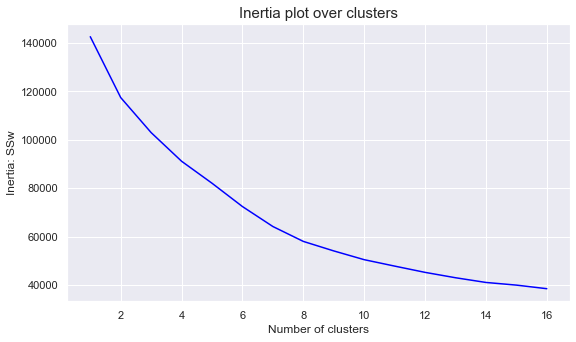

In [113]:
inertia = []
for n_clus in range(1,17): 
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=20, random_state=80)
    kmclust.fit(df7)
    inertia.append(kmclust.inertia_)
    

plt.figure(figsize=(9,5))
plt.plot(range(1,17),inertia,color = 'blue')
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters", size=15)
plt.show()

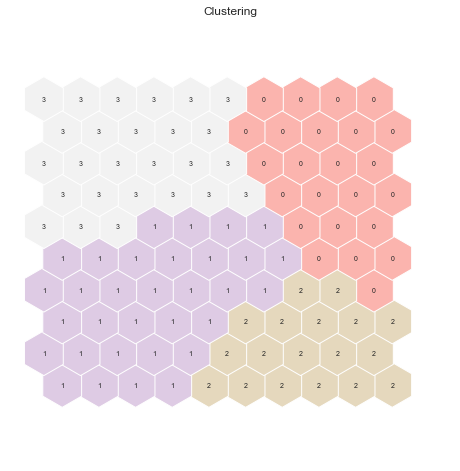

In [114]:
kmeans = KMeans(n_clusters=4,init='k-means++', n_init=20, random_state=80)

# Fit K-Means on the codebook matrix of the SOM
nodeclus_labels = kmeans.fit_predict(sm.codebook.matrix)

sm.cluster_labels = nodeclus_labels  # setting the cluster labels of sompy

# Create a HitMapView for visualization
hits = HitMapView(8,8,"Clustering", text_size=10)
hits.show(sm, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")

plt.show()

In [115]:
nodes = sm.codebook.matrix

# Create a DataFrame with the codebook matrix values
df_somk = pd.DataFrame(nodes, columns=behavior_features)

# Add a column for the K-Means cluster labels
df_somk['som_kmeans_bhv_labels'] = nodeclus_labels
df_somk

DaysWithoutFrequency  NumberOfFrequencies  AttendedClasses  \
0              -0.106554            -0.289339         0.161521   
1              -0.011643            -0.353311         0.091689   
2               0.097479            -0.378313         0.077788   
3               0.058458            -0.362924         0.022107   
4               0.053766            -0.361529        -0.128403   
..                   ...                  ...              ...   
95             -0.242483             1.338186        -0.243228   
96             -0.242438             0.747214        -0.287444   
97             -0.275893             0.369728        -0.308426   
98             -0.328489             0.175071        -0.313966   
99             -0.372944             0.145270        -0.308435   

    AllowedWeeklyVisits  AllowedNVisits   NVisits  NRenewals  NReferences  \
0             -1.591008       -1.043775 -0.246814  -0.198662     1.943892   
1             -1.504041       -1.136769 -0.353135  -0.290310     0.725594   
2             -1.428705       -1.195255 -0.430003  -0.294562     0.114788   
3             -0.963480       -0.967166 -0.368536  -0.327060     0.031861   
4             -0.299361       -0.707481 -0.261640  -0.374396    -0.050182   
..                  ...             ...       ...        ...          ...   
95             0.544414        0.622038  0.530286   1.070588    -0.097446   
96             0.570913        0.746064  0.477367   0.697591    -0.112659   
97             0.580761        0.809556  0.709581   0.205904    -0.120709   
98             0.575397        0.817415  1.139957  -0.216994    -0.124479   
99             0.559063        0.806239  1.679891  -0.443467    -0.125988   

    DaysSinceLastVisit  NActivities  som_kmeans_bhv_labels  
0            -0.127399    -0.179616                      0  
1             0.293696    -0.222940                      0  
2             0.751231    -0.246799                      0  
3             0.731408    -0.258059                      0  
4             0.786208    -0.270474                      3  
..                 ...          ...                    ...  
95           -0.655977     0.176387                      2  
96           -0.580468    -0.067224                      1  
97           -0.488227    -0.191129                      1  
98           -0.428933    -0.242382                      1  
99           -0.310619    -0.254038                      1  

[100 rows x 11 columns]

In [116]:
bmus_map = sm.find_bmu(df7.values)[0]  #get bmus for each observation in df
df_bmus = pd.DataFrame(
    np.concatenate((df7, np.expand_dims(bmus_map,1)), axis=1),
    index=df7.index, columns=np.append(df7.columns,"BMU")
)
df_bmus

DaysWithoutFrequency  NumberOfFrequencies  AttendedClasses  \
ID                                                                  
10000             -0.587244            -0.495738        -0.091962   
10001             -0.144577            -0.256085        -0.322828   
10002             -0.542227            -0.547092        -0.361306   
10003             -0.429685            -0.307440        -0.284351   
10005             -0.572239            -0.170495        -0.361306   
...                     ...                  ...              ...   
24937             -0.579741             1.267420         3.332548   
24938             -0.309640             0.325928        -0.361306   
24939             -0.579741            -0.547092        -0.361306   
24940             -0.572239             2.517038         5.602730   
24941             -0.489708             2.243149        -0.322828   

       AllowedWeeklyVisits  AllowedNVisits   NVisits  NRenewals  NReferences  \
ID                                                                             
10000            -2.381734       -1.797580 -0.535108  -0.879255      -0.1267   
10001            -1.525427       -1.225397 -0.699188   0.653238      -0.1267   
10002             0.615339       -0.577709  0.121214  -0.879255      -0.1267   
10003            -1.525427       -1.209988 -0.371027  -0.879255      -0.1267   
10005             0.615339        0.910790  3.402824  -0.879255      -0.1267   
...                    ...             ...       ...        ...          ...   
24937            -0.669121       -0.330654  0.449375   1.419484      -0.1267   
24938             0.615339        1.011461 -0.371027  -0.879255      -0.1267   
24939             0.615339       -0.577709  0.449375  -0.879255      -0.1267   
24940            -1.097274       -1.305009  0.285295   0.653238      -0.1267   
24941             0.615339        1.011461  1.269778   2.185731      -0.1267   

       DaysSinceLastVisit  NActivities   BMU  
ID                                            
10000           -1.259858    -0.291359  10.0  
10001            1.403465    -0.291359   2.0  
10002            0.249415    -0.291359  25.0  
10003           -0.780561    -0.291359  20.0  
10005            0.761005    -0.291359  99.0  
...                   ...          ...   ...  
24937           -1.258158    -0.291359  90.0  
24938            0.917371    -0.291359  49.0  
24939            0.346294    -0.291359  25.0  
24940           -1.256458    -0.291359  90.0  
24941           -0.996415    -0.291359  94.0  

[14266 rows x 11 columns]

In [117]:
df_somk_bhv = df_bmus.merge(df_somk['som_kmeans_bhv_labels'], 'left', left_on="BMU", right_index=True)

df_somk_bhv.drop('BMU', axis=1, inplace=True)

In [118]:
df_somk_bhv.groupby('som_kmeans_bhv_labels').mean()

DaysWithoutFrequency  NumberOfFrequencies  \
som_kmeans_bhv_labels                                              
0                                 -0.133561            -0.316127   
1                                 -0.264126            -0.127430   
2                                 -0.257228             1.299180   
3                                  0.509955            -0.348529   

                       AttendedClasses  AllowedWeeklyVisits  AllowedNVisits  \
som_kmeans_bhv_labels                                                         
0                             0.211354            -1.582972       -1.139484   
1                            -0.336920             0.599545        0.627530   
2                             0.984495            -0.097946       -0.118822   
3                            -0.331250             0.544161        0.213101   

                        NVisits  NRenewals  NReferences  DaysSinceLastVisit  \
som_kmeans_bhv_labels                                                         
0                     -0.292796  -0.150845     0.363808           -0.191644   
1                      0.260648  -0.211519    -0.126700           -0.515419   
2                      0.349251   1.143310    -0.001179           -0.636354   
3                     -0.255212  -0.292761    -0.123802            1.019344   

                       NActivities  
som_kmeans_bhv_labels               
0                        -0.244416  
1                        -0.284873  
2                         1.352428  
3                        -0.263487

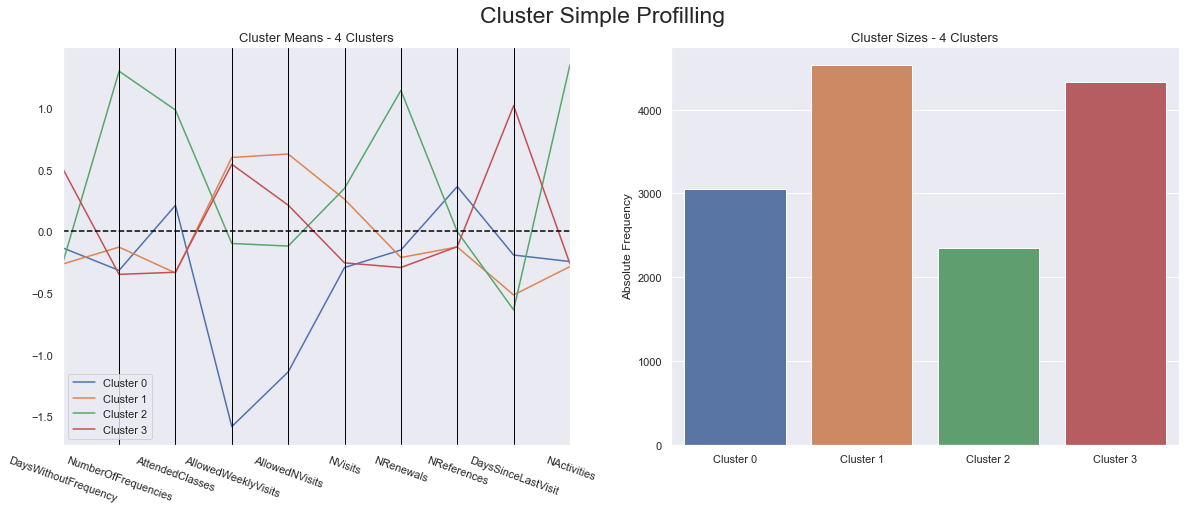

In [119]:
cluster_profiles(df_somk_bhv, ['som_kmeans_bhv_labels'], (20,7))

In [120]:
def get_ss(df):
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

sst = get_ss(df_somk_bhv)  # get total sum of squares
ssw_labels = df_somk_bhv.groupby(by='som_kmeans_bhv_labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
r2

0.3859149751529693

# SOM + Hierarchical

### Demographic + Value perspective

In [121]:
df12 = df_dem.copy()

In [122]:
df12

Age  AvgLifeTimeValue  LifetimeValue  EnrollmentTime
ID                                                              
10000  2.452289          1.428476      -0.602086       -0.683551
10001  0.223473          0.843253       0.579351        0.343892
10002 -0.207910          0.929021      -0.758914       -0.768164
10003 -1.214473          0.438429      -0.401922       -0.375318
10005 -0.136013         -0.248762      -0.448591       -0.124501
...         ...               ...            ...             ...
24937 -0.854986         -1.250769       3.553019       -0.858821
24938  0.942446          1.040472       0.169174       -0.070107
24939 -0.423602          1.276858      -0.740731       -0.768164
24940  2.092803         -1.250769       1.516984       -0.858821
24941  0.439165          0.120897       1.913979        2.664704

[14266 rows x 4 columns]

In [123]:
np.random.seed(80)

sm = sompy.SOMFactory().build(
    df12.values, 
    mapsize=[10, 10], 
    initialization='random', 
    neighborhood='gaussian',
    training='batch',
    lattice='hexa',
    component_names=dem_value_features
)
sm.train(n_job=1, verbose='info', train_rough_len=120, train_finetune_len=120)

 Training...
 random_initialization took: 0.000000 seconds
 Rough training...
 radius_ini: 4.000000 , radius_final: 1.000000, trainlen: 120

 epoch: 1 ---> elapsed time:  0.050000, quantization error: 1.452004

 epoch: 2 ---> elapsed time:  0.065000, quantization error: 1.665836

 epoch: 3 ---> elapsed time:  0.067000, quantization error: 1.612565

 epoch: 4 ---> elapsed time:  0.059000, quantization error: 1.586234

 epoch: 5 ---> elapsed time:  0.066000, quantization error: 1.570605

 epoch: 6 ---> elapsed time:  0.053000, quantization error: 1.559142

 epoch: 7 ---> elapsed time:  0.054000, quantization error: 1.553930

 epoch: 8 ---> elapsed time:  0.058000, quantization error: 1.550028

 epoch: 9 ---> elapsed time:  0.062000, quantization error: 1.546792

 epoch: 10 ---> elapsed time:  0.070000, quantization error: 1.542737

 epoch: 11 ---> elapsed time:  0.063000, quantization error: 1.538507

 epoch: 12 ---> elapsed time:  0.067000, quantization error: 1.535756

 epoch: 13 ---> 

In [124]:
linkage = 'ward'
distance = 'euclidean'
hclust = AgglomerativeClustering(linkage=linkage, affinity=distance, distance_threshold=0, n_clusters=None)
hclust.fit_predict(df12)

array([ 9155, 12091, 12199, ...,     3,     1,     0])

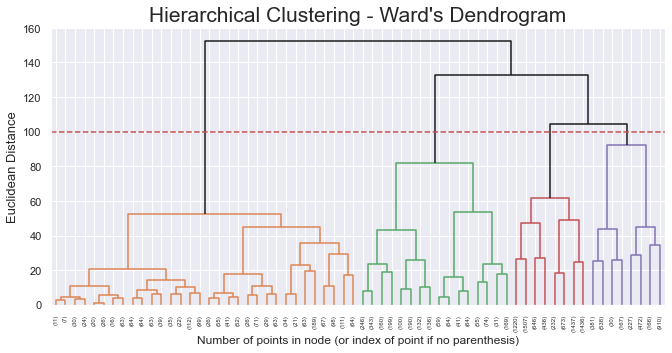

In [125]:
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 100
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

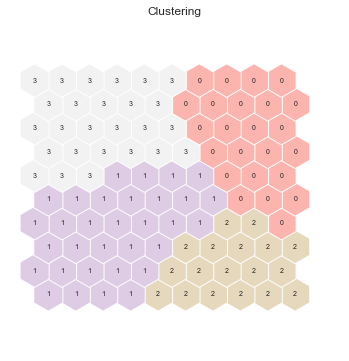

In [126]:
hierclust = AgglomerativeClustering(n_clusters=4, linkage='ward')
node_hier_label= hierclust.fit_predict(sm.codebook.matrix)
sm.cluster_labels = nodeclus_labels  # setting the cluster labels of sompy

hits  = HitMapView(6,6,"Clustering",text_size=10)
hits.show(sm, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")

plt.show()

In [127]:
nodes = sm.codebook.matrix

hnodes = pd.DataFrame(nodes, columns=dem_value_features)
hnodes['som_hierar_dem_labels'] = node_hier_label
hnodes

Age  AvgLifeTimeValue  LifetimeValue  EnrollmentTime  \
0  -0.574415         -1.133197       2.061111       -0.779164   
1  -0.380187         -1.070197       1.039179       -0.706381   
2  -0.259719         -1.025891       0.198020       -0.614186   
3  -0.246055         -0.972160      -0.267306       -0.469837   
4  -0.226071         -0.820007      -0.413260       -0.088039   
..       ...               ...            ...             ...   
95  0.452563          0.597394      -0.434089       -0.445229   
96  0.837437          0.620609      -0.400099       -0.425871   
97  1.280911          0.618897      -0.341368       -0.398444   
98  1.707528          0.368862      -0.224141       -0.338256   
99  2.074519          0.013164      -0.059099       -0.284639   

    som_hierar_dem_labels  
0                       0  
1                       0  
2                       0  
3                       0  
4                       0  
..                    ...  
95                      1  
96                      2  
97                      2  
98                      2  
99                      2  

[100 rows x 5 columns]

In [128]:
bmus_ = sm.find_bmu(df12.values)[0]
df_bmus = pd.DataFrame(
    np.concatenate((df12, np.expand_dims(bmus_,1)), axis=1),
    index=df12.index, columns=np.append(df12.columns,"BMU")
)
df_bmus

Age  AvgLifeTimeValue  LifetimeValue  EnrollmentTime   BMU
ID                                                                    
10000  2.452289          1.428476      -0.602086       -0.683551  98.0
10001  0.223473          0.843253       0.579351        0.343892  49.0
10002 -0.207910          0.929021      -0.758914       -0.768164  92.0
10003 -1.214473          0.438429      -0.401922       -0.375318  50.0
10005 -0.136013         -0.248762      -0.448591       -0.124501  35.0
...         ...               ...            ...             ...   ...
24937 -0.854986         -1.250769       3.553019       -0.858821   0.0
24938  0.942446          1.040472       0.169174       -0.070107  96.0
24939 -0.423602          1.276858      -0.740731       -0.768164  80.0
24940  2.092803         -1.250769       1.516984       -0.858821  89.0
24941  0.439165          0.120897       1.913979        2.664704   9.0

[14266 rows x 5 columns]

In [129]:
# Get cluster labels for each observation
df_somh_dem = df_bmus.merge(hnodes['som_hierar_dem_labels'], 'left', left_on="BMU", right_index=True)

df_somh_dem.drop('BMU', axis=1, inplace=True)

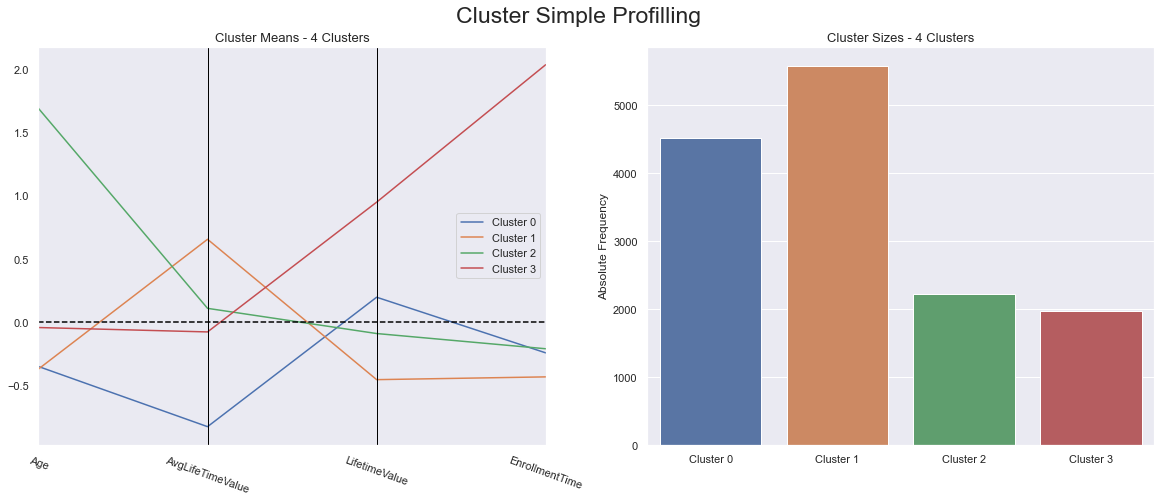

In [130]:
cluster_profiles(df_somh_dem, ['som_hierar_dem_labels'], (20,7))

In [131]:
df_somh_dem.groupby('som_hierar_dem_labels').mean()

Age  AvgLifeTimeValue  LifetimeValue  \
som_hierar_dem_labels                                              
0                     -0.351116         -0.826369       0.195833   
1                     -0.371317          0.653371      -0.455080   
2                      1.687136          0.108035      -0.090914   
3                     -0.043537         -0.078218       0.946576   

                       EnrollmentTime  
som_hierar_dem_labels                  
0                           -0.243597  
1                           -0.433207  
2                           -0.211109  
3                            2.032114

In [132]:
def get_ss(df):
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

sst = get_ss(df_somh_dem)  # get total sum of squares
ssw_labels = df_somh_dem.groupby(by='som_hierar_dem_labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
r2

0.5617118258689138

### Behavior perspective

In [133]:
df13 = df_bhv.copy()

In [134]:
np.random.seed(80)

sm = sompy.SOMFactory().build(
    df13.values, 
    mapsize=[10, 10], 
    initialization='random', 
    neighborhood='gaussian',
    training='batch',
    lattice='hexa',
    component_names=behavior_features
)
sm.train(n_job=1, verbose='info', train_rough_len=120, train_finetune_len=120)


 Training...
 random_initialization took: 0.000000 seconds
 Rough training...
 radius_ini: 4.000000 , radius_final: 1.000000, trainlen: 120

 epoch: 1 ---> elapsed time:  0.042000, quantization error: 5.060262

 epoch: 2 ---> elapsed time:  0.063000, quantization error: 2.745068

 epoch: 3 ---> elapsed time:  0.062000, quantization error: 2.667011

 epoch: 4 ---> elapsed time:  0.062000, quantization error: 2.622669

 epoch: 5 ---> elapsed time:  0.061000, quantization error: 2.604855

 epoch: 6 ---> elapsed time:  0.062000, quantization error: 2.595620

 epoch: 7 ---> elapsed time:  0.064000, quantization error: 2.590580

 epoch: 8 ---> elapsed time:  0.060000, quantization error: 2.586812

 epoch: 9 ---> elapsed time:  0.066000, quantization error: 2.583375

 epoch: 10 ---> elapsed time:  0.064000, quantization error: 2.580464

 epoch: 11 ---> elapsed time:  0.060000, quantization error: 2.577782

 epoch: 12 ---> elapsed time:  0.056000, quantization error: 2.574972

 epoch: 13 ---> 

In [135]:
linkage = 'ward'
distance = 'euclidean'
hclust = AgglomerativeClustering(linkage=linkage, affinity=distance, distance_threshold=0, n_clusters=None)
hclust.fit_predict(df13)

array([ 8679, 11687, 13854, ...,     4,     1,     0])

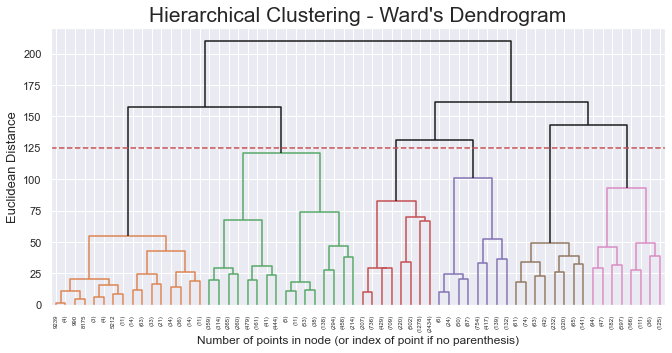

In [136]:
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 125
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

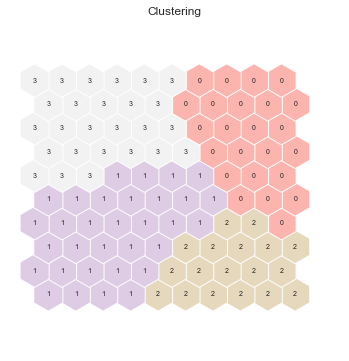

In [137]:
hierclust = AgglomerativeClustering(n_clusters=5, linkage='ward')
node_hier_label= hierclust.fit_predict(sm.codebook.matrix)
sm.cluster_labels = nodeclus_labels  # setting the cluster labels of sompy

hits  = HitMapView(6,6,"Clustering",text_size=10)
hits.show(sm, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")

plt.show()

In [138]:
nodes = sm.codebook.matrix

hnodes = pd.DataFrame(nodes, columns=behavior_features)
hnodes['som_hierar_bhv_labels'] = node_hier_label
hnodes

DaysWithoutFrequency  NumberOfFrequencies  AttendedClasses  \
0              -0.106554            -0.289339         0.161521   
1              -0.011643            -0.353311         0.091689   
2               0.097479            -0.378313         0.077788   
3               0.058458            -0.362924         0.022107   
4               0.053766            -0.361529        -0.128403   
..                   ...                  ...              ...   
95             -0.242483             1.338186        -0.243228   
96             -0.242438             0.747214        -0.287444   
97             -0.275893             0.369728        -0.308426   
98             -0.328489             0.175071        -0.313966   
99             -0.372944             0.145270        -0.308435   

    AllowedWeeklyVisits  AllowedNVisits   NVisits  NRenewals  NReferences  \
0             -1.591008       -1.043775 -0.246814  -0.198662     1.943892   
1             -1.504041       -1.136769 -0.353135  -0.290310     0.725594   
2             -1.428705       -1.195255 -0.430003  -0.294562     0.114788   
3             -0.963480       -0.967166 -0.368536  -0.327060     0.031861   
4             -0.299361       -0.707481 -0.261640  -0.374396    -0.050182   
..                  ...             ...       ...        ...          ...   
95             0.544414        0.622038  0.530286   1.070588    -0.097446   
96             0.570913        0.746064  0.477367   0.697591    -0.112659   
97             0.580761        0.809556  0.709581   0.205904    -0.120709   
98             0.575397        0.817415  1.139957  -0.216994    -0.124479   
99             0.559063        0.806239  1.679891  -0.443467    -0.125988   

    DaysSinceLastVisit  NActivities  som_hierar_bhv_labels  
0            -0.127399    -0.179616                      2  
1             0.293696    -0.222940                      2  
2             0.751231    -0.246799                      2  
3             0.731408    -0.258059                      2  
4             0.786208    -0.270474                      0  
..                 ...          ...                    ...  
95           -0.655977     0.176387                      1  
96           -0.580468    -0.067224                      3  
97           -0.488227    -0.191129                      3  
98           -0.428933    -0.242382                      3  
99           -0.310619    -0.254038                      3  

[100 rows x 11 columns]

In [139]:
bmus_ = sm.find_bmu(df13.values)[0]
df_bmus = pd.DataFrame(
    np.concatenate((df13, np.expand_dims(bmus_,1)), axis=1),
    index=df13.index, columns=np.append(df13.columns,"BMU")
)
df_bmus

DaysWithoutFrequency  NumberOfFrequencies  AttendedClasses  \
ID                                                                  
10000             -0.587244            -0.495738        -0.091962   
10001             -0.144577            -0.256085        -0.322828   
10002             -0.542227            -0.547092        -0.361306   
10003             -0.429685            -0.307440        -0.284351   
10005             -0.572239            -0.170495        -0.361306   
...                     ...                  ...              ...   
24937             -0.579741             1.267420         3.332548   
24938             -0.309640             0.325928        -0.361306   
24939             -0.579741            -0.547092        -0.361306   
24940             -0.572239             2.517038         5.602730   
24941             -0.489708             2.243149        -0.322828   

       AllowedWeeklyVisits  AllowedNVisits   NVisits  NRenewals  NReferences  \
ID                                                                             
10000            -2.381734       -1.797580 -0.535108  -0.879255      -0.1267   
10001            -1.525427       -1.225397 -0.699188   0.653238      -0.1267   
10002             0.615339       -0.577709  0.121214  -0.879255      -0.1267   
10003            -1.525427       -1.209988 -0.371027  -0.879255      -0.1267   
10005             0.615339        0.910790  3.402824  -0.879255      -0.1267   
...                    ...             ...       ...        ...          ...   
24937            -0.669121       -0.330654  0.449375   1.419484      -0.1267   
24938             0.615339        1.011461 -0.371027  -0.879255      -0.1267   
24939             0.615339       -0.577709  0.449375  -0.879255      -0.1267   
24940            -1.097274       -1.305009  0.285295   0.653238      -0.1267   
24941             0.615339        1.011461  1.269778   2.185731      -0.1267   

       DaysSinceLastVisit  NActivities   BMU  
ID                                            
10000           -1.259858    -0.291359  10.0  
10001            1.403465    -0.291359   2.0  
10002            0.249415    -0.291359  25.0  
10003           -0.780561    -0.291359  20.0  
10005            0.761005    -0.291359  99.0  
...                   ...          ...   ...  
24937           -1.258158    -0.291359  90.0  
24938            0.917371    -0.291359  49.0  
24939            0.346294    -0.291359  25.0  
24940           -1.256458    -0.291359  90.0  
24941           -0.996415    -0.291359  94.0  

[14266 rows x 11 columns]

In [140]:
df_somh_bhv = df_bmus.merge(hnodes['som_hierar_bhv_labels'], 'left', left_on="BMU", right_index=True)

df_somh_bhv.drop('BMU', axis=1, inplace=True)

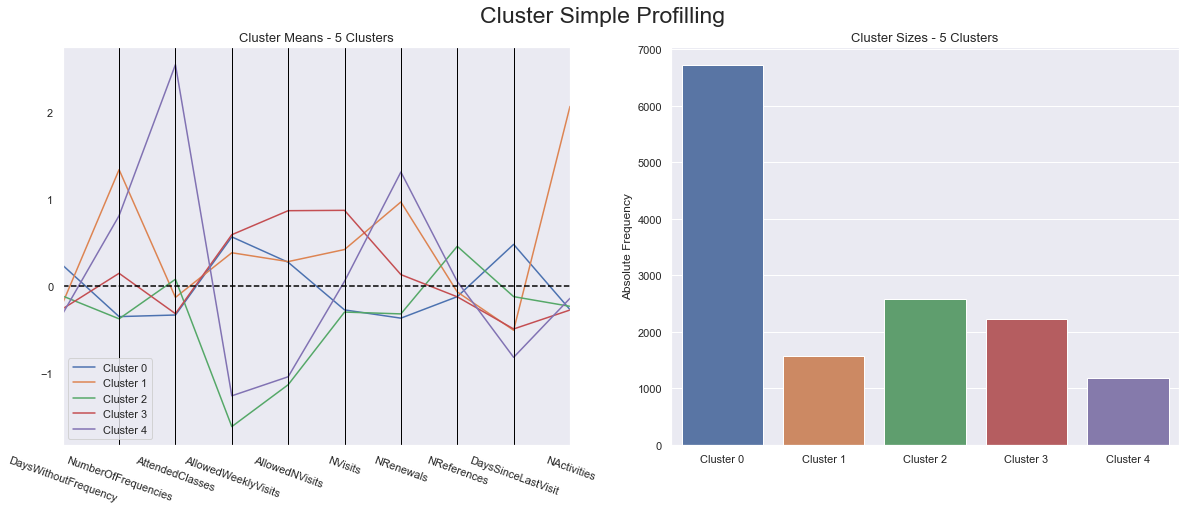

In [141]:
cluster_profiles(df_somh_bhv, ['som_hierar_bhv_labels'], (20,7))

In [142]:
df_somh_bhv.groupby('som_hierar_bhv_labels').mean()

DaysWithoutFrequency  NumberOfFrequencies  \
som_hierar_bhv_labels                                              
0                                  0.235318            -0.353866   
1                                 -0.198540             1.332960   
2                                 -0.117800            -0.379286   
3                                 -0.263881             0.143164   
4                                 -0.320178             0.804825   

                       AttendedClasses  AllowedWeeklyVisits  AllowedNVisits  \
som_hierar_bhv_labels                                                         
0                            -0.335568             0.561174        0.269917   
1                            -0.133454             0.379173        0.277636   
2                             0.074858            -1.616453       -1.135794   
3                            -0.320302             0.586077        0.862003   
4                             2.538513            -1.263211       -1.044378   

                        NVisits  NRenewals  NReferences  DaysSinceLastVisit  \
som_hierar_bhv_labels                                                         
0                     -0.276994  -0.371621    -0.124829            0.475317   
1                      0.416141   0.962177    -0.070735           -0.510247   
2                     -0.301704  -0.322712     0.453112           -0.124548   
3                      0.865995   0.128166    -0.126700           -0.495694   
4                      0.051194   1.305918     0.049714           -0.821240   

                       NActivities  
som_hierar_bhv_labels               
0                        -0.273372  
1                         2.058949  
2                        -0.235869  
3                        -0.278156  
4                        -0.144071

In [143]:
def get_ss(df):
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

sst = get_ss(df_somh_bhv)  # get total sum of squares
ssw_labels = df_somh_bhv.groupby(by='som_hierar_bhv_labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
r2

0.4657062554781339

# Mean shift

### Demographic + value perspective

In [144]:
df8 = df_dem.copy()

In [145]:
from sklearn.cluster import MeanShift, estimate_bandwidth
bandwidth_value = estimate_bandwidth(df8, quantile=0.20, random_state=80, n_jobs=-1)
bandwidth_value

1.6275431513471363

In [146]:
mean_shift = MeanShift(bandwidth=bandwidth_value, bin_seeding=True, n_jobs=4)
mean_shift_labels = mean_shift.fit_predict(df8)

mean_shift_clusters = len(np.unique(mean_shift_labels))
print("Number of estimated clusters : %d" % mean_shift_clusters)

Number of estimated clusters : 4


In [147]:
df_mean_shift_dem = pd.concat([df8, pd.Series(mean_shift_labels, name='mean_shift_dem_labels', index=df8.index)], axis=1)

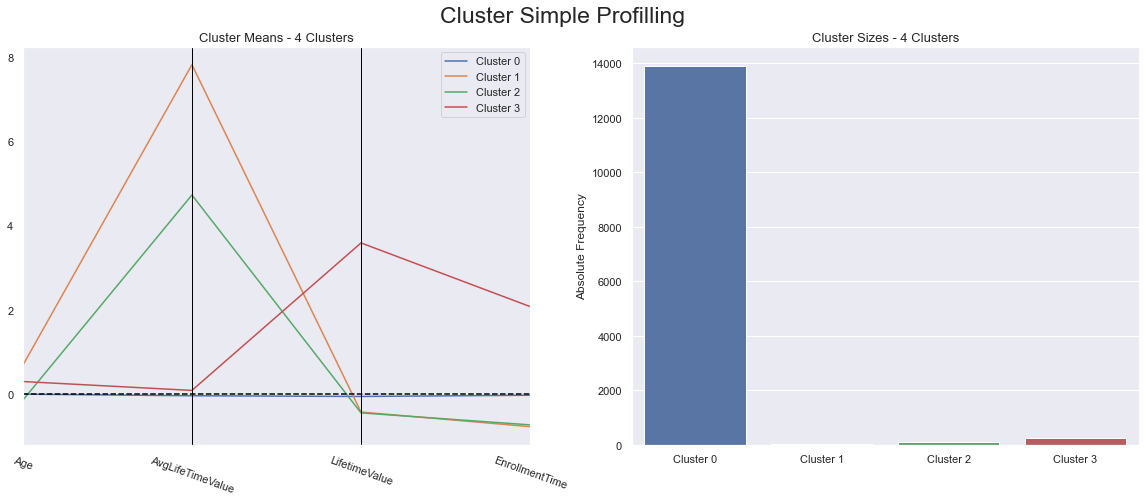

In [148]:
cluster_profiles(df_mean_shift_dem, ['mean_shift_dem_labels'], (20,7))

In [149]:
df_mean_shift_dem.groupby('mean_shift_dem_labels').mean()

Age  AvgLifeTimeValue  LifetimeValue  \
mean_shift_dem_labels                                              
0                     -0.004618         -0.042276      -0.058978   
1                      0.681002          7.813594      -0.428257   
2                     -0.147291          4.721780      -0.449316   
3                      0.295371          0.084304       3.584042   

                       EnrollmentTime  
mean_shift_dem_labels                  
0                           -0.030247  
1                           -0.775856  
2                           -0.733146  
3                            2.074266

In [150]:
silhouette_avg = silhouette_score(df_mean_shift_dem, mean_shift_labels)
round(silhouette_avg,3)

0.553

In [151]:
kmeans_db_index = davies_bouldin_score(df_mean_shift_dem, mean_shift_labels)
round(kmeans_db_index,3)

0.905

### Behavior perspective

In [152]:
df9 = df_bhv.copy()

In [153]:
from sklearn.cluster import MeanShift, estimate_bandwidth
bandwidth_value = estimate_bandwidth(df9, quantile=0.75, random_state=80, n_jobs=-1)
bandwidth_value

4.546778966343287

In [154]:
mean_shift = MeanShift(bandwidth=bandwidth_value, bin_seeding=True, n_jobs=4)
mean_shift_labels = mean_shift.fit_predict(df9)

mean_shift_clusters = len(np.unique(mean_shift_labels))
print("Number of estimated clusters : %d" % mean_shift_clusters)

Number of estimated clusters : 7


In [155]:
df_mean_shift_bhv = pd.concat([df9, pd.Series(mean_shift_labels, name='mean_shift_bhv_labels', index=df8.index)], axis=1)

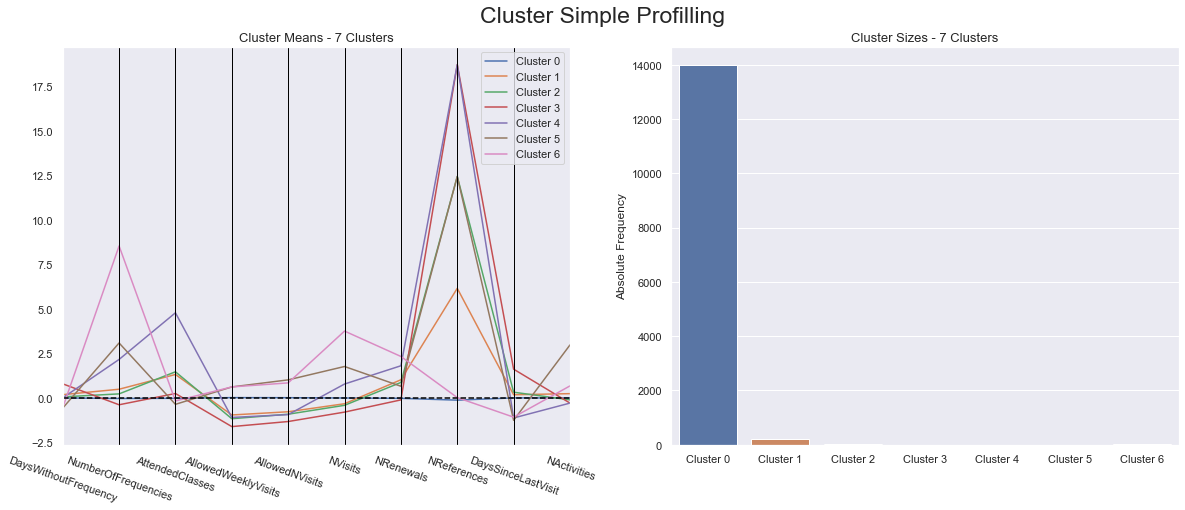

In [156]:
cluster_profiles(df_mean_shift_bhv, ['mean_shift_bhv_labels'], (20,7))

In [157]:
df_mean_shift_bhv.groupby('mean_shift_bhv_labels').mean()

DaysWithoutFrequency  NumberOfFrequencies  \
mean_shift_bhv_labels                                              
0                                 -0.001538            -0.035465   
1                                  0.181006             0.485771   
2                                  0.056748             0.225122   
3                                  0.788774            -0.386183   
4                                  0.001728             2.157559   
5                                 -0.572239             3.081933   
6                                 -0.549730             8.525082   

                       AttendedClasses  AllowedWeeklyVisits  AllowedNVisits  \
mean_shift_bhv_labels                                                         
0                            -0.023522             0.015900        0.011768   
1                             1.312978            -0.958312       -0.778147   
2                             1.464245            -1.168633       -0.915706   
3                             0.246641            -1.611058       -1.326376   
4                             4.775460            -1.097274       -0.939305   
5                            -0.361306             0.615339        1.011461   
6                            -0.172416             0.615339        0.841578   

                        NVisits  NRenewals  NReferences  DaysSinceLastVisit  \
mean_shift_bhv_labels                                                         
0                     -0.005875  -0.025292    -0.126700           -0.000201   
1                     -0.327848   1.016197     6.149335            0.175839   
2                     -0.416605   0.866084    12.425370            0.319006   
3                     -0.797636  -0.113009    18.701405            1.611500   
4                      0.777536   1.802608    18.701405           -1.126437   
5                      1.762019   0.653238    12.425370           -1.256458   
6                      3.749630   2.325049     0.015937           -1.081087   

                       NActivities  
mean_shift_bhv_labels               
0                        -0.005930  
1                         0.238095  
2                        -0.110105  
3                        -0.291359  
4                        -0.291359  
5                         2.971225  
6                         0.672586

In [158]:
silhouette_avg = silhouette_score(df_mean_shift_bhv, mean_shift_labels)
round(silhouette_avg,3)

0.538

In [159]:
kmeans_db_index = davies_bouldin_score(df_mean_shift_bhv, mean_shift_labels)
round(kmeans_db_index,3)

0.729

# DBSCAN

### Demographic + value perpectives

In [160]:
df10 = df_dem.copy()

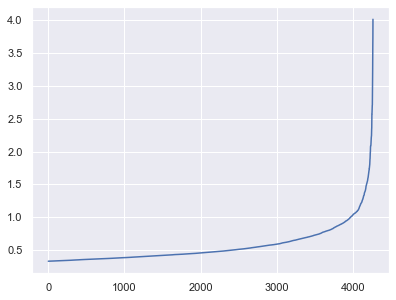

In [161]:
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors

# Radius of cluster
neigh = NearestNeighbors(n_neighbors=30)
neigh.fit(df10)
distances, _ = neigh.kneighbors(df10)
distances = np.sort(distances[:, -1])
plt.plot(distances[10000:])
plt.show()

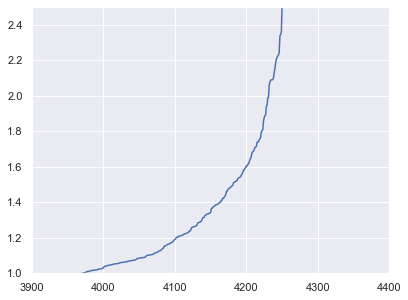

In [162]:
plt.plot(distances[10000:])
plt.axis([3900, 4400, 1.0,2.5])
plt.show()

In [163]:
dbscan = DBSCAN(eps=0.9,min_samples = 8, n_jobs=4)
dbscan_labels = dbscan.fit_predict(df10)

dbscan_clusters = len(np.unique(dbscan_labels))
print("Number of estimated clusters : %d" % dbscan_clusters)

Number of estimated clusters : 2


In [164]:
df_dbscan_dem = pd.concat([df10, pd.Series(dbscan_labels, name='dbscan_dem_labels', index=df10.index)], axis=1)

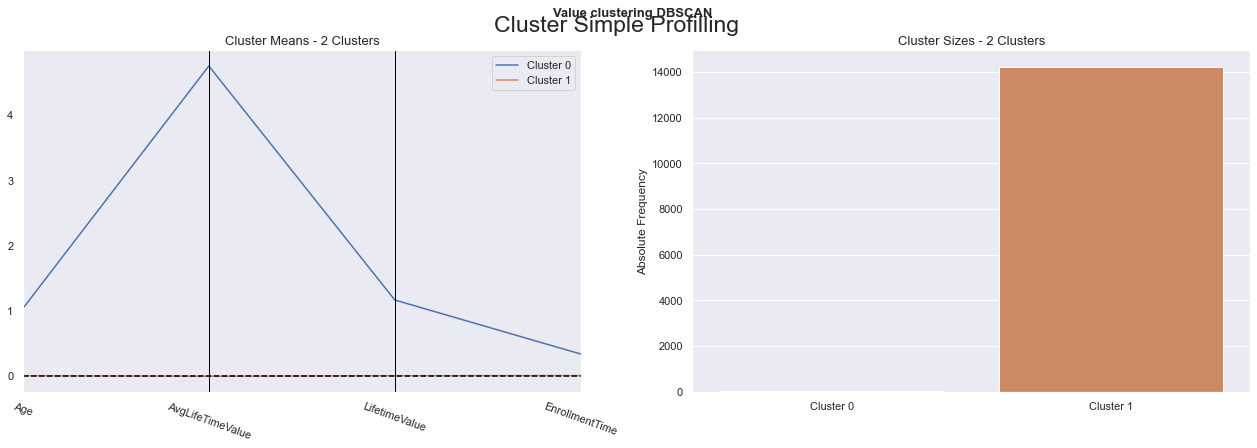

In [165]:
cluster_profiles(
    df = df_dbscan_dem, 
    label_columns = ['dbscan_dem_labels'], 
    figsize = (22, 6), 
    compar_titles = ["Value clustering DBSCAN"]
)

In [166]:
df_dbscan_dem.groupby('dbscan_dem_labels').mean()

Age  AvgLifeTimeValue  LifetimeValue  EnrollmentTime
dbscan_dem_labels                                                           
-1                 1.029146          4.755863       1.160004        0.329760
 0                -0.002459         -0.011362      -0.002771       -0.000788

In [167]:
silhouette_avg = silhouette_score(df_dbscan_dem, dbscan_labels)
round(silhouette_avg,3)

0.623

### Behavior perspective

In [168]:
df11 = df_bhv.copy()

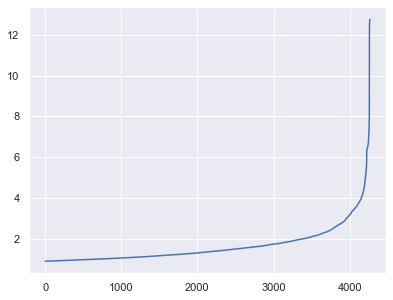

In [169]:
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors

# Radius of cluster
neigh = NearestNeighbors(n_neighbors= 30)
neigh.fit(df11)
distances, _ = neigh.kneighbors(df11)
distances = np.sort(distances[:, -1])
plt.plot(distances[10000:])
plt.show()

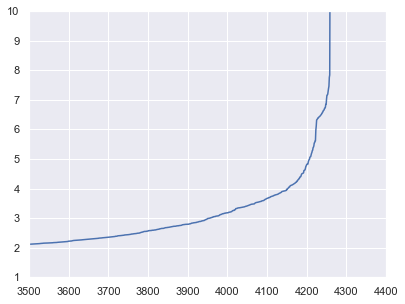

In [170]:
plt.plot(distances[10000:])
plt.axis([3500, 4400, 1,10])
plt.show()

In [171]:
dbscan = DBSCAN(eps=1.9,min_samples = 20, n_jobs=4)
dbscan_labels = dbscan.fit_predict(df10)

dbscan_clusters = len(np.unique(dbscan_labels))
print("Number of estimated clusters : %d" % dbscan_clusters)

Number of estimated clusters : 2


In [172]:
df_dbscan_bhv = pd.concat([df11, pd.Series(dbscan_labels, name='dbscan_bhv_labels', index=df11.index)], axis=1)

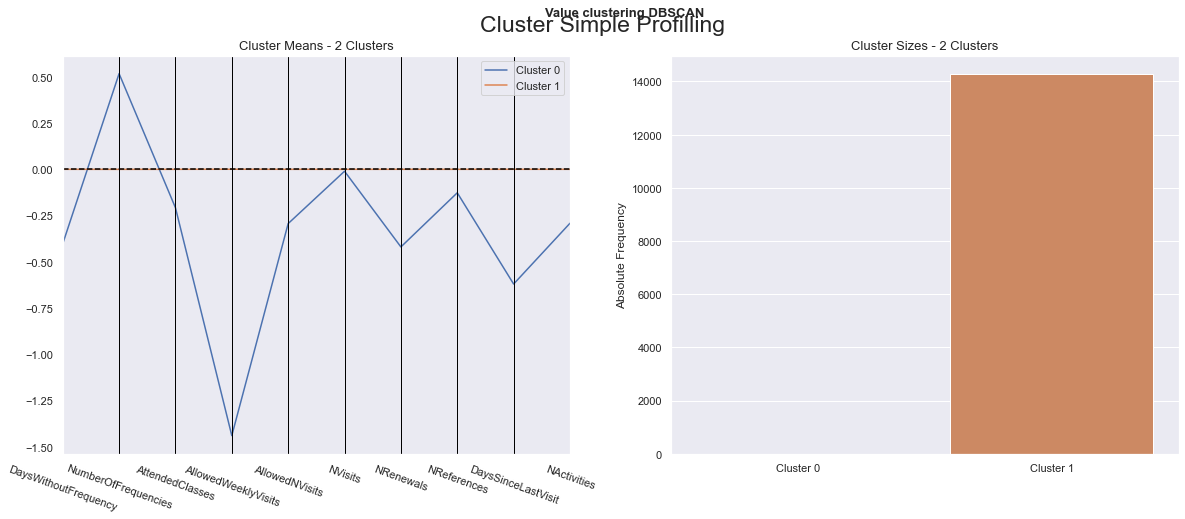

In [173]:
cluster_profiles(
    df = df_dbscan_bhv, 
    label_columns = ['dbscan_bhv_labels'], 
    figsize = (20, 7), 
    compar_titles = ["Value clustering DBSCAN"]
)

In [174]:
df_dbscan_bhv.groupby('dbscan_bhv_labels').mean()

DaysWithoutFrequency  NumberOfFrequencies  AttendedClasses  \
dbscan_bhv_labels                                                               
-1                            -0.402675             0.517650        -0.207395   
 0                             0.000141            -0.000181         0.000073   

                   AllowedWeeklyVisits  AllowedNVisits   NVisits  NRenewals  \
dbscan_bhv_labels                                                             
-1                           -1.439797       -0.293159 -0.010050  -0.419507   
 0                            0.000505        0.000103  0.000004   0.000147   

                   NReferences  DaysSinceLastVisit  NActivities  
dbscan_bhv_labels                                                
-1                   -0.126700           -0.620116    -0.291359  
 0                    0.000044            0.000217     0.000102

In [175]:
silhouette_avg = silhouette_score(df_dbscan_bhv, dbscan_labels)
round(silhouette_avg,3)

0.111

# Comparing Perspectives

In [176]:
df_dem['kmeans/hierchical_labels'] = kmeans_hierarchical['kmeans/hierchical_labels'].copy()
df_dem['hierarchical/dem_labels'] = hierarchical_dem['hierarchical/dem_labels'].copy()
df_dem['kmeans/dem_labels'] = kmeans_dem['kmeans/dem_labels'].copy()
df_dem['som_kmeans_dem_labels'] = df_somk_dem['som_kmeans_dem_labels'].copy()
df_dem['som_hierar_dem_labels'] = df_somh_dem['som_hierar_dem_labels'].copy()
df_dem['mean_shift_dem_labels'] = df_mean_shift_dem['mean_shift_dem_labels'].copy()
df_dem['dbscan_dem_labels'] = df_dbscan_dem['dbscan_dem_labels'].copy()

In [177]:
df_bhv['kmeans/hierchical_labels'] = kmeans_hierarchical['kmeans/hierchical_labels'].copy()
df_bhv['hierarchical/bhv_labels'] = hierarchical_bhv['hierarchical/bhv_labels'].copy()
df_bhv['kmeans/bhv_labels'] = kmeans_bhv['kmeans/bhv_labels'].copy()
df_bhv['som_kmeans_bhv_labels'] = df_somk_bhv['som_kmeans_bhv_labels'].copy()
df_bhv['som_hierar_bhv_labels'] = df_somh_bhv['som_hierar_bhv_labels'].copy()
df_bhv['mean_shift_bhv_labels'] = df_mean_shift_bhv['mean_shift_bhv_labels'].copy()
df_bhv['dbscan_bhv_labels'] = df_dbscan_bhv['dbscan_bhv_labels'].copy()

## Demographic and Value

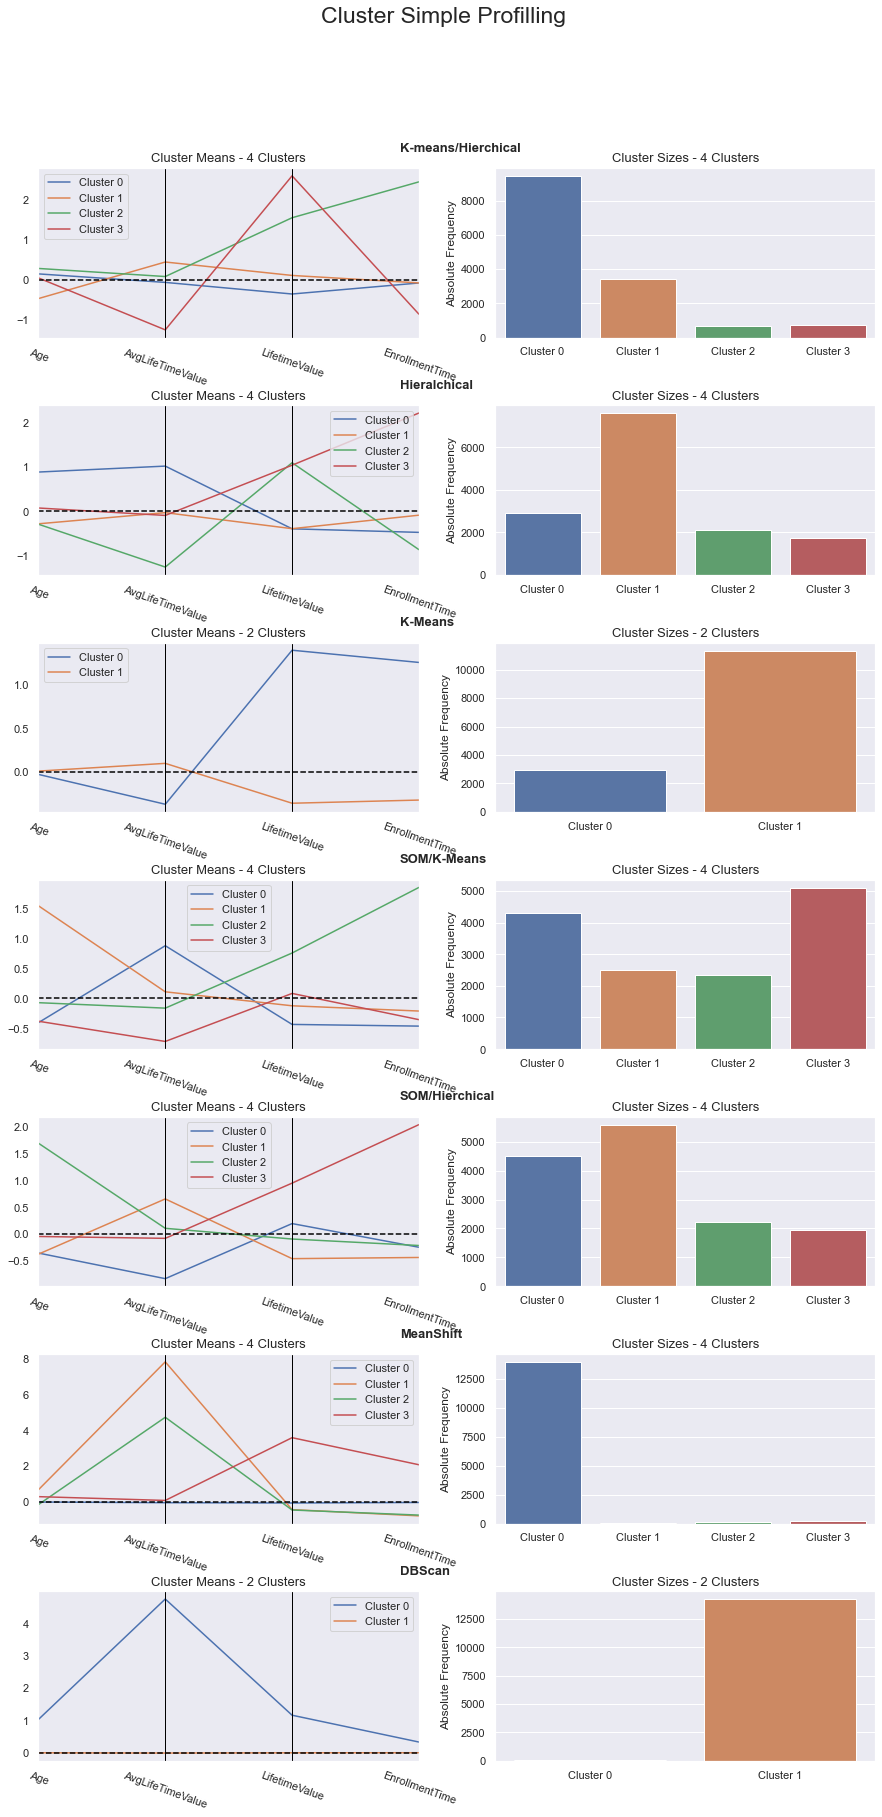

In [178]:
cluster_profiles(df_dem, ['kmeans/hierchical_labels',
                          'hierarchical/dem_labels',
                          'kmeans/dem_labels',
                          'som_kmeans_dem_labels',
                          'som_hierar_dem_labels',
                          'mean_shift_dem_labels',
                          'dbscan_dem_labels'], 
                 (15,28),
                 compar_titles = ["K-means/Hierchical", 
                                  "Hieralchical",
                                  'K-Means',
                                  "SOM/K-Means", 
                                  "SOM/Hierchical",
                                  "MeanShift",
                                  "DBScan"])

## Behavior

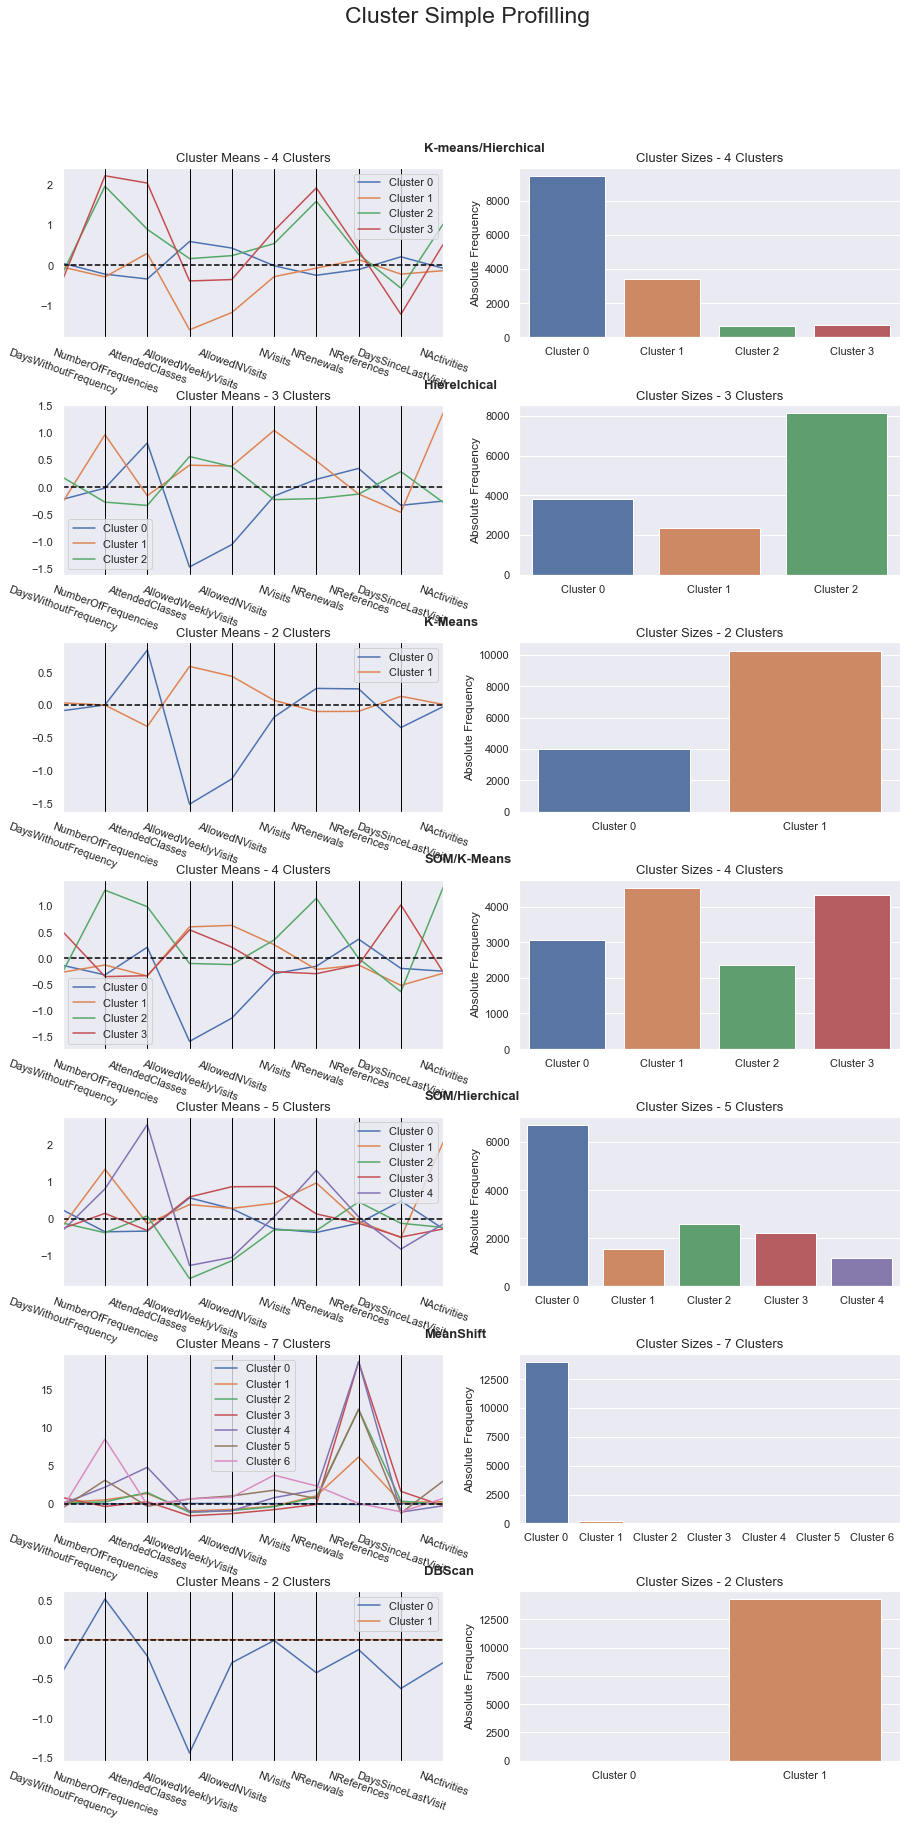

In [179]:
cluster_profiles(df_bhv, ['kmeans/hierchical_labels',
                          'hierarchical/bhv_labels',
                          'kmeans/bhv_labels',
                          'som_kmeans_bhv_labels',
                          'som_hierar_bhv_labels',
                          'mean_shift_bhv_labels',
                          'dbscan_bhv_labels'], 
                 (15,28),
                 compar_titles = ["K-means/Hierchical", 
                                  "Hierelchical",
                                  'K-Means',
                                  "SOM/K-Means",
                                  "SOM/Hierchical",
                                  "MeanShift",
                                  "DBScan"])

## Preferences

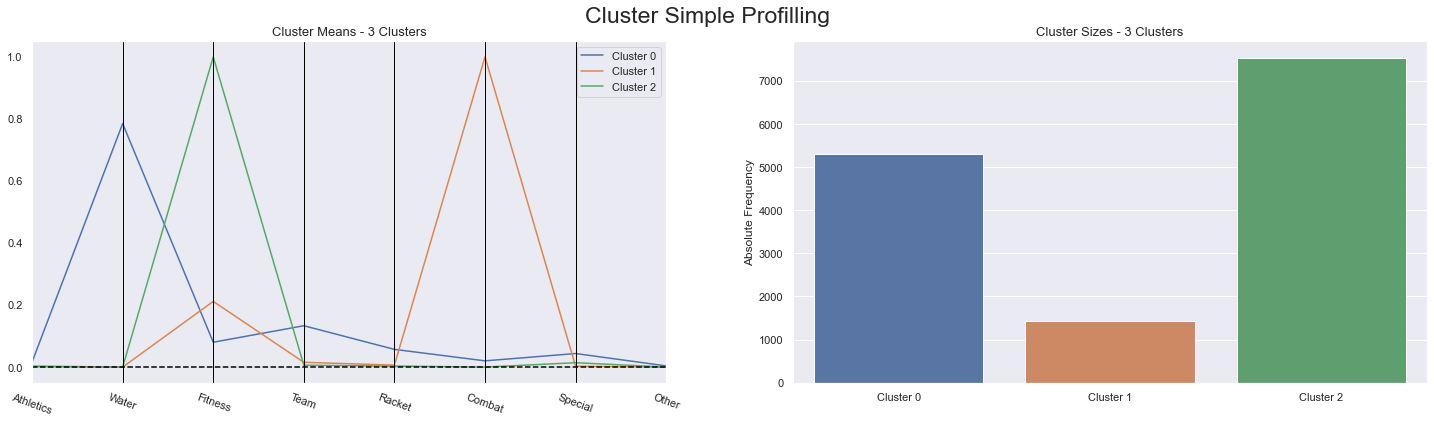

In [180]:
cluster_profiles(df_pref,['Kmodes_Clusters'],(25,6))

# Merging Perspectives

In [181]:
df['Demographic_labels'] = df_dem['som_kmeans_dem_labels']
df['Value_labels'] = df_bhv['som_kmeans_bhv_labels']
df['Preference_labels'] = df_pref['Kmodes_Clusters']


# Group by all three sets of labels and calculate mean for metric features
df_centroids = df.groupby(['Demographic_labels', 'Value_labels', 'Preference_labels'])[metric_features].mean()
df_centroids

Age  \
Demographic_labels Value_labels Preference_labels             
0                  0            0                 -0.957644   
                                1                 -0.597670   
                                2                 -0.127917   
                   1            0                 -0.161651   
                                1                 -0.295697   
                                2                 -0.168276   
                   2            0                 -0.454279   
                                1                 -0.137767   
                                2                 -0.064116   
                   3            0                 -0.248636   
                                1                 -0.300763   
                                2                 -0.181952   
1                  0            0                  1.322002   
                                1                  2.038880   
                                2                  1.717490   
                   1            0                  1.642940   
                                1                  1.231063   
                                2                  1.557318   
                   2            0                  1.969842   
                                1                  1.092777   
                                2                  2.105777   
                   3            0                  1.385249   
                                1                  1.123901   
                                2                  1.442008   
2                  0            0                 -0.695214   
                                1                 -1.052704   
                                2                  0.458774   
                   1            0                  0.200769   
                                1                 -0.121801   
                                2                  0.018154   
                   2            0                 -0.060114   
                                1                  0.029351   
                                2                  0.391403   
                   3            0                 -0.260360   
                                1                  0.056174   
                                2                 -0.056926   
3                  0            0                 -1.015764   
                                1                 -1.217135   
                                2                 -0.116405   
                   1            0                 -0.107701   
                                1                 -0.226895   
                                2                 -0.232604   
                   2            0                 -0.667491   
                                1                 -0.186093   
                                2                  0.270999   
                   3            0                 -0.241291   
                                1                 -0.236761   
                                2                 -0.252082   

                                                   DaysWithoutFrequency  \
Demographic_labels Value_labels Preference_labels                         
0                  0            0                             -0.220490   
                                1                             -0.444032   
                                2                             -0.512926   
                   1            0                             -0.280937   
                                1                             -0.245306   
                                2                             -0.355906   
                   2            0                             -0.291433   
                                1                             -0.220063   
                                2                             -0.453757   
                   3            0                             -0.108637   
     

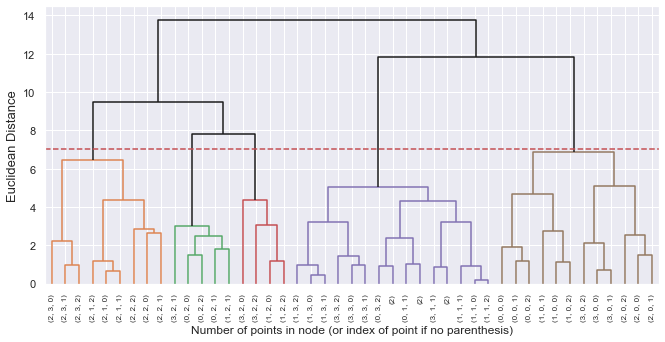

In [184]:
hclust = AgglomerativeClustering(
    linkage='ward',
    affinity='euclidean',
    n_clusters=None,
    distance_threshold=0
)

hclust_labels = hclust.fit_predict(df_centroids)

counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

for i, merge in enumerate(hclust.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

sns.set()
fig = plt.figure(figsize=(11, 5))
y_threshold = 7
dendrogram(linkage_matrix, truncate_mode='level', labels=df_centroids.index, p=5, color_threshold=y_threshold,
           above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'Euclidean Distance', fontsize=13)
plt.show()


In [188]:
hclust = AgglomerativeClustering(
    linkage='ward',
    affinity='euclidean',
    n_clusters=4
)

hclust_labels = hclust.fit_predict(df_centroids)
df_centroids['hclust_labels'] = hclust_labels
df_centroids

Age  \
Demographic_labels Value_labels Preference_labels             
0                  0            0                 -0.957644   
                                1                 -0.597670   
                                2                 -0.127917   
                   1            0                 -0.161651   
                                1                 -0.295697   
                                2                 -0.168276   
                   2            0                 -0.454279   
                                1                 -0.137767   
                                2                 -0.064116   
                   3            0                 -0.248636   
                                1                 -0.300763   
                                2                 -0.181952   
1                  0            0                  1.322002   
                                1                  2.038880   
                                2                  1.717490   
                   1            0                  1.642940   
                                1                  1.231063   
                                2                  1.557318   
                   2            0                  1.969842   
                                1                  1.092777   
                                2                  2.105777   
                   3            0                  1.385249   
                                1                  1.123901   
                                2                  1.442008   
2                  0            0                 -0.695214   
                                1                 -1.052704   
                                2                  0.458774   
                   1            0                  0.200769   
                                1                 -0.121801   
                                2                  0.018154   
                   2            0                 -0.060114   
                                1                  0.029351   
                                2                  0.391403   
                   3            0                 -0.260360   
                                1                  0.056174   
                                2                 -0.056926   
3                  0            0                 -1.015764   
                                1                 -1.217135   
                                2                 -0.116405   
                   1            0                 -0.107701   
                                1                 -0.226895   
                                2                 -0.232604   
                   2            0                 -0.667491   
                                1                 -0.186093   
                                2                  0.270999   
                   3            0                 -0.241291   
                                1                 -0.236761   
                                2                 -0.252082   

                                                   DaysWithoutFrequency  \
Demographic_labels Value_labels Preference_labels                         
0                  0            0                             -0.220490   
                                1                             -0.444032   
                                2                             -0.512926   
                   1            0                             -0.280937   
                                1                             -0.245306   
                                2                             -0.355906   
                   2            0                             -0.291433   
                                1                             -0.220063   
                                2                             -0.453757   
                   3            0                             -0.108637   
     

In [189]:
cluster_mapper = df_centroids['hclust_labels'].to_dict()

df_ = df.copy()

df_['merged_labels'] = df_.apply(
    lambda row: cluster_mapper[
        (row['Demographic_labels'], row['Value_labels'], row['Preference_labels'])
    ], axis=1
)
df_.groupby('merged_labels').mean()[metric_features]

Age  DaysWithoutFrequency  LifetimeValue  \
merged_labels                                                  
0              0.134114             -0.308138       1.337304   
1             -0.475821             -0.133561       0.031658   
2              0.029130              0.416175       0.691593   
3              0.154833              0.004606      -0.444326   

               NumberOfFrequencies  AttendedClasses  AllowedWeeklyVisits  \
merged_labels                                                              
0                         1.164329         1.098339            -0.191297   
1                        -0.316127         0.211354            -1.582972   
2                         0.745290         0.193957             0.300527   
3                        -0.287904        -0.342154             0.584168   

               AllowedNVisits   NVisits  NRenewals  NReferences  \
merged_labels                                                     
0                   -0.259850  0.414979   1.034802    -0.003223   
1                   -1.139484 -0.292796  -0.150845     0.363808   
2                    0.331501  0.023691   1.095941    -0.066687   
3                    0.414208  0.030543  -0.418439    -0.125890   

               EnrollmentTime  DaysSinceLastVisit  NActivities  \
merged_labels                                                    
0                   -0.552509           -0.768024     1.381988   
1                   -0.127893           -0.191644    -0.244416   
2                    1.899813           -0.171214     0.439315   
3                   -0.331668            0.265692    -0.279146   

               AvgLifeTimeValue  
merged_labels                    
0                     -0.702209  
1                      0.528934  
2                     -0.232177  
3                     -0.015630

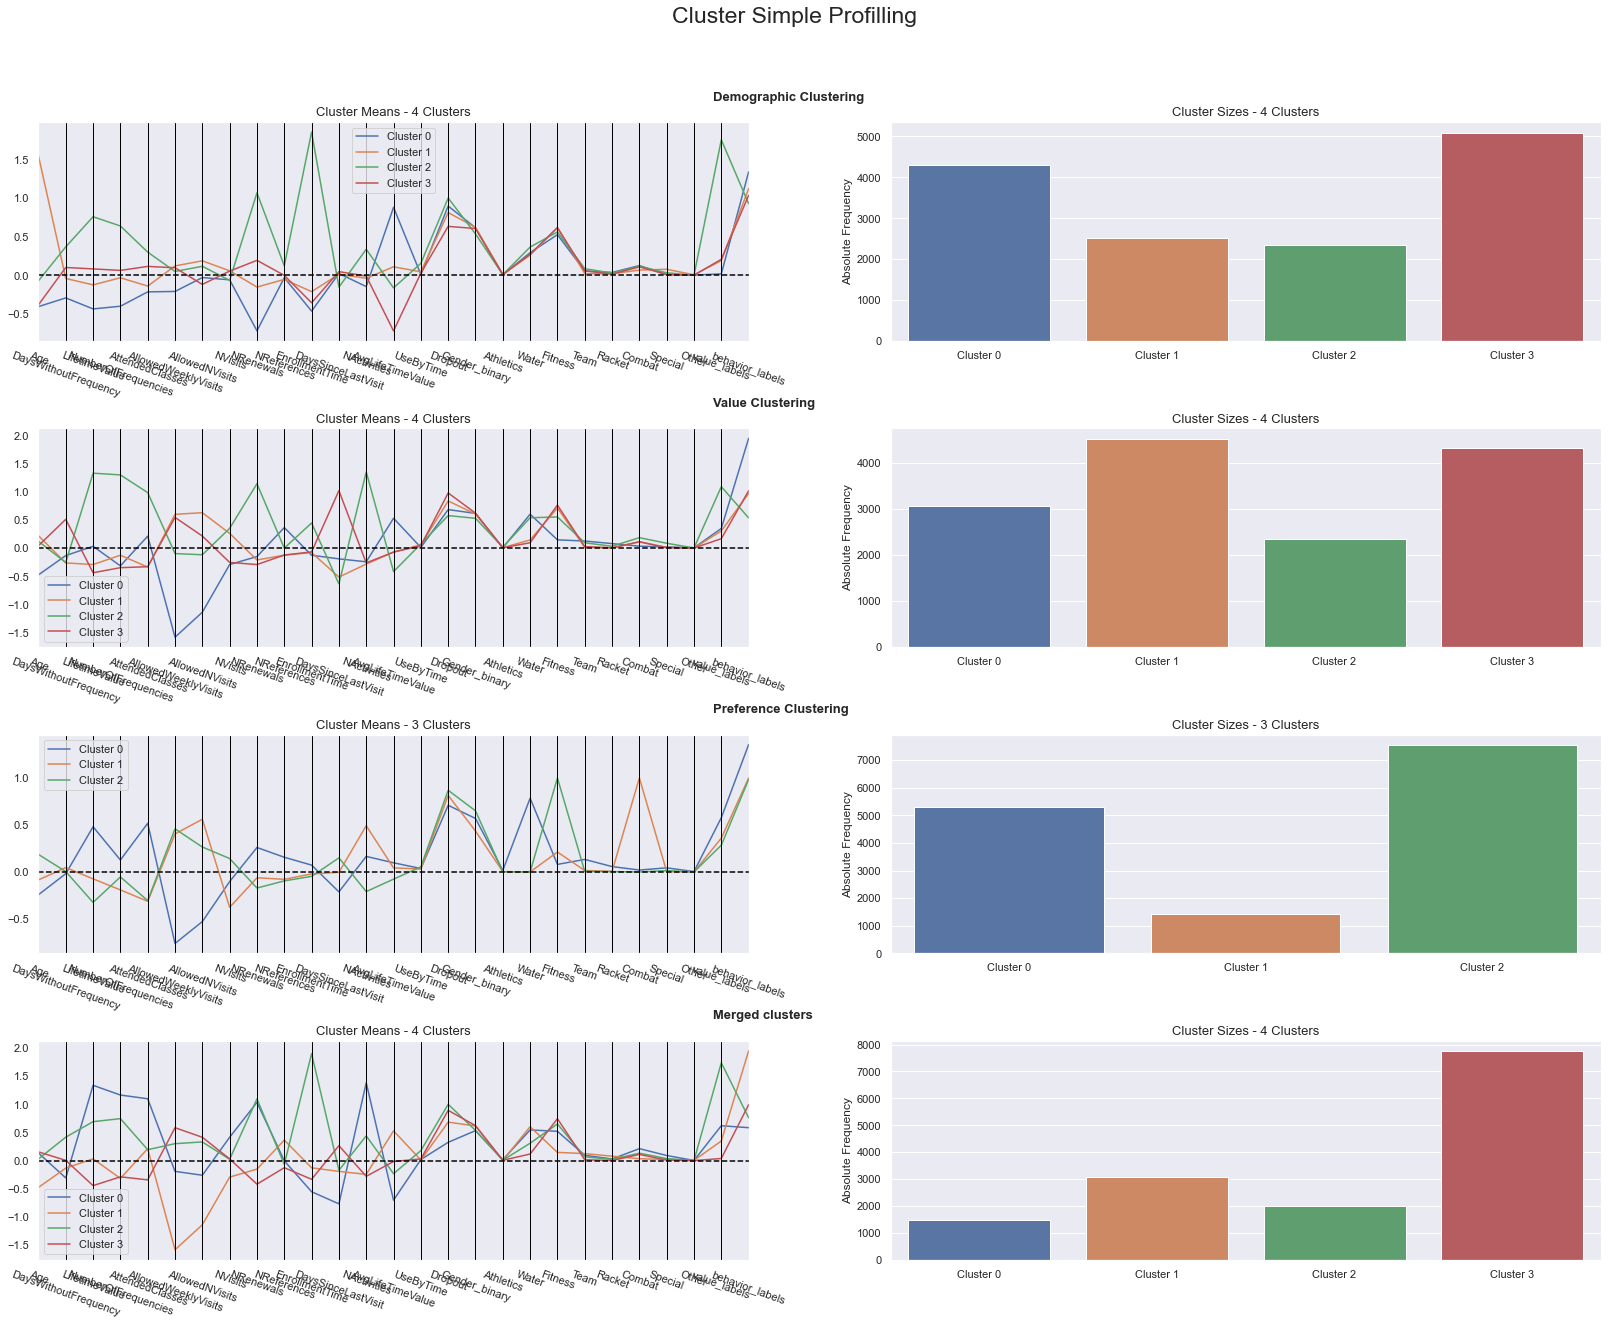

In [190]:
cluster_profiles(
    df=df_,
    label_columns=['Demographic_labels', 'Value_labels', 'Preference_labels', 'merged_labels'],
    figsize=(28, 20),
    compar_titles=["Demographic Clustering", "Value Clustering", "Preference Clustering", "Merged clusters"]
)


# T-SNE

In [191]:
Counter(df_['merged_labels'])

Counter({1: 3058, 3: 7747, 2: 1987, 0: 1474})

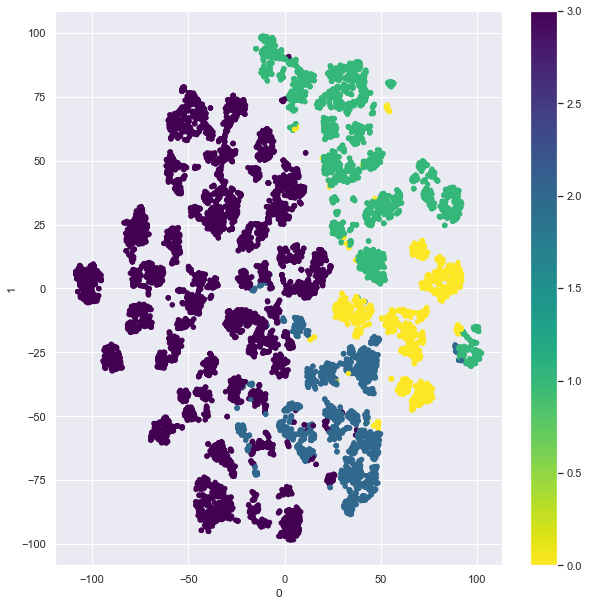

In [192]:
two_dim = TSNE(random_state=50).fit_transform(df_)
pd.DataFrame(two_dim).plot.scatter(x=0, y=1, c=df_['merged_labels'], colormap='viridis_r', figsize=(10,10))
plt.show()

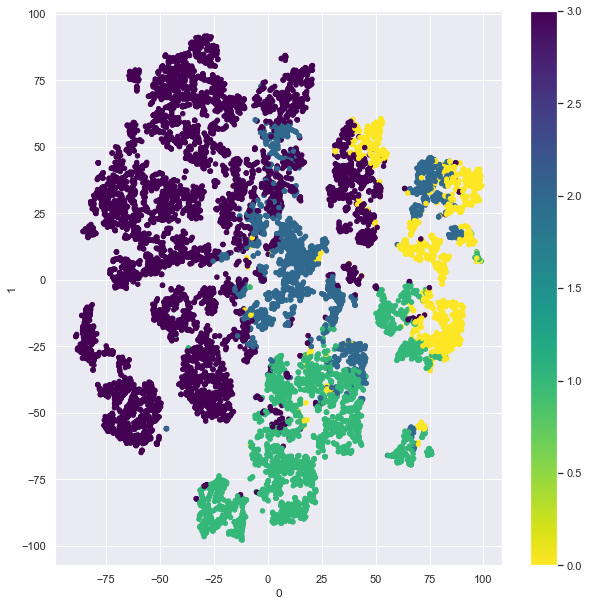

In [193]:
two_dim = TSNE(random_state=50).fit_transform(df[metric_features])
pd.DataFrame(two_dim).plot.scatter(x=0, y=1, c=df_['merged_labels'], colormap='viridis_r', figsize=(10,10))
plt.show()

# Feature Importance

In [194]:
def get_ss_variables(df):
    """Get the SS for each variable
    """
    ss_vars = df.var() * (df.count() - 1)
    return ss_vars

def r2_variables(df, labels):
    """Get the R² for each variable
    """
    sst_vars = get_ss_variables(df)
    ssw_vars = np.sum(df.groupby(labels).apply(get_ss_variables))
    return 1 - ssw_vars/sst_vars

In [195]:
r2_variables(df_[(behavior_features + dem_value_features + preference_features) + ['merged_labels']], 'merged_labels').drop('merged_labels').sort_values(ascending = False)

AllowedWeeklyVisits     0.738807
EnrollmentTime          0.597493
AllowedNVisits          0.393775
NRenewals               0.377888
LifetimeValue           0.358824
NumberOfFrequencies     0.283870
NActivities             0.279337
Fitness                 0.230164
Water                   0.211987
AttendedClasses         0.203031
AvgLifeTimeValue        0.118560
DaysSinceLastVisit      0.111236
Age                     0.063526
Team                    0.040506
Racket                  0.040210
DaysWithoutFrequency    0.037770
NReferences             0.037598
NVisits                 0.036754
Special                 0.025537
Combat                  0.025092
Other                   0.002352
Athletics               0.001818
dtype: float64

In [196]:
X = df_.drop(columns=['Demographic_labels','Value_labels','Preference_labels','merged_labels'])
y = df_['merged_labels']

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=93, stratify=y
)

# Fitting the decision tree
dt = DecisionTreeClassifier(random_state=93, max_depth=3)
dt.fit(X_train, y_train)
print("It is estimated that in average, we are able to predict {0:.2f}% of the customers correctly".format(dt.score(X_test, y_test)*100))

It is estimated that in average, we are able to predict 91.99% of the customers correctly


### The End